In [1]:
import numpy as np
import pandas as pd

def Ackley(x1, x2):
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1**2 + x2**2)))
    term2 = -np.exp(0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2)))
    return term1 + term2 + np.e + 20

def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    z = Ackley(x1, x2)
    return x1, x2, z

def create_dataframe(grid):
   x1, x2, z = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="HoleEffect")

/tmp/ipykernel_46309/1849667899.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


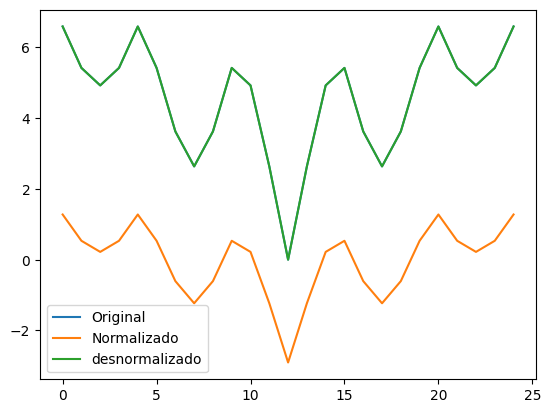

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [4]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 8.25 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [5]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [6]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-14 12:38:44.906090: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 12:38:44.906143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 12:38:44.907351: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 12:38:44.915323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 12:38:47.284868: W tensorflow/compiler/tf2

In [7]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [8]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [9]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  38
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 2s 54ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_3,0.719016,-0.159099,-2.011489,0.788911,0.469709,2.323633,2.220711,0.317847,2.112392e+14,0.685354,0.617384,0.696147,35.511282,72.475866
model_1_3_2,0.714093,-0.161185,-2.021808,0.783603,0.477939,2.327815,2.228320,0.325840,2.122128e+14,0.691332,0.610680,0.702219,35.476543,72.441126
model_1_3_1,0.709065,-0.163336,-2.032419,0.778151,0.486344,2.332129,2.236145,0.334049,2.131951e+14,0.697384,0.603833,0.708367,35.441677,72.406261
model_1_3_0,0.703930,-0.165553,-2.043315,0.772554,0.494928,2.336572,2.244180,0.342477,2.141865e+14,0.703511,0.596841,0.714591,35.406685,72.371269


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  53
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 31ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_4] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_0,0.848643,-0.068418,-1.612253,0.812121,0.253017,2.141847,1.926309,0.274032,1.788009e+14,0.503008,0.793897,0.510930,36.748595,73.713179
model_1_4_1,0.850398,-0.068792,-1.611400,0.813757,0.250083,2.142596,1.925680,0.271647,1.781715e+14,0.500083,0.796287,0.507959,36.771925,73.736509
model_1_4_2,0.852123,-0.069187,-1.610620,0.815364,0.247201,2.143387,1.925105,0.269302,1.775472e+14,0.497193,0.798635,0.505023,36.795111,73.759694
model_1_4_3,0.853816,-0.069600,-1.609907,0.816943,0.244370,2.144217,1.924579,0.266998,1.769280e+14,0.494338,0.800941,0.502123,36.818147,73.782730
model_1_4_4,0.855480,-0.070032,-1.609258,0.818497,0.241589,2.145083,1.924101,0.264733,1.763140e+14,0.491517,0.803206,0.499258,36.841033,73.805617
model_1_4_5,0.857113,-0.070480,-1.608667,0.820023,0.238859,2.145981,1.923665,0.262507,1.757051e+14,0.488732,0.805430,0.496429,36.863763,73.828346
model_1_4_6,0.858716,-0.070944,-1.608131,0.821523,0.236178,2.146911,1.923270,0.260319,1.751014e+14,0.485982,0.807614,0.493636,36.886335,73.850919
model_1_4_7,0.860290,-0.071423,-1.607647,0.822998,0.233547,2.147870,1.922913,0.258168,1.745030e+14,0.483267,0.809757,0.490878,36.908745,73.873329
model_1_4_8,0.861836,-0.071914,-1.607211,0.824447,0.230963,2.148854,1.922591,0.256054,1.739097e+14,0.480587,0.811862,0.488155,36.930991,73.895575
model_1_4_9,0.863353,-0.072418,-1.606820,0.825872,0.228428,2.149864,1.922303,0.253976,1.733218e+14,0.477941,0.813927,0.485468,36.953071,73.917654


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_5] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_0,0.865300,-0.072524,-1.603626,0.930757,0.225173,2.150077,1.919948,0.128677,1.726377e+14,0.474524,0.816578,0.481997,36.981773,73.946357
model_1_5_1,0.867206,-0.072648,-1.600530,0.932272,0.221987,2.150326,1.917665,0.125863,1.719585e+14,0.471155,0.819174,0.478575,37.010277,73.974860
model_1_5_2,0.869072,-0.072788,-1.597534,0.933737,0.218867,2.150608,1.915456,0.123139,1.712841e+14,0.467833,0.821715,0.475200,37.038580,74.003163
model_1_5_3,0.870899,-0.072946,-1.594639,0.935156,0.215814,2.150924,1.913320,0.120504,1.706143e+14,0.464558,0.824202,0.471874,37.066680,74.031263
model_1_5_4,0.872687,-0.073120,-1.591843,0.936528,0.212825,2.151273,1.911258,0.117954,1.699494e+14,0.461329,0.826637,0.468595,37.094573,74.059157
model_1_5_5,0.874437,-0.073310,-1.589145,0.937854,0.209899,2.151654,1.909269,0.115489,1.692892e+14,0.458147,0.829020,0.465363,37.122257,74.086841
model_1_5_6,0.876150,-0.073516,-1.586547,0.939137,0.207036,2.152066,1.907353,0.113105,1.686339e+14,0.455012,0.831353,0.462178,37.149729,74.114312
model_1_5_7,0.877826,-0.073738,-1.584048,0.940376,0.204233,2.152511,1.905511,0.110802,1.679834e+14,0.451921,0.833636,0.459039,37.176988,74.141571
model_1_5_8,0.879467,-0.073975,-1.581647,0.941573,0.201490,2.152986,1.903740,0.108577,1.673377e+14,0.448876,0.835870,0.455946,37.204030,74.168614
model_1_5_9,0.881073,-0.074226,-1.579340,0.942730,0.198806,2.153490,1.902039,0.106428,1.666970e+14,0.445877,0.838056,0.452899,37.230851,74.195435


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_6] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_0,0.882078,-0.074725,-1.577941,0.785336,0.197125,2.154490,1.901007,0.580726,1.664279e+14,0.443988,0.839426,0.450980,37.247834,74.212418
model_1_6_1,0.883066,-0.075225,-1.576580,0.786355,0.195475,2.155493,1.900004,0.577969,1.661614e+14,0.442125,0.840770,0.449088,37.264649,74.229233
model_1_6_2,0.884035,-0.075726,-1.575257,0.787358,0.193855,2.156497,1.899028,0.575254,1.658978e+14,0.440289,0.842090,0.447223,37.281292,74.245876
model_1_6_3,0.884986,-0.076227,-1.573971,0.788347,0.192264,2.157502,1.898080,0.572581,1.656369e+14,0.438480,0.843385,0.445385,37.297768,74.262352
model_1_6_4,0.885920,-0.076729,-1.572721,0.789320,0.190703,2.158507,1.897158,0.569948,1.653786e+14,0.436696,0.844657,0.443573,37.314075,74.278659
model_1_6_5,0.886837,-0.077231,-1.571505,0.790278,0.189170,2.159514,1.896261,0.567356,1.651231e+14,0.434937,0.845906,0.441787,37.330215,74.294799
model_1_6_6,0.887737,-0.077733,-1.570324,0.791222,0.187666,2.160521,1.895390,0.564803,1.648701e+14,0.433204,0.847131,0.440026,37.346188,74.310772
model_1_6_7,0.888621,-0.078235,-1.569174,0.792151,0.186188,2.161527,1.894542,0.562288,1.646198e+14,0.431495,0.848335,0.438291,37.361994,74.326578
model_1_6_8,0.889488,-0.078737,-1.568059,0.793066,0.184738,2.162534,1.893720,0.559812,1.643721e+14,0.429811,0.849516,0.436581,37.377635,74.342218
model_1_6_9,0.890340,-0.079240,-1.566975,0.793968,0.183314,2.163540,1.892921,0.557373,1.641268e+14,0.428152,0.850676,0.434895,37.393111,74.357695


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_7] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.891562,-0.079823,-1.567404,0.921378,0.181272,2.164710,1.893237,0.094982,1.636375e+14,0.425761,0.852339,0.432466,37.415512,74.380096
model_1_7_1,0.892758,-0.080414,-1.567858,0.922818,0.179272,2.165895,1.893571,0.093242,1.631530e+14,0.423406,0.853968,0.430074,37.437697,74.402281
model_1_7_2,0.893929,-0.081012,-1.568337,0.924223,0.177314,2.167094,1.893925,0.091545,1.626734e+14,0.421087,0.855563,0.427719,37.459663,74.424247
model_1_7_3,0.895076,-0.081617,-1.568840,0.925592,0.175396,2.168306,1.894296,0.089891,1.621983e+14,0.418804,0.857125,0.425399,37.481412,74.445996
model_1_7_4,0.896200,-0.082228,-1.569366,0.926927,0.173518,2.169532,1.894684,0.088278,1.617281e+14,0.416555,0.858655,0.423116,37.502942,74.467526
model_1_7_5,0.897300,-0.082845,-1.569914,0.928229,0.171679,2.170768,1.895088,0.086706,1.612625e+14,0.414342,0.860153,0.420867,37.524255,74.488838
model_1_7_6,0.898378,-0.083468,-1.570483,0.929497,0.169878,2.172016,1.895508,0.085174,1.608015e+14,0.412163,0.861620,0.418654,37.545347,74.509930
model_1_7_7,0.899433,-0.084095,-1.571073,0.930733,0.168114,2.173274,1.895942,0.083680,1.603450e+14,0.410018,0.863057,0.416475,37.566221,74.530804
model_1_7_8,0.900466,-0.084728,-1.571683,0.931938,0.166387,2.174543,1.896392,0.082225,1.598930e+14,0.407906,0.864464,0.414330,37.586875,74.551458
model_1_7_9,0.901478,-0.085365,-1.572311,0.933111,0.164696,2.175820,1.896855,0.080807,1.594454e+14,0.405827,0.865842,0.412219,37.607309,74.571893


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_8] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_9,0.912992,-0.081270,-1.568927,0.965220,0.145449,2.167610,1.894360,0.040809,1.528232e+14,0.381377,0.881520,0.387384,37.855865,74.820448
model_1_8_8,0.912162,-0.081531,-1.569063,0.965330,0.146836,2.168135,1.894460,0.040680,1.533450e+14,0.383191,0.880391,0.389226,37.836883,74.801466
model_1_8_7,0.911311,-0.081805,-1.569221,0.965405,0.148258,2.168683,1.894577,0.040593,1.538718e+14,0.385043,0.879232,0.391107,37.817598,74.782182
model_1_8_6,0.910438,-0.082091,-1.569402,0.965443,0.149717,2.169258,1.894710,0.040548,1.544036e+14,0.386933,0.878043,0.393027,37.798012,74.762595
model_1_8_5,0.909543,-0.082393,-1.569609,0.965443,0.151214,2.169861,1.894863,0.040549,1.549406e+14,0.388862,0.876824,0.394986,37.778120,74.742704
model_1_8_4,0.908624,-0.082708,-1.569841,0.965402,0.152749,2.170493,1.895034,0.040597,1.554828e+14,0.390831,0.875574,0.396986,37.757919,74.722503
model_1_8_3,0.907682,-0.083038,-1.570100,0.965318,0.154324,2.171155,1.895225,0.040695,1.560306e+14,0.392841,0.874291,0.399028,37.737402,74.701986
model_1_8_2,0.906715,-0.083382,-1.570386,0.965189,0.155940,2.171845,1.895436,0.040847,1.565841e+14,0.394893,0.872974,0.401112,37.716564,74.681148
model_1_8_1,0.905723,-0.083745,-1.570705,0.965012,0.157599,2.172572,1.895671,0.041053,1.571433e+14,0.396987,0.871623,0.403240,37.695403,74.659987
model_1_8_0,0.904704,-0.084123,-1.571053,0.964785,0.159302,2.173331,1.895928,0.041320,1.577088e+14,0.399127,0.870236,0.405413,37.673905,74.638489


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.913686,-0.081496,-1.567839,0.941343,0.144288,2.168063,1.893558,0.071977,1.524429e+14,0.379853,0.882466,0.385835,37.871884,74.836468
model_1_9_1,0.914365,-0.081732,-1.566800,0.942019,0.143152,2.168537,1.892792,0.071148,1.520667e+14,0.378354,0.883391,0.384313,37.887698,74.852281
model_1_9_2,0.915031,-0.081978,-1.565809,0.942680,0.142039,2.169031,1.892061,0.070336,1.516944e+14,0.376881,0.884298,0.382816,37.903307,74.867891
model_1_9_3,0.915683,-0.082234,-1.564861,0.943326,0.140949,2.169544,1.891362,0.069543,1.513262e+14,0.375432,0.885186,0.381345,37.918712,74.883296
model_1_9_4,0.916322,-0.082499,-1.563957,0.943959,0.139882,2.170074,1.890695,0.068767,1.509620e+14,0.374008,0.886055,0.379898,37.933913,74.898497
model_1_9_5,0.916947,-0.082770,-1.563092,0.944577,0.138837,2.170618,1.890057,0.068008,1.506017e+14,0.372608,0.886906,0.378476,37.948911,74.913495
model_1_9_6,0.917559,-0.083049,-1.562266,0.945182,0.137814,2.171177,1.889448,0.067266,1.502453e+14,0.371232,0.887740,0.377079,37.963708,74.928291
model_1_9_7,0.918158,-0.083335,-1.561479,0.945773,0.136811,2.171750,1.888868,0.066541,1.498928e+14,0.369880,0.888556,0.375706,37.978303,74.942887
model_1_9_8,0.918745,-0.083626,-1.560727,0.946351,0.135830,2.172335,1.888313,0.065831,1.495440e+14,0.368551,0.889355,0.374356,37.992700,74.957283
model_1_9_9,0.919320,-0.083924,-1.560011,0.946916,0.134869,2.172931,1.887785,0.065138,1.491990e+14,0.367246,0.890138,0.373029,38.006898,74.971481


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_10] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_0,0.920013,-0.084789,-1.561631,0.959955,0.133711,2.174666,1.888980,0.069265,1.487428e+14,0.365665,0.891082,0.371424,38.024152,74.988735
model_1_10_1,0.920691,-0.085655,-1.563265,0.960506,0.132578,2.176401,1.890185,0.068312,1.482907e+14,0.364113,0.892005,0.369847,38.041169,75.005753
model_1_10_2,0.921353,-0.086519,-1.564911,0.961036,0.131470,2.178134,1.891399,0.067396,1.478425e+14,0.362588,0.892907,0.368299,38.057949,75.022532
model_1_10_3,0.922001,-0.087383,-1.566569,0.961544,0.130387,2.179866,1.892621,0.066517,1.473983e+14,0.361092,0.893789,0.366779,38.074494,75.039077
model_1_10_4,0.922635,-0.088246,-1.568241,0.962032,0.129328,2.181596,1.893854,0.065673,1.469581e+14,0.359622,0.894652,0.365286,38.090803,75.055386
model_1_10_5,0.923254,-0.089108,-1.569922,0.962499,0.128293,2.183323,1.895094,0.064865,1.465218e+14,0.358180,0.895495,0.363821,38.106877,75.071461
model_1_10_6,0.923860,-0.089968,-1.571614,0.962947,0.127281,2.185048,1.896341,0.064090,1.460893e+14,0.356764,0.896320,0.362383,38.122721,75.087304
model_1_10_7,0.924452,-0.090826,-1.573318,0.963376,0.126291,2.186768,1.897598,0.063348,1.456606e+14,0.355375,0.897126,0.360971,38.138331,75.102915
model_1_10_8,0.925030,-0.091683,-1.575028,0.963786,0.125324,2.188485,1.898859,0.062639,1.452358e+14,0.354011,0.897914,0.359586,38.153713,75.118296
model_1_10_9,0.925596,-0.092537,-1.576749,0.964178,0.124378,2.190198,1.900128,0.061961,1.448146e+14,0.352672,0.898684,0.358226,38.168865,75.133449


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_11] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.926137,-0.093258,-1.578002,0.967834,0.123473,2.191643,1.901052,0.037802,1.444489e+14,0.351388,0.899421,0.356922,38.183459,75.148043
model_1_11_1,0.926666,-0.093978,-1.579267,0.967904,0.122589,2.193087,1.901985,0.037720,1.440865e+14,0.350127,0.900141,0.355641,38.197836,75.162420
model_1_11_2,0.927184,-0.094697,-1.580542,0.967961,0.121724,2.194528,1.902925,0.037653,1.437274e+14,0.348890,0.900846,0.354385,38.211995,75.176579
model_1_11_3,0.927690,-0.095415,-1.581826,0.968006,0.120878,2.195967,1.903872,0.037600,1.433716e+14,0.347676,0.901535,0.353151,38.225941,75.190525
model_1_11_4,0.928184,-0.096131,-1.583120,0.968039,0.120051,2.197402,1.904826,0.037561,1.430190e+14,0.346484,0.902209,0.351941,38.239672,75.204256
model_1_11_5,0.928668,-0.096845,-1.584421,0.968060,0.119243,2.198834,1.905785,0.037536,1.426697e+14,0.345315,0.902867,0.350754,38.253191,75.217774
model_1_11_6,0.929141,-0.097558,-1.585733,0.968071,0.118452,2.200264,1.906753,0.037524,1.423235e+14,0.344168,0.903511,0.349589,38.266498,75.231081
model_1_11_7,0.929604,-0.098269,-1.587051,0.968070,0.117679,2.201689,1.907725,0.037525,1.419805e+14,0.343043,0.904141,0.348446,38.279597,75.244180
model_1_11_8,0.930056,-0.098978,-1.588377,0.968059,0.116923,2.203110,1.908703,0.037538,1.416406e+14,0.341939,0.904757,0.347325,38.292487,75.257070
model_1_11_9,0.930498,-0.099684,-1.589709,0.968037,0.116183,2.204526,1.909685,0.037563,1.413037e+14,0.340857,0.905359,0.346225,38.305171,75.269754


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_12] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.930839,-0.100720,-1.591007,0.951004,0.115614,2.206601,1.910642,0.099138,1.409736e+14,0.340021,0.905823,0.345376,38.314996,75.279579
model_1_12_1,0.931172,-0.101749,-1.592308,0.951062,0.115058,2.208664,1.911601,0.099021,1.406468e+14,0.339202,0.906276,0.344544,38.324641,75.289225
model_1_12_2,0.931497,-0.102771,-1.593608,0.951114,0.114515,2.210713,1.912561,0.098915,1.403233e+14,0.338400,0.906719,0.343729,38.334108,75.298691
model_1_12_3,0.931814,-0.103787,-1.594910,0.951162,0.113984,2.212750,1.913520,0.098820,1.400030e+14,0.337615,0.907151,0.342932,38.343398,75.307982
model_1_12_4,0.932124,-0.104797,-1.596214,0.951204,0.113465,2.214775,1.914482,0.098734,1.396859e+14,0.336846,0.907573,0.342151,38.352516,75.317100
model_1_12_5,0.932427,-0.105800,-1.597516,0.951241,0.112959,2.216785,1.915442,0.098659,1.393720e+14,0.336094,0.907986,0.341387,38.361462,75.326046
model_1_12_6,0.932723,-0.106796,-1.598817,0.951274,0.112464,2.218783,1.916401,0.098593,1.390613e+14,0.335357,0.908389,0.340639,38.370238,75.334822
model_1_12_7,0.933012,-0.107786,-1.600119,0.951302,0.111981,2.220768,1.917362,0.098536,1.387537e+14,0.334636,0.908782,0.339906,38.378849,75.343432
model_1_12_8,0.933294,-0.108770,-1.601421,0.951326,0.111509,2.222739,1.918321,0.098488,1.384491e+14,0.333930,0.909167,0.339189,38.387294,75.351877
model_1_12_9,0.933570,-0.109747,-1.602721,0.951345,0.111049,2.224698,1.919280,0.098448,1.381477e+14,0.333239,0.909542,0.338488,38.395575,75.360159


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_13] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.933782,-0.110001,-1.601806,0.847135,0.110695,2.225208,1.918605,0.333737,1.381213e+14,0.332708,0.909830,0.337948,38.401958,75.366542
model_1_13_1,0.933989,-0.110254,-1.600910,0.847202,0.110348,2.225715,1.917945,0.333590,1.380951e+14,0.332187,0.910112,0.337419,38.408229,75.372812
model_1_13_2,0.934192,-0.110506,-1.600034,0.847267,0.110009,2.226221,1.917298,0.333449,1.380691e+14,0.331676,0.910389,0.336899,38.414390,75.378974
model_1_13_3,0.934391,-0.110757,-1.599176,0.847330,0.109676,2.226724,1.916666,0.333312,1.380433e+14,0.331174,0.910660,0.336390,38.420442,75.385025
model_1_13_4,0.934586,-0.111007,-1.598334,0.847390,0.109351,2.227224,1.916045,0.333180,1.380177e+14,0.330682,0.910925,0.335890,38.426390,75.390973
model_1_13_5,0.934776,-0.111256,-1.597512,0.847449,0.109032,2.227723,1.915439,0.333053,1.379923e+14,0.330200,0.911185,0.335400,38.432231,75.396814
model_1_13_6,0.934963,-0.111503,-1.596705,0.847505,0.108720,2.228218,1.914844,0.332930,1.379672e+14,0.329726,0.911439,0.334919,38.437967,75.402551
model_1_13_7,0.935146,-0.111749,-1.595916,0.847559,0.108414,2.228712,1.914262,0.332811,1.379421e+14,0.329262,0.911688,0.334448,38.443604,75.408188
model_1_13_8,0.935325,-0.111994,-1.595143,0.847612,0.108114,2.229202,1.913692,0.332697,1.379173e+14,0.328807,0.911932,0.333985,38.449140,75.413723
model_1_13_9,0.935501,-0.112237,-1.594386,0.847662,0.107821,2.229691,1.913134,0.332586,1.378927e+14,0.328360,0.912171,0.333532,38.454575,75.419158


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_14] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,0.935607,-0.112478,-1.593150,0.860704,0.107643,2.230173,1.912223,0.374894,1.379092e+14,0.328090,0.912316,0.333257,38.457868,75.422452
model_1_14_1,0.935711,-0.112717,-1.591930,0.860688,0.107470,2.230652,1.911323,0.374937,1.379256e+14,0.327826,0.912457,0.332989,38.461087,75.425671
model_1_14_2,0.935812,-0.112955,-1.590726,0.860671,0.107301,2.231130,1.910435,0.374982,1.379416e+14,0.327568,0.912595,0.332727,38.464236,75.428819
model_1_14_3,0.935911,-0.113193,-1.589541,0.860654,0.107136,2.231606,1.909561,0.375028,1.379574e+14,0.327316,0.912729,0.332471,38.467316,75.431899
model_1_14_4,0.936007,-0.113428,-1.588369,0.860636,0.106975,2.232079,1.908697,0.375076,1.379729e+14,0.327070,0.912861,0.332221,38.470328,75.434912
model_1_14_5,0.936101,-0.113664,-1.587217,0.860618,0.106817,2.232550,1.907847,0.375125,1.379881e+14,0.326829,0.912989,0.331976,38.473274,75.437857
model_1_14_6,0.936193,-0.113897,-1.586078,0.860599,0.106663,2.233018,1.907007,0.375176,1.380031e+14,0.326593,0.913114,0.331737,38.476156,75.440740
model_1_14_7,0.936283,-0.114130,-1.584955,0.860580,0.106513,2.233484,1.906180,0.375228,1.380179e+14,0.326363,0.913236,0.331503,38.478975,75.443558
model_1_14_8,0.936371,-0.114361,-1.583848,0.860560,0.106366,2.233947,1.905363,0.375281,1.380324e+14,0.326139,0.913356,0.331275,38.481729,75.446313
model_1_14_9,0.936456,-0.114590,-1.582754,0.860539,0.106223,2.234407,1.904556,0.375337,1.380468e+14,0.325919,0.913473,0.331052,38.484423,75.449007


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_15] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_0,0.936760,-0.115380,-1.583172,0.936661,0.105716,2.235991,1.904864,0.054447,1.377235e+14,0.325140,0.913886,0.330261,38.493998,75.458581
model_1_15_1,0.937055,-0.116166,-1.583605,0.936184,0.105223,2.237566,1.905184,0.054857,1.374034e+14,0.324381,0.914287,0.329489,38.503349,75.467933
model_1_15_2,0.937341,-0.116947,-1.584054,0.935697,0.104744,2.239133,1.905515,0.055276,1.370867e+14,0.323641,0.914678,0.328738,38.512476,75.477060
model_1_15_3,0.937620,-0.117724,-1.584517,0.935200,0.104278,2.240689,1.905857,0.055702,1.367731e+14,0.322921,0.915057,0.328007,38.521388,75.485971
model_1_15_4,0.937891,-0.118495,-1.584993,0.934695,0.103826,2.242235,1.906207,0.056136,1.364628e+14,0.322220,0.915426,0.327295,38.530083,75.494667
model_1_15_5,0.938154,-0.119261,-1.585482,0.934182,0.103386,2.243771,1.906568,0.056577,1.361557e+14,0.321537,0.915784,0.326601,38.538569,75.503153
model_1_15_6,0.938409,-0.120022,-1.585982,0.933662,0.102959,2.245297,1.906937,0.057025,1.358517e+14,0.320872,0.916132,0.325926,38.546849,75.511433
model_1_15_7,0.938657,-0.120778,-1.586494,0.933134,0.102544,2.246812,1.907314,0.057479,1.355509e+14,0.320225,0.916470,0.325268,38.554927,75.519511
model_1_15_8,0.938899,-0.121528,-1.587016,0.932599,0.102141,2.248316,1.907699,0.057938,1.352532e+14,0.319595,0.916798,0.324628,38.562804,75.527387
model_1_15_9,0.939133,-0.122273,-1.587546,0.932058,0.101749,2.249810,1.908090,0.058403,1.349586e+14,0.318982,0.917117,0.324005,38.570486,75.535069


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_16] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_0,0.939376,-0.123098,-1.589013,0.949953,0.101343,2.251462,1.909172,0.033821,1.346833e+14,0.318344,0.917448,0.323358,38.578490,75.543073
model_1_16_1,0.939613,-0.123918,-1.590479,0.949298,0.100946,2.253106,1.910253,0.034264,1.344106e+14,0.317720,0.917771,0.322724,38.586341,75.550924
model_1_16_2,0.939845,-0.124735,-1.591945,0.948645,0.100558,2.254744,1.911334,0.034705,1.341402e+14,0.317109,0.918087,0.322103,38.594043,75.558626
model_1_16_3,0.940072,-0.125548,-1.593408,0.947994,0.100179,2.256374,1.912413,0.035145,1.338723e+14,0.316510,0.918396,0.321495,38.601596,75.566180
model_1_16_4,0.940294,-0.126357,-1.594873,0.947344,0.099809,2.257996,1.913493,0.035584,1.336068e+14,0.315925,0.918698,0.320900,38.609002,75.573586
model_1_16_5,0.940510,-0.127163,-1.596335,0.946697,0.099447,2.259612,1.914571,0.036022,1.333436e+14,0.315352,0.918993,0.320318,38.616266,75.580849
model_1_16_6,0.940722,-0.127965,-1.597798,0.946051,0.099093,2.261220,1.915650,0.036458,1.330828e+14,0.314791,0.919280,0.319749,38.623387,75.587970
model_1_16_7,0.940928,-0.128764,-1.599259,0.945408,0.098748,2.262821,1.916727,0.036893,1.328243e+14,0.314242,0.919562,0.319191,38.630367,75.594951
model_1_16_8,0.941130,-0.129558,-1.600717,0.944767,0.098411,2.264413,1.917803,0.037326,1.325681e+14,0.313705,0.919836,0.318645,38.637210,75.601793
model_1_16_9,0.941327,-0.130348,-1.602172,0.944128,0.098081,2.265996,1.918876,0.037758,1.323143e+14,0.313180,0.920105,0.318112,38.643914,75.608498


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_17] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.941500,-0.131035,-1.603361,0.964815,0.097792,2.267375,1.919752,0.044467,1.320837e+14,0.312717,0.920341,0.317642,38.649827,75.614410
model_1_17_1,0.941669,-0.131718,-1.604540,0.964530,0.097510,2.268744,1.920621,0.044828,1.318551e+14,0.312266,0.920570,0.317184,38.655600,75.620184
model_1_17_2,0.941833,-0.132397,-1.605710,0.964240,0.097235,2.270104,1.921484,0.045194,1.316285e+14,0.311826,0.920794,0.316737,38.661240,75.625824
model_1_17_3,0.941993,-0.133071,-1.606872,0.963946,0.096968,2.271456,1.922341,0.045565,1.314038e+14,0.311397,0.921012,0.316301,38.666745,75.631329
model_1_17_4,0.942149,-0.133741,-1.608025,0.963648,0.096708,2.272800,1.923191,0.045942,1.311809e+14,0.310979,0.921224,0.315877,38.672119,75.636702
model_1_17_5,0.942300,-0.134407,-1.609168,0.963346,0.096455,2.274133,1.924034,0.046324,1.309599e+14,0.310572,0.921430,0.315463,38.677362,75.641945
model_1_17_6,0.942447,-0.135068,-1.610305,0.963040,0.096208,2.275459,1.924873,0.046710,1.307407e+14,0.310175,0.921630,0.315060,38.682477,75.647060
model_1_17_7,0.942591,-0.135725,-1.611433,0.962731,0.095969,2.276776,1.925705,0.047102,1.305233e+14,0.309788,0.921826,0.314667,38.687464,75.652047
model_1_17_8,0.942730,-0.136377,-1.612551,0.962417,0.095736,2.278084,1.926529,0.047498,1.303077e+14,0.309412,0.922015,0.314285,38.692326,75.656910
model_1_17_9,0.942866,-0.137025,-1.613662,0.962100,0.095509,2.279383,1.927349,0.047899,1.300940e+14,0.309046,0.922200,0.313913,38.697062,75.661646


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_18] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_0,0.943006,-0.137543,-1.614436,0.955539,0.095275,2.280421,1.927919,0.053433,1.299182e+14,0.308667,0.922391,0.313528,38.701970,75.666553
model_1_18_1,0.943142,-0.138055,-1.615209,0.955395,0.095047,2.281447,1.928489,0.053606,1.297440e+14,0.308296,0.922577,0.313152,38.706773,75.671357
model_1_18_2,0.943276,-0.138563,-1.615983,0.955248,0.094823,2.282465,1.929059,0.053783,1.295712e+14,0.307934,0.922759,0.312784,38.711476,75.676060
model_1_18_3,0.943406,-0.139065,-1.616757,0.955098,0.094605,2.283471,1.929630,0.053963,1.293998e+14,0.307580,0.922936,0.312424,38.716081,75.680665
model_1_18_4,0.943534,-0.139562,-1.617530,0.954947,0.094392,2.284468,1.930201,0.054145,1.292298e+14,0.307233,0.923110,0.312072,38.720590,75.685174
model_1_18_5,0.943658,-0.140054,-1.618304,0.954793,0.094184,2.285455,1.930771,0.054330,1.290611e+14,0.306895,0.923279,0.311728,38.725004,75.689587
model_1_18_6,0.943780,-0.140542,-1.619077,0.954637,0.093981,2.286432,1.931341,0.054517,1.288939e+14,0.306563,0.923445,0.311391,38.729323,75.693907
model_1_18_7,0.943898,-0.141024,-1.619850,0.954479,0.093783,2.287399,1.931911,0.054706,1.287280e+14,0.306240,0.923606,0.311063,38.733550,75.698134
model_1_18_8,0.944014,-0.141502,-1.620623,0.954320,0.093589,2.288357,1.932482,0.054898,1.285634e+14,0.305923,0.923764,0.310741,38.737690,75.702274
model_1_18_9,0.944128,-0.141975,-1.621395,0.954159,0.093399,2.289305,1.933051,0.055092,1.284003e+14,0.305613,0.923919,0.310426,38.741739,75.706323


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_19] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_0,0.944167,-0.142287,-1.620493,0.873533,0.093334,2.289931,1.932386,0.284810,1.284944e+14,0.305506,0.923972,0.310317,38.743148,75.707731
model_1_19_1,0.944205,-0.142598,-1.619604,0.873356,0.093271,2.290554,1.931730,0.285208,1.285877e+14,0.305402,0.924024,0.310212,38.744500,75.709084
model_1_19_2,0.944241,-0.142907,-1.618725,0.873180,0.093210,2.291174,1.931082,0.285605,1.286804e+14,0.305303,0.924073,0.310112,38.745798,75.710381
model_1_19_3,0.944276,-0.143214,-1.617857,0.873003,0.093152,2.291789,1.930442,0.286002,1.287724e+14,0.305208,0.924120,0.310015,38.747042,75.711626
model_1_19_4,0.944309,-0.143519,-1.616999,0.872828,0.093097,2.292401,1.929809,0.286397,1.288637e+14,0.305117,0.924165,0.309923,38.748234,75.712817
model_1_19_5,0.944341,-0.143822,-1.616151,0.872652,0.093044,2.293009,1.929184,0.286793,1.289543e+14,0.305031,0.924208,0.309834,38.749373,75.713957
model_1_19_6,0.944371,-0.144124,-1.615314,0.872477,0.092993,2.293613,1.928566,0.287187,1.290443e+14,0.304947,0.924250,0.309750,38.750464,75.715048
model_1_19_7,0.944400,-0.144423,-1.614488,0.872302,0.092945,2.294213,1.927957,0.287581,1.291337e+14,0.304868,0.924289,0.309669,38.751505,75.716088
model_1_19_8,0.944427,-0.144721,-1.613670,0.872128,0.092898,2.294810,1.927354,0.287974,1.292223e+14,0.304792,0.924327,0.309593,38.752498,75.717082
model_1_19_9,0.944454,-0.145016,-1.612862,0.871954,0.092854,2.295402,1.926759,0.288366,1.293103e+14,0.304720,0.924363,0.309519,38.753445,75.718029


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_20] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_0,0.944554,-0.145709,-1.614467,0.960763,0.092686,2.296791,1.927942,0.054143,1.291125e+14,0.304444,0.924500,0.309239,38.757075,75.721658
model_1_20_1,0.944653,-0.146397,-1.616057,0.960602,0.092522,2.298169,1.929115,0.054366,1.289167e+14,0.304175,0.924633,0.308965,38.760615,75.725198
model_1_20_2,0.944748,-0.147080,-1.617636,0.960440,0.092363,2.299539,1.930278,0.054589,1.287229e+14,0.303912,0.924763,0.308699,38.764063,75.728647
model_1_20_3,0.944841,-0.147758,-1.619200,0.960277,0.092208,2.300898,1.931432,0.054814,1.285313e+14,0.303657,0.924889,0.308440,38.767422,75.732006
model_1_20_4,0.944931,-0.148432,-1.620751,0.960114,0.092057,2.302250,1.932576,0.055039,1.283417e+14,0.303409,0.925012,0.308187,38.770696,75.735280
model_1_20_5,0.945019,-0.149101,-1.622291,0.959950,0.091910,2.303592,1.933711,0.055266,1.281539e+14,0.303167,0.925132,0.307942,38.773885,75.738468
model_1_20_6,0.945104,-0.149766,-1.623816,0.959785,0.091768,2.304924,1.934836,0.055493,1.279682e+14,0.302932,0.925248,0.307703,38.776993,75.741576
model_1_20_7,0.945187,-0.150426,-1.625330,0.959620,0.091629,2.306247,1.935952,0.055720,1.277844e+14,0.302703,0.925361,0.307470,38.780016,75.744600
model_1_20_8,0.945268,-0.151082,-1.626830,0.959455,0.091494,2.307561,1.937059,0.055949,1.276026e+14,0.302480,0.925471,0.307244,38.782961,75.747545
model_1_20_9,0.945346,-0.151732,-1.628318,0.959289,0.091363,2.308866,1.938156,0.056178,1.274226e+14,0.302263,0.925577,0.307024,38.785828,75.750411


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_21] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_9,0.946179,-0.149244,-1.634507,0.982072,0.089971,2.303877,1.942719,0.046462,1.254492e+14,0.299951,0.926712,0.304675,38.816543,75.781126
model_1_21_8,0.946116,-0.149516,-1.633894,0.982312,0.090075,2.304422,1.942268,0.045841,1.256398e+14,0.300125,0.926627,0.304852,38.814224,75.778807
model_1_21_7,0.946049,-0.149782,-1.633280,0.982543,0.090187,2.304956,1.941815,0.045241,1.258319e+14,0.300312,0.926535,0.305041,38.811740,75.776323
model_1_21_6,0.945978,-0.150044,-1.632662,0.982767,0.090306,2.305480,1.941359,0.044661,1.260256e+14,0.300510,0.926438,0.305243,38.809092,75.773675
model_1_21_5,0.945902,-0.150300,-1.632042,0.982982,0.090434,2.305994,1.940902,0.044104,1.262208e+14,0.300722,0.926334,0.305458,38.806276,75.770860
model_1_21_4,0.945821,-0.150551,-1.631421,0.983189,0.090569,2.306498,1.940444,0.043567,1.264175e+14,0.300946,0.926225,0.305686,38.803295,75.767878
model_1_21_3,0.945736,-0.150797,-1.630799,0.983387,0.090711,2.306991,1.939985,0.043053,1.266157e+14,0.301183,0.926108,0.305927,38.800143,75.764727
model_1_21_2,0.945646,-0.151038,-1.630177,0.983578,0.090862,2.307474,1.939526,0.042560,1.268153e+14,0.301434,0.925985,0.306181,38.796822,75.761405
model_1_21_1,0.945551,-0.151274,-1.629555,0.983759,0.091021,2.307947,1.939068,0.042090,1.270164e+14,0.301697,0.925856,0.306448,38.793329,75.757913
model_1_21_0,0.945451,-0.151505,-1.628936,0.983932,0.091188,2.308410,1.938611,0.041642,1.272188e+14,0.301974,0.925720,0.306729,38.789664,75.754247


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_22] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_0,0.946239,-0.149349,-1.635513,0.899192,0.089870,2.304088,1.943461,0.072082,1.252583e+14,0.299784,0.926793,0.304505,38.818771,75.783355
model_1_22_1,0.946296,-0.149455,-1.636513,0.898333,0.089775,2.304301,1.944199,0.072696,1.250694e+14,0.299624,0.926871,0.304343,38.820907,75.785491
model_1_22_2,0.946351,-0.149563,-1.637511,0.897474,0.089683,2.304517,1.944935,0.073310,1.248822e+14,0.299471,0.926946,0.304187,38.822952,75.787535
model_1_22_3,0.946403,-0.149672,-1.638506,0.896616,0.089595,2.304737,1.945668,0.073923,1.246967e+14,0.299324,0.927018,0.304039,38.824909,75.789492
model_1_22_4,0.946454,-0.149784,-1.639497,0.895758,0.089511,2.304960,1.946399,0.074537,1.245130e+14,0.299185,0.927086,0.303896,38.826779,75.791362
model_1_22_5,0.946501,-0.149897,-1.640485,0.894901,0.089431,2.305186,1.947128,0.075150,1.243309e+14,0.299051,0.927151,0.303761,38.828566,75.793149
model_1_22_6,0.946547,-0.150011,-1.641469,0.894044,0.089355,2.305415,1.947853,0.075762,1.241506e+14,0.298924,0.927213,0.303631,38.830269,75.794852
model_1_22_7,0.946590,-0.150126,-1.642448,0.893189,0.089283,2.305645,1.948575,0.076374,1.239720e+14,0.298802,0.927272,0.303508,38.831892,75.796475
model_1_22_8,0.946632,-0.150243,-1.643423,0.892334,0.089214,2.305880,1.949295,0.076985,1.237950e+14,0.298687,0.927328,0.303391,38.833435,75.798019
model_1_22_9,0.946671,-0.150360,-1.644395,0.891480,0.089149,2.306116,1.950011,0.077596,1.236197e+14,0.298578,0.927381,0.303280,38.834901,75.799485


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.946724,-0.150759,-1.645809,0.983517,0.089060,2.306915,1.951054,0.035721,1.234637e+14,0.298429,0.927454,0.303129,38.836897,75.801481
model_1_23_1,0.946776,-0.151155,-1.647213,0.983441,0.088973,2.307709,1.952089,0.035887,1.233092e+14,0.298284,0.927524,0.302981,38.838840,75.803424
model_1_23_2,0.946826,-0.151549,-1.648607,0.983364,0.088889,2.308499,1.953117,0.036053,1.231563e+14,0.298143,0.927593,0.302838,38.840735,75.805318
model_1_23_3,0.946875,-0.151941,-1.649990,0.983287,0.088807,2.309284,1.954137,0.036220,1.230049e+14,0.298005,0.927660,0.302698,38.842581,75.807165
model_1_23_4,0.946923,-0.152331,-1.651364,0.983209,0.088727,2.310065,1.955150,0.036388,1.228550e+14,0.297871,0.927725,0.302562,38.844379,75.808962
model_1_23_5,0.946969,-0.152718,-1.652726,0.983131,0.088650,2.310841,1.956155,0.036557,1.227066e+14,0.297741,0.927788,0.302430,38.846129,75.810712
model_1_23_6,0.947014,-0.153103,-1.654080,0.983053,0.088574,2.311613,1.957153,0.036726,1.225596e+14,0.297614,0.927849,0.302301,38.847835,75.812418
model_1_23_7,0.947058,-0.153486,-1.655423,0.982975,0.088500,2.312380,1.958144,0.036897,1.224142e+14,0.297490,0.927909,0.302176,38.849494,75.814078
model_1_23_8,0.947101,-0.153866,-1.656756,0.982896,0.088429,2.313143,1.959126,0.037068,1.222701e+14,0.297370,0.927967,0.302053,38.851110,75.815694
model_1_23_9,0.947143,-0.154244,-1.658079,0.982816,0.088359,2.313900,1.960102,0.037239,1.221274e+14,0.297253,0.928024,0.301935,38.852684,75.817267


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_24] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_9,0.947113,-0.152110,-1.642253,0.910999,0.088409,2.309623,1.948431,0.281886,1.238181e+14,0.297336,0.927984,0.302019,38.851571,75.816155
model_1_24_8,0.947121,-0.152309,-1.643772,0.911223,0.088395,2.310023,1.949552,0.281177,1.236554e+14,0.297313,0.927995,0.301995,38.851878,75.816462
model_1_24_7,0.947128,-0.152512,-1.645304,0.911447,0.088383,2.310428,1.950682,0.280466,1.234914e+14,0.297293,0.928005,0.301975,38.852145,75.816728
model_1_24_6,0.947134,-0.152717,-1.646849,0.911673,0.088373,2.310839,1.951821,0.279753,1.233260e+14,0.297277,0.928013,0.301958,38.852369,75.816953
model_1_24_5,0.947139,-0.152925,-1.648409,0.911899,0.088365,2.311257,1.952971,0.279037,1.231592e+14,0.297263,0.928019,0.301945,38.852552,75.817135
model_1_24_4,0.947143,-0.153136,-1.649984,0.912126,0.088359,2.311681,1.954133,0.278318,1.229909e+14,0.297253,0.928024,0.301934,38.852689,75.817273
model_1_24_3,0.947145,-0.153351,-1.651572,0.912353,0.088355,2.312111,1.955303,0.277597,1.228212e+14,0.297246,0.928028,0.301927,38.852785,75.817368
model_1_24_2,0.947147,-0.153569,-1.653177,0.912582,0.088353,2.312548,1.956487,0.276873,1.226500e+14,0.297242,0.928029,0.301924,38.852831,75.817414
model_1_24_1,0.947147,-0.153791,-1.654795,0.912811,0.088353,2.312992,1.957680,0.276147,1.224773e+14,0.297242,0.928029,0.301924,38.852831,75.817415
model_1_24_0,0.947145,-0.154016,-1.656430,0.913041,0.088355,2.313443,1.958886,0.275418,1.223031e+14,0.297246,0.928028,0.301927,38.852783,75.817366


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_25] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_0,0.947166,-0.152121,-1.642603,0.963908,0.088321,2.309645,1.948690,0.032677,1.237163e+14,0.297189,0.928055,0.301869,38.853551,75.818134
model_1_25_1,0.947217,-0.152132,-1.642952,0.963807,0.088236,2.309667,1.948947,0.032769,1.236154e+14,0.297045,0.928125,0.301723,38.855488,75.820072
model_1_25_2,0.947267,-0.152144,-1.643301,0.963705,0.088152,2.309691,1.949204,0.032861,1.235155e+14,0.296904,0.928193,0.301580,38.857380,75.821963
model_1_25_3,0.947315,-0.152156,-1.643648,0.963604,0.088071,2.309716,1.949461,0.032952,1.234166e+14,0.296767,0.928259,0.301441,38.859231,75.823814
model_1_25_4,0.947363,-0.152169,-1.643996,0.963502,0.087991,2.309741,1.949717,0.033044,1.233185e+14,0.296633,0.928324,0.301304,38.861043,75.825626
model_1_25_5,0.947410,-0.152182,-1.644341,0.963400,0.087913,2.309767,1.949971,0.033137,1.232214e+14,0.296501,0.928388,0.301171,38.862814,75.827398
model_1_25_6,0.947455,-0.152196,-1.644685,0.963298,0.087837,2.309795,1.950225,0.033229,1.231252e+14,0.296373,0.928450,0.301041,38.864545,75.829129
model_1_25_7,0.947500,-0.152210,-1.645029,0.963195,0.087763,2.309823,1.950478,0.033322,1.230299e+14,0.296248,0.928510,0.300913,38.866237,75.830821
model_1_25_8,0.947543,-0.152224,-1.645370,0.963093,0.087690,2.309851,1.950730,0.033415,1.229355e+14,0.296125,0.928569,0.300789,38.867894,75.832477
model_1_25_9,0.947586,-0.152239,-1.645713,0.962990,0.087619,2.309881,1.950983,0.033508,1.228418e+14,0.296005,0.928627,0.300667,38.869512,75.834096


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  42
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_26] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_0,0.947458,-0.166826,-1.695214,0.959298,0.087832,2.339123,1.987486,0.079289,1.187930e+14,0.296364,0.928454,0.301032,38.864665,75.829249
model_1_26_1,0.947444,-0.167157,-1.696321,0.959106,0.087855,2.339787,1.988302,0.079663,1.187017e+14,0.296404,0.928435,0.301072,38.864127,75.828710
model_1_26_2,0.947430,-0.167485,-1.697417,0.958916,0.087880,2.340445,1.989111,0.080034,1.186113e+14,0.296445,0.928415,0.301114,38.863574,75.828158
model_1_26_3,0.947415,-0.167810,-1.698504,0.958726,0.087904,2.341097,1.989912,0.080404,1.185216e+14,0.296487,0.928395,0.301156,38.863011,75.827595
model_1_26_4,0.947400,-0.168133,-1.699580,0.958537,0.087930,2.341744,1.990705,0.080773,1.184328e+14,0.296529,0.928374,0.301199,38.862436,75.827019
model_1_26_5,0.947384,-0.168452,-1.700644,0.958349,0.087955,2.342384,1.991490,0.081139,1.183447e+14,0.296573,0.928353,0.301244,38.861850,75.826433
model_1_26_6,0.947369,-0.168769,-1.701699,0.958162,0.087982,2.343018,1.992268,0.081503,1.182575e+14,0.296617,0.928332,0.301289,38.861252,75.825835
model_1_26_7,0.947353,-0.169082,-1.702743,0.957976,0.088008,2.343646,1.993038,0.081866,1.181710e+14,0.296662,0.928310,0.301334,38.860646,75.825229
model_1_26_8,0.947336,-0.169392,-1.703777,0.957791,0.088036,2.344269,1.993800,0.082226,1.180854e+14,0.296708,0.928288,0.301381,38.860028,75.824612
model_1_26_9,0.947320,-0.169701,-1.704804,0.957606,0.088063,2.344887,1.994557,0.082585,1.180004e+14,0.296754,0.928265,0.301428,38.859402,75.823985


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_27] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.947372,-0.170069,-1.705456,0.969834,0.087977,2.345625,1.995038,0.038139,1.179026e+14,0.296609,0.928336,0.301280,38.861366,75.825949
model_1_27_1,0.947422,-0.170434,-1.706108,0.969604,0.087893,2.346357,1.995519,0.038429,1.178057e+14,0.296467,0.928404,0.301136,38.863273,75.827857
model_1_27_2,0.947471,-0.170796,-1.706757,0.969373,0.087811,2.347083,1.995997,0.038722,1.177094e+14,0.296330,0.928471,0.300997,38.865130,75.829713
model_1_27_3,0.947518,-0.171155,-1.707404,0.969140,0.087732,2.347803,1.996475,0.039016,1.176140e+14,0.296196,0.928535,0.300861,38.866930,75.831513
model_1_27_4,0.947564,-0.171511,-1.708050,0.968906,0.087656,2.348517,1.996951,0.039312,1.175193e+14,0.296067,0.928597,0.300730,38.868679,75.833262
model_1_27_5,0.947608,-0.171864,-1.708691,0.968671,0.087581,2.349224,1.997424,0.039609,1.174254e+14,0.295941,0.928658,0.300602,38.870377,75.834961
model_1_27_6,0.947651,-0.172214,-1.709331,0.968435,0.087509,2.349926,1.997896,0.039908,1.173323e+14,0.295819,0.928717,0.300478,38.872024,75.836608
model_1_27_7,0.947693,-0.172561,-1.709968,0.968197,0.087439,2.350620,1.998366,0.040209,1.172400e+14,0.295701,0.928774,0.300358,38.873624,75.838207
model_1_27_8,0.947734,-0.172905,-1.710604,0.967958,0.087371,2.351310,1.998835,0.040511,1.171483e+14,0.295587,0.928829,0.300242,38.875174,75.839758
model_1_27_9,0.947773,-0.173246,-1.711238,0.967718,0.087306,2.351994,1.999302,0.040814,1.170573e+14,0.295475,0.928882,0.300129,38.876679,75.841262


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_28] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_9,0.948107,-0.170998,-1.708179,0.975716,0.086747,2.347487,1.997046,0.046577,1.169151e+14,0.294529,0.929337,0.299168,38.889508,75.854092
model_1_28_8,0.948079,-0.171206,-1.708450,0.975886,0.086794,2.347905,1.997246,0.046251,1.169286e+14,0.294608,0.929300,0.299247,38.888445,75.853028
model_1_28_7,0.948051,-0.171418,-1.708730,0.976056,0.086842,2.348330,1.997453,0.045924,1.169423e+14,0.294689,0.929260,0.299330,38.887335,75.851919
model_1_28_6,0.948021,-0.171634,-1.709015,0.976228,0.086892,2.348762,1.997663,0.045595,1.169561e+14,0.294774,0.929219,0.299417,38.886179,75.850762
model_1_28_5,0.947989,-0.171852,-1.709308,0.976399,0.086944,2.349200,1.997879,0.045266,1.169701e+14,0.294863,0.929177,0.299507,38.884975,75.849559
model_1_28_4,0.947957,-0.172075,-1.709610,0.976572,0.086999,2.349646,1.998101,0.044936,1.169843e+14,0.294956,0.929132,0.299601,38.883720,75.848304
model_1_28_3,0.947923,-0.172301,-1.709918,0.976745,0.087056,2.350101,1.998329,0.044604,1.169986e+14,0.295052,0.929086,0.299699,38.882418,75.847001
model_1_28_2,0.947887,-0.172531,-1.710236,0.976918,0.087115,2.350562,1.998563,0.044272,1.170130e+14,0.295152,0.929038,0.299800,38.881062,75.845646
model_1_28_1,0.947851,-0.172766,-1.710561,0.977092,0.087176,2.351031,1.998803,0.043938,1.170277e+14,0.295256,0.928988,0.299906,38.879654,75.844238
model_1_28_0,0.947813,-0.173004,-1.710895,0.977266,0.087240,2.351508,1.999049,0.043604,1.170424e+14,0.295363,0.928936,0.300015,38.878194,75.842778


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_29] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_0,0.948149,-0.171359,-1.708097,0.945275,0.086677,2.348211,1.996986,0.044598,1.168208e+14,0.294409,0.929395,0.299046,38.891139,75.855723
model_1_29_1,0.948190,-0.171718,-1.708024,0.944887,0.086609,2.348931,1.996932,0.044914,1.167275e+14,0.294294,0.929450,0.298928,38.892709,75.857292
model_1_29_2,0.948229,-0.172075,-1.707957,0.944500,0.086543,2.349646,1.996882,0.045229,1.166353e+14,0.294182,0.929504,0.298815,38.894224,75.858807
model_1_29_3,0.948267,-0.172429,-1.707896,0.944115,0.086480,2.350356,1.996837,0.045543,1.165440e+14,0.294075,0.929555,0.298706,38.895685,75.860268
model_1_29_4,0.948303,-0.172781,-1.707842,0.943732,0.086419,2.351062,1.996798,0.045856,1.164536e+14,0.293971,0.929605,0.298601,38.897092,75.861676
model_1_29_5,0.948338,-0.173131,-1.707795,0.943350,0.086361,2.351764,1.996763,0.046166,1.163642e+14,0.293872,0.929652,0.298500,38.898447,75.863031
model_1_29_6,0.948372,-0.173478,-1.707753,0.942971,0.086304,2.352460,1.996732,0.046476,1.162759e+14,0.293776,0.929698,0.298403,38.899751,75.864335
model_1_29_7,0.948404,-0.173823,-1.707716,0.942593,0.086250,2.353152,1.996705,0.046783,1.161884e+14,0.293684,0.929742,0.298309,38.901005,75.865589
model_1_29_8,0.948436,-0.174166,-1.707686,0.942217,0.086198,2.353839,1.996683,0.047090,1.161019e+14,0.293595,0.929785,0.298219,38.902211,75.866795
model_1_29_9,0.948465,-0.174507,-1.707662,0.941844,0.086148,2.354521,1.996665,0.047394,1.160162e+14,0.293510,0.929825,0.298133,38.903371,75.867955


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_30] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_9,0.948379,-0.164475,-1.700533,0.962538,0.086292,2.334411,1.991408,0.056167,1.142197e+14,0.293756,0.929708,0.298382,38.900026,75.864609
model_1_30_8,0.948416,-0.165260,-1.701088,0.963358,0.086230,2.335985,1.991817,0.054938,1.143597e+14,0.293650,0.929758,0.298275,38.901466,75.866049
model_1_30_7,0.948449,-0.166055,-1.701651,0.964162,0.086176,2.337578,1.992232,0.053731,1.145013e+14,0.293558,0.929802,0.298182,38.902716,75.867300
model_1_30_6,0.948476,-0.166859,-1.702223,0.964952,0.086131,2.339190,1.992654,0.052547,1.146446e+14,0.293481,0.929839,0.298103,38.903775,75.868359
model_1_30_5,0.948498,-0.167673,-1.702801,0.965725,0.086094,2.340821,1.993081,0.051388,1.147896e+14,0.293418,0.929870,0.298039,38.904632,75.869215
model_1_30_4,0.948515,-0.168496,-1.703389,0.966481,0.086066,2.342472,1.993514,0.050254,1.149364e+14,0.293370,0.929892,0.297991,38.905279,75.869863
model_1_30_3,0.948526,-0.169328,-1.703984,0.967220,0.086047,2.344140,1.993953,0.049147,1.150850e+14,0.293338,0.929907,0.297958,38.905713,75.870296
model_1_30_2,0.948531,-0.170170,-1.704586,0.967939,0.086038,2.345828,1.994397,0.048068,1.152354e+14,0.293323,0.929915,0.297943,38.905923,75.870506
model_1_30_1,0.948531,-0.171021,-1.705193,0.968640,0.086039,2.347533,1.994844,0.047018,1.153876e+14,0.293324,0.929914,0.297944,38.905904,75.870488
model_1_30_0,0.948524,-0.171880,-1.705804,0.969320,0.086050,2.349255,1.995295,0.045998,1.155419e+14,0.293343,0.929905,0.297963,38.905644,75.870228


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  58
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_31] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,0.947590,-0.181517,-1.718909,0.925893,0.087612,2.368575,2.004959,0.075971,1.115332e+14,0.295993,0.928633,0.300655,38.869672,75.834256
model_1_31_1,0.947566,-0.181773,-1.719184,0.925539,0.087652,2.369087,2.005161,0.076334,1.114955e+14,0.296061,0.928600,0.300724,38.868761,75.833344
model_1_31_2,0.947542,-0.182027,-1.719456,0.925184,0.087692,2.369597,2.005362,0.076697,1.114581e+14,0.296129,0.928568,0.300793,38.867842,75.832426
model_1_31_3,0.947517,-0.182278,-1.719727,0.924830,0.087733,2.370101,2.005562,0.077060,1.114213e+14,0.296198,0.928534,0.300863,38.866912,75.831496
model_1_31_4,0.947493,-0.182529,-1.719996,0.924476,0.087774,2.370603,2.005760,0.077423,1.113848e+14,0.296267,0.928501,0.300933,38.865977,75.830561
model_1_31_5,0.947468,-0.182777,-1.720263,0.924123,0.087816,2.371100,2.005957,0.077785,1.113487e+14,0.296337,0.928467,0.301004,38.865034,75.829618
model_1_31_6,0.947443,-0.183023,-1.720529,0.923769,0.087857,2.371594,2.006153,0.078148,1.113130e+14,0.296407,0.928433,0.301076,38.864081,75.828665
model_1_31_7,0.947418,-0.183267,-1.720792,0.923415,0.087899,2.372084,2.006347,0.078510,1.112777e+14,0.296478,0.928399,0.301148,38.863124,75.827707
model_1_31_8,0.947392,-0.183511,-1.721054,0.923062,0.087942,2.372571,2.006541,0.078873,1.112428e+14,0.296550,0.928364,0.301220,38.862157,75.826740
model_1_31_9,0.947367,-0.183751,-1.721315,0.922709,0.087985,2.373054,2.006733,0.079235,1.112083e+14,0.296622,0.928329,0.301294,38.861183,75.825766


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_32] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_9,0.947540,-0.182492,-1.719317,0.964220,0.087695,2.370530,2.005260,0.059048,1.111719e+14,0.296134,0.928565,0.300798,38.867771,75.832355
model_1_32_8,0.947526,-0.182612,-1.719498,0.964352,0.087719,2.370770,2.005393,0.058831,1.111761e+14,0.296174,0.928546,0.300838,38.867235,75.831818
model_1_32_7,0.947511,-0.182733,-1.719682,0.964483,0.087744,2.371013,2.005529,0.058615,1.111802e+14,0.296216,0.928526,0.300881,38.866671,75.831255
model_1_32_6,0.947496,-0.182855,-1.719871,0.964614,0.087769,2.371258,2.005668,0.058398,1.111841e+14,0.296259,0.928505,0.300925,38.866083,75.830666
model_1_32_5,0.947479,-0.182979,-1.720063,0.964745,0.087796,2.371506,2.005810,0.058182,1.111880e+14,0.296305,0.928483,0.300971,38.865468,75.830051
model_1_32_4,0.947463,-0.183105,-1.720261,0.964876,0.087825,2.371758,2.005956,0.057965,1.111917e+14,0.296352,0.928460,0.301020,38.864825,75.829409
model_1_32_3,0.947445,-0.183231,-1.720462,0.965008,0.087854,2.372011,2.006104,0.057749,1.111953e+14,0.296402,0.928436,0.301070,38.864154,75.828738
model_1_32_2,0.947427,-0.183359,-1.720669,0.965138,0.087885,2.372267,2.006256,0.057533,1.111987e+14,0.296454,0.928411,0.301123,38.863456,75.828039
model_1_32_1,0.947408,-0.183488,-1.720878,0.965269,0.087917,2.372526,2.006411,0.057317,1.112020e+14,0.296508,0.928385,0.301177,38.862730,75.827314
model_1_32_0,0.947388,-0.183619,-1.721094,0.965400,0.087950,2.372788,2.006570,0.057101,1.112052e+14,0.296564,0.928358,0.301234,38.861971,75.826555


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_33] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,0.947582,-0.182741,-1.719339,0.969809,0.087626,2.371028,2.005276,0.036290,1.111442e+14,0.296016,0.928622,0.300678,38.869363,75.833947
model_1_33_1,0.947622,-0.182987,-1.719364,0.969714,0.087558,2.371522,2.005294,0.036403,1.111167e+14,0.295902,0.928677,0.300562,38.870913,75.835497
model_1_33_2,0.947662,-0.183231,-1.719392,0.969619,0.087492,2.372012,2.005315,0.036518,1.110893e+14,0.295790,0.928731,0.300448,38.872425,75.837008
model_1_33_3,0.947700,-0.183474,-1.719424,0.969523,0.087427,2.372498,2.005338,0.036633,1.110622e+14,0.295681,0.928783,0.300338,38.873896,75.838479
model_1_33_4,0.947738,-0.183714,-1.719458,0.969426,0.087365,2.372980,2.005364,0.036750,1.110352e+14,0.295575,0.928834,0.300230,38.875327,75.839910
model_1_33_5,0.947774,-0.183953,-1.719496,0.969328,0.087304,2.373458,2.005392,0.036867,1.110084e+14,0.295472,0.928884,0.300126,38.876720,75.841304
model_1_33_6,0.947810,-0.184189,-1.719537,0.969230,0.087245,2.373932,2.005422,0.036985,1.109817e+14,0.295372,0.928932,0.300024,38.878077,75.842660
model_1_33_7,0.947844,-0.184424,-1.719581,0.969131,0.087187,2.374403,2.005454,0.037104,1.109551e+14,0.295275,0.928979,0.299925,38.879397,75.843981
model_1_33_8,0.947877,-0.184657,-1.719626,0.969032,0.087131,2.374869,2.005488,0.037223,1.109288e+14,0.295180,0.929025,0.299829,38.880680,75.845264
model_1_33_9,0.947910,-0.184888,-1.719675,0.968932,0.087077,2.375332,2.005524,0.037343,1.109027e+14,0.295088,0.929069,0.299735,38.881928,75.846511


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_34] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_9,0.948219,-0.178431,-1.713659,0.943620,0.086560,2.362388,2.001088,0.056728,1.105232e+14,0.294210,0.929490,0.298844,38.893841,75.858425
model_1_34_8,0.948197,-0.179040,-1.714200,0.944000,0.086597,2.363610,2.001487,0.056346,1.105595e+14,0.294274,0.929459,0.298909,38.892973,75.857557
model_1_34_7,0.948173,-0.179658,-1.714755,0.944377,0.086638,2.364848,2.001895,0.055966,1.105961e+14,0.294343,0.929426,0.298979,38.892036,75.856620
model_1_34_6,0.948147,-0.180283,-1.715321,0.944753,0.086681,2.366102,2.002313,0.055588,1.106330e+14,0.294417,0.929391,0.299054,38.891033,75.855617
model_1_34_5,0.948119,-0.180917,-1.715901,0.945126,0.086728,2.367371,2.002741,0.055213,1.106703e+14,0.294496,0.929353,0.299134,38.889960,75.854544
model_1_34_4,0.948089,-0.181557,-1.716495,0.945496,0.086778,2.368656,2.003179,0.054841,1.107081e+14,0.294580,0.929313,0.299220,38.888814,75.853397
model_1_34_3,0.948057,-0.182207,-1.717103,0.945863,0.086831,2.369958,2.003627,0.054471,1.107462e+14,0.294670,0.929269,0.299311,38.887592,75.852176
model_1_34_2,0.948024,-0.182865,-1.717724,0.946228,0.086887,2.371276,2.004085,0.054104,1.107847e+14,0.294766,0.929224,0.299408,38.886295,75.850879
model_1_34_1,0.947988,-0.183530,-1.718360,0.946589,0.086947,2.372611,2.004554,0.053741,1.108236e+14,0.294867,0.929175,0.299511,38.884921,75.849505
model_1_34_0,0.947950,-0.184205,-1.719009,0.946947,0.087010,2.373963,2.005033,0.053380,1.108629e+14,0.294974,0.929123,0.299620,38.883466,75.848049


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_35] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_9,0.948359,-0.175882,-1.699370,0.980379,0.086326,2.357278,1.990550,0.033105,1.108935e+14,0.293813,0.929680,0.298440,38.899244,75.863828
model_1_35_8,0.948350,-0.176126,-1.700726,0.980592,0.086341,2.357767,1.991550,0.032746,1.108588e+14,0.293839,0.929668,0.298467,38.898893,75.863477
model_1_35_7,0.948340,-0.176372,-1.702097,0.980805,0.086358,2.358260,1.992562,0.032386,1.108236e+14,0.293868,0.929654,0.298496,38.898502,75.863086
model_1_35_6,0.948329,-0.176621,-1.703487,0.981018,0.086377,2.358759,1.993586,0.032027,1.107879e+14,0.293899,0.929639,0.298528,38.898071,75.862655
model_1_35_5,0.948317,-0.176872,-1.704890,0.981231,0.086397,2.359262,1.994621,0.031667,1.107516e+14,0.293934,0.929623,0.298563,38.897602,75.862185
model_1_35_4,0.948303,-0.177125,-1.706310,0.981444,0.086419,2.359771,1.995668,0.031308,1.107149e+14,0.293972,0.929604,0.298601,38.897087,75.861671
model_1_35_3,0.948289,-0.177381,-1.707747,0.981657,0.086443,2.360284,1.996727,0.030949,1.106776e+14,0.294013,0.929585,0.298643,38.896529,75.861113
model_1_35_2,0.948273,-0.177640,-1.709200,0.981869,0.086469,2.360802,1.997799,0.030590,1.106398e+14,0.294057,0.929564,0.298688,38.895927,75.860511
model_1_35_1,0.948257,-0.177901,-1.710669,0.982082,0.086497,2.361325,1.998882,0.030232,1.106015e+14,0.294105,0.929541,0.298736,38.895280,75.859864
model_1_35_0,0.948239,-0.178164,-1.712156,0.982294,0.086528,2.361854,1.999979,0.029875,1.105626e+14,0.294156,0.929516,0.298788,38.894586,75.859169


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_36] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_0,0.948387,-0.175893,-1.699907,0.979436,0.086279,2.357301,1.990947,0.041668,1.108829e+14,0.293733,0.929719,0.298359,38.900333,75.864917
model_1_36_1,0.948414,-0.175905,-1.700444,0.979342,0.086234,2.357325,1.991342,0.041858,1.108724e+14,0.293657,0.929755,0.298282,38.901371,75.865955
model_1_36_2,0.948440,-0.175919,-1.700980,0.979248,0.086192,2.357352,1.991738,0.042049,1.108619e+14,0.293584,0.929790,0.298208,38.902365,75.866949
model_1_36_3,0.948464,-0.175933,-1.701513,0.979153,0.086151,2.357380,1.992131,0.042242,1.108516e+14,0.293515,0.929823,0.298137,38.903311,75.867894
model_1_36_4,0.948487,-0.175947,-1.702046,0.979056,0.086112,2.357409,1.992524,0.042437,1.108415e+14,0.293449,0.929855,0.298070,38.904210,75.868794
model_1_36_5,0.948509,-0.175963,-1.702576,0.978959,0.086075,2.357440,1.992915,0.042634,1.108314e+14,0.293386,0.929885,0.298006,38.905068,75.869652
model_1_36_6,0.948530,-0.175979,-1.703107,0.978861,0.086040,2.357473,1.993306,0.042832,1.108215e+14,0.293326,0.929913,0.297946,38.905883,75.870467
model_1_36_7,0.948550,-0.175995,-1.703632,0.978763,0.086007,2.357506,1.993693,0.043032,1.108118e+14,0.293269,0.929940,0.297888,38.906657,75.871240
model_1_36_8,0.948569,-0.176013,-1.704157,0.978663,0.085975,2.357540,1.994081,0.043233,1.108022e+14,0.293216,0.929966,0.297833,38.907388,75.871972
model_1_36_9,0.948587,-0.176031,-1.704680,0.978563,0.085946,2.357576,1.994466,0.043436,1.107928e+14,0.293165,0.929990,0.297782,38.908081,75.872665


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_37] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.948602,-0.176583,-1.705997,0.962367,0.085919,2.358683,1.995438,0.049633,1.107384e+14,0.293120,0.930012,0.297736,38.908694,75.873278
model_1_37_1,0.948617,-0.177130,-1.707305,0.962146,0.085894,2.359780,1.996402,0.049925,1.106847e+14,0.293077,0.930032,0.297693,38.909274,75.873858
model_1_37_2,0.948631,-0.177672,-1.708604,0.961926,0.085871,2.360867,1.997360,0.050215,1.106313e+14,0.293037,0.930051,0.297652,38.909825,75.874408
model_1_37_3,0.948645,-0.178208,-1.709893,0.961706,0.085848,2.361941,1.998310,0.050504,1.105786e+14,0.292999,0.930070,0.297613,38.910346,75.874929
model_1_37_4,0.948657,-0.178740,-1.711172,0.961488,0.085827,2.363007,1.999253,0.050792,1.105263e+14,0.292963,0.930087,0.297577,38.910837,75.875421
model_1_37_5,0.948669,-0.179266,-1.712441,0.961270,0.085807,2.364063,2.000189,0.051079,1.104745e+14,0.292929,0.930103,0.297542,38.911300,75.875883
model_1_37_6,0.948681,-0.179787,-1.713701,0.961054,0.085789,2.365108,2.001118,0.051365,1.104232e+14,0.292897,0.930118,0.297510,38.911736,75.876320
model_1_37_7,0.948691,-0.180304,-1.714953,0.960838,0.085771,2.366143,2.002041,0.051649,1.103724e+14,0.292867,0.930132,0.297480,38.912144,75.876727
model_1_37_8,0.948701,-0.180815,-1.716195,0.960624,0.085755,2.367169,2.002958,0.051932,1.103220e+14,0.292839,0.930146,0.297451,38.912526,75.877110
model_1_37_9,0.948710,-0.181323,-1.717429,0.960410,0.085740,2.368185,2.003867,0.052214,1.102721e+14,0.292813,0.930158,0.297425,38.912882,75.877466


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_38] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_9,0.948897,-0.180627,-1.715778,0.991042,0.085426,2.366791,2.002650,0.009694,1.106857e+14,0.292278,0.930413,0.296881,38.920201,75.884785
model_1_38_8,0.948882,-0.180693,-1.715927,0.991129,0.085453,2.366923,2.002760,0.009601,1.106462e+14,0.292323,0.930392,0.296927,38.919586,75.884170
model_1_38_7,0.948865,-0.180759,-1.716077,0.991214,0.085480,2.367056,2.002870,0.009509,1.106063e+14,0.292370,0.930370,0.296974,38.918946,75.883530
model_1_38_6,0.948848,-0.180826,-1.716233,0.991297,0.085508,2.367190,2.002985,0.009418,1.105659e+14,0.292418,0.930347,0.297023,38.918283,75.882867
model_1_38_5,0.948831,-0.180895,-1.716391,0.991380,0.085538,2.367327,2.003102,0.009329,1.105253e+14,0.292469,0.930322,0.297075,38.917592,75.882175
model_1_38_4,0.948812,-0.180964,-1.716555,0.991461,0.085569,2.367466,2.003223,0.009241,1.104841e+14,0.292521,0.930298,0.297128,38.916875,75.881459
model_1_38_3,0.948793,-0.181034,-1.716721,0.991541,0.085600,2.367607,2.003346,0.009154,1.104426e+14,0.292575,0.930272,0.297183,38.916132,75.880716
model_1_38_2,0.948773,-0.181105,-1.716893,0.991620,0.085633,2.367749,2.003472,0.009069,1.104006e+14,0.292632,0.930245,0.297240,38.915362,75.879945
model_1_38_1,0.948753,-0.181177,-1.717068,0.991697,0.085668,2.367893,2.003601,0.008986,1.103582e+14,0.292690,0.930217,0.297300,38.914563,75.879147
model_1_38_0,0.948732,-0.181249,-1.717245,0.991773,0.085703,2.368038,2.003732,0.008904,1.103154e+14,0.292751,0.930188,0.297361,38.913738,75.878322


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_39] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_9,0.949155,-0.173690,-1.688905,0.905853,0.084996,2.352883,1.982833,0.242213,1.135745e+14,0.291540,0.930764,0.296131,38.930312,75.894896
model_1_39_8,0.949140,-0.174342,-1.691443,0.906273,0.085021,2.354192,1.984705,0.241132,1.132991e+14,0.291583,0.930744,0.296175,38.929720,75.894304
model_1_39_7,0.949123,-0.175003,-1.694012,0.906695,0.085050,2.355517,1.986600,0.240045,1.130208e+14,0.291632,0.930720,0.296225,38.929044,75.893627
model_1_39_6,0.949103,-0.175674,-1.696614,0.907120,0.085082,2.356860,1.988518,0.238952,1.127394e+14,0.291688,0.930694,0.296282,38.928278,75.892862
model_1_39_5,0.949081,-0.176353,-1.699250,0.907547,0.085119,2.358222,1.990462,0.237854,1.124552e+14,0.291751,0.930664,0.296346,38.927419,75.892002
model_1_39_4,0.949057,-0.177041,-1.701919,0.907976,0.085159,2.359603,1.992430,0.236749,1.121680e+14,0.291820,0.930631,0.296416,38.926467,75.891050
model_1_39_3,0.949030,-0.177739,-1.704620,0.908408,0.085204,2.361002,1.994422,0.235640,1.118777e+14,0.291897,0.930595,0.296494,38.925419,75.890003
model_1_39_2,0.949001,-0.178447,-1.707358,0.908841,0.085253,2.362420,1.996441,0.234524,1.115844e+14,0.291981,0.930555,0.296579,38.924271,75.888855
model_1_39_1,0.948969,-0.179164,-1.710130,0.909277,0.085306,2.363858,1.998485,0.233404,1.112879e+14,0.292072,0.930511,0.296672,38.923020,75.887604
model_1_39_0,0.948935,-0.179890,-1.712937,0.909715,0.085364,2.365314,2.000555,0.232278,1.109884e+14,0.292171,0.930464,0.296772,38.921664,75.886248


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_40] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_9,0.949232,-0.170985,-1.675195,0.905155,0.084866,2.347461,1.972723,0.240943,1.156052e+14,0.291318,0.930869,0.295906,38.933353,75.897936
model_1_40_8,0.949230,-0.171238,-1.676489,0.905437,0.084870,2.347970,1.973677,0.240227,1.154113e+14,0.291324,0.930867,0.295912,38.933279,75.897862
model_1_40_7,0.949227,-0.171496,-1.677800,0.905721,0.084875,2.348486,1.974644,0.239505,1.152153e+14,0.291333,0.930863,0.295921,38.933157,75.897740
model_1_40_6,0.949223,-0.171757,-1.679128,0.906007,0.084882,2.349009,1.975624,0.238779,1.150174e+14,0.291345,0.930857,0.295934,38.932986,75.897570
model_1_40_5,0.949217,-0.172022,-1.680472,0.906295,0.084891,2.349540,1.976615,0.238048,1.148175e+14,0.291361,0.930849,0.295950,38.932765,75.897348
model_1_40_4,0.949210,-0.172290,-1.681833,0.906584,0.084903,2.350078,1.977618,0.237312,1.146155e+14,0.291381,0.930840,0.295970,38.932494,75.897078
model_1_40_3,0.949202,-0.172563,-1.683212,0.906876,0.084917,2.350624,1.978635,0.236570,1.144115e+14,0.291405,0.930829,0.295994,38.932170,75.896754
model_1_40_2,0.949193,-0.172839,-1.684609,0.907170,0.084933,2.351177,1.979665,0.235824,1.142054e+14,0.291432,0.930815,0.296022,38.931792,75.896375
model_1_40_1,0.949182,-0.173118,-1.686022,0.907466,0.084951,2.351738,1.980708,0.235072,1.139972e+14,0.291464,0.930800,0.296054,38.931356,75.895940
model_1_40_0,0.949169,-0.173402,-1.687455,0.907764,0.084972,2.352306,1.981764,0.234315,1.137870e+14,0.291500,0.930783,0.296091,38.930863,75.895447


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_41] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_9,0.949321,-0.169123,-1.671250,0.983375,0.084719,2.343730,1.969815,0.020955,1.152846e+14,0.291064,0.930990,0.295648,38.936842,75.901426
model_1_41_8,0.949315,-0.169302,-1.671615,0.983540,0.084729,2.344087,1.970083,0.020747,1.153154e+14,0.291082,0.930982,0.295666,38.936601,75.901185
model_1_41_7,0.949308,-0.169482,-1.671986,0.983705,0.084740,2.344448,1.970357,0.020539,1.153465e+14,0.291101,0.930973,0.295686,38.936338,75.900922
model_1_41_6,0.949301,-0.169664,-1.672363,0.983870,0.084752,2.344812,1.970635,0.020331,1.153779e+14,0.291122,0.930963,0.295707,38.936052,75.900636
model_1_41_5,0.949293,-0.169847,-1.672747,0.984036,0.084765,2.345180,1.970918,0.020123,1.154095e+14,0.291144,0.930952,0.295730,38.935743,75.900326
model_1_41_4,0.949284,-0.170032,-1.673136,0.984201,0.084779,2.345551,1.971205,0.019915,1.154414e+14,0.291169,0.930940,0.295754,38.935410,75.899993
model_1_41_3,0.949275,-0.170218,-1.673533,0.984366,0.084795,2.345925,1.971498,0.019707,1.154736e+14,0.291195,0.930928,0.295781,38.935049,75.899633
model_1_41_2,0.949266,-0.170407,-1.673938,0.984531,0.084811,2.346303,1.971796,0.019498,1.155061e+14,0.291223,0.930915,0.295809,38.934664,75.899248
model_1_41_1,0.949255,-0.170598,-1.674349,0.984696,0.084828,2.346685,1.972100,0.019290,1.155389e+14,0.291253,0.930901,0.295840,38.934254,75.898838
model_1_41_0,0.949244,-0.170790,-1.674769,0.984861,0.084847,2.347071,1.972409,0.019082,1.155719e+14,0.291285,0.930885,0.295872,38.933818,75.898401


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_42] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.949326,-0.169145,-1.672354,0.978539,0.084710,2.343772,1.970629,0.058052,1.151150e+14,0.291050,0.930997,0.295633,38.937046,75.901630
model_1_42_1,0.949329,-0.169169,-1.673450,0.978292,0.084705,2.343822,1.971437,0.058720,1.149476e+14,0.291041,0.931001,0.295624,38.937167,75.901751
model_1_42_2,0.949330,-0.169197,-1.674536,0.978044,0.084703,2.343877,1.972237,0.059389,1.147823e+14,0.291037,0.931003,0.295621,38.937214,75.901798
model_1_42_3,0.949329,-0.169227,-1.675612,0.977796,0.084704,2.343938,1.973031,0.060061,1.146193e+14,0.291040,0.931002,0.295623,38.937183,75.901767
model_1_42_4,0.949327,-0.169260,-1.676677,0.977548,0.084708,2.344003,1.973817,0.060733,1.144584e+14,0.291047,0.930998,0.295631,38.937081,75.901665
model_1_42_5,0.949322,-0.169294,-1.677732,0.977298,0.084716,2.344072,1.974594,0.061407,1.142996e+14,0.291060,0.930992,0.295644,38.936906,75.901490
model_1_42_6,0.949316,-0.169331,-1.678776,0.977049,0.084726,2.344146,1.975364,0.062082,1.141429e+14,0.291077,0.930984,0.295662,38.936663,75.901247
model_1_42_7,0.949308,-0.169371,-1.679812,0.976799,0.084739,2.344225,1.976128,0.062758,1.139882e+14,0.291100,0.930973,0.295684,38.936355,75.900938
model_1_42_8,0.949299,-0.169412,-1.680835,0.976549,0.084755,2.344308,1.976882,0.063434,1.138356e+14,0.291127,0.930960,0.295712,38.935981,75.900565
model_1_42_9,0.949288,-0.169456,-1.681849,0.976299,0.084774,2.344395,1.977630,0.064111,1.136851e+14,0.291159,0.930945,0.295744,38.935543,75.900126


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_43] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_9,0.949310,-0.167222,-1.678178,0.950135,0.084736,2.339918,1.974923,0.036051,1.134809e+14,0.291095,0.930975,0.295679,38.936424,75.901007
model_1_43_8,0.949310,-0.167434,-1.678517,0.950474,0.084736,2.340342,1.975173,0.035806,1.135004e+14,0.291094,0.930976,0.295679,38.936429,75.901013
model_1_43_7,0.949310,-0.167648,-1.678862,0.950814,0.084737,2.340771,1.975427,0.035560,1.135202e+14,0.291096,0.930975,0.295680,38.936414,75.900998
model_1_43_6,0.949309,-0.167864,-1.679212,0.951155,0.084738,2.341205,1.975686,0.035314,1.135401e+14,0.291098,0.930974,0.295682,38.936381,75.900965
model_1_43_5,0.949308,-0.168083,-1.679569,0.951497,0.084740,2.341644,1.975949,0.035066,1.135602e+14,0.291102,0.930972,0.295687,38.936327,75.900910
model_1_43_4,0.949306,-0.168305,-1.679931,0.951841,0.084744,2.342089,1.976216,0.034818,1.135805e+14,0.291108,0.930969,0.295692,38.936249,75.900833
model_1_43_3,0.949303,-0.168530,-1.680302,0.952185,0.084748,2.342540,1.976489,0.034569,1.136010e+14,0.291115,0.930966,0.295699,38.936153,75.900737
model_1_43_2,0.949300,-0.168757,-1.680678,0.952530,0.084753,2.342995,1.976767,0.034320,1.136217e+14,0.291123,0.930962,0.295708,38.936037,75.900620
model_1_43_1,0.949297,-0.168987,-1.681062,0.952876,0.084759,2.343456,1.977050,0.034069,1.136427e+14,0.291133,0.930957,0.295719,38.935894,75.900478
model_1_43_0,0.949293,-0.169220,-1.681452,0.953224,0.084766,2.343923,1.977337,0.033818,1.136637e+14,0.291145,0.930952,0.295731,38.935732,75.900315


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_44] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_9,0.949224,-0.157991,-1.645377,0.910324,0.084881,2.321412,1.950735,0.244918,1.172997e+14,0.291344,0.930858,0.295932,38.933009,75.897593
model_1_44_8,0.949248,-0.158854,-1.648488,0.910939,0.084841,2.323142,1.953030,0.243238,1.169333e+14,0.291275,0.930890,0.295862,38.933955,75.898539
model_1_44_7,0.949268,-0.159730,-1.651637,0.911555,0.084806,2.324899,1.955351,0.241555,1.165637e+14,0.291215,0.930919,0.295801,38.934776,75.899360
model_1_44_6,0.949286,-0.160619,-1.654822,0.912172,0.084777,2.326681,1.957700,0.239870,1.161906e+14,0.291164,0.930943,0.295750,38.935471,75.900055
model_1_44_5,0.949300,-0.161521,-1.658043,0.912790,0.084753,2.328489,1.960075,0.238183,1.158141e+14,0.291123,0.930962,0.295708,38.936034,75.900618
model_1_44_4,0.949311,-0.162437,-1.661303,0.913408,0.084735,2.330325,1.962480,0.236493,1.154341e+14,0.291092,0.930977,0.295677,38.936461,75.901044
model_1_44_3,0.949318,-0.163366,-1.664601,0.914028,0.084722,2.332188,1.964911,0.234802,1.150505e+14,0.291071,0.930987,0.295655,38.936751,75.901335
model_1_44_2,0.949322,-0.164309,-1.667936,0.914647,0.084716,2.334078,1.967370,0.233109,1.146635e+14,0.291061,0.930992,0.295645,38.936895,75.901479
model_1_44_1,0.949322,-0.165266,-1.671311,0.915268,0.084716,2.335996,1.969859,0.231415,1.142730e+14,0.291061,0.930992,0.295645,38.936892,75.901475
model_1_44_0,0.949318,-0.166237,-1.674725,0.915888,0.084723,2.337943,1.972377,0.229720,1.138787e+14,0.291072,0.930986,0.295656,38.936737,75.901321


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  130
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 29ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_45] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_9,0.945886,-0.150671,-1.615496,0.872911,0.090460,2.306737,1.928701,0.349231,1.262129e+14,0.300766,0.926313,0.305503,38.805686,75.770270
model_1_45_8,0.945910,-0.150703,-1.615561,0.873003,0.090420,2.306803,1.928748,0.348978,1.261830e+14,0.300699,0.926346,0.305435,38.806578,75.771161
model_1_45_7,0.945934,-0.150736,-1.615627,0.873096,0.090379,2.306869,1.928797,0.348723,1.261528e+14,0.300632,0.926379,0.305366,38.807479,75.772062
model_1_45_6,0.945959,-0.150769,-1.615694,0.873189,0.090338,2.306934,1.928847,0.348467,1.261223e+14,0.300563,0.926412,0.305297,38.808385,75.772969
model_1_45_5,0.945983,-0.150801,-1.615760,0.873283,0.090297,2.306999,1.928895,0.348209,1.260914e+14,0.300495,0.926446,0.305228,38.809296,75.773880
model_1_45_4,0.946008,-0.150833,-1.615827,0.873378,0.090256,2.307063,1.928945,0.347948,1.260603e+14,0.300426,0.926479,0.305157,38.810214,75.774798
model_1_45_3,0.946033,-0.150865,-1.615893,0.873473,0.090214,2.307127,1.928994,0.347686,1.260288e+14,0.300357,0.926513,0.305087,38.811138,75.775722
model_1_45_2,0.946058,-0.150896,-1.615961,0.873569,0.090172,2.307190,1.929044,0.347423,1.259970e+14,0.300287,0.926547,0.305016,38.812069,75.776652
model_1_45_1,0.946084,-0.150927,-1.616029,0.873666,0.090130,2.307252,1.929094,0.347157,1.259648e+14,0.300216,0.926582,0.304945,38.813006,75.777589
model_1_45_0,0.946109,-0.150958,-1.616096,0.873763,0.090087,2.307314,1.929143,0.346889,1.259323e+14,0.300146,0.926617,0.304873,38.813949,75.778533


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_46] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,0.946425,-0.151415,-1.620884,0.976459,0.089559,2.308229,1.932674,0.024747,1.251289e+14,0.299265,0.927047,0.303978,38.825709,75.790293
model_1_46_1,0.946506,-0.151535,-1.621716,0.976275,0.089424,2.308470,1.933287,0.024940,1.249552e+14,0.299038,0.927157,0.303748,38.828734,75.793318
model_1_46_2,0.946585,-0.151655,-1.622532,0.976088,0.089293,2.308710,1.933889,0.025136,1.247832e+14,0.298819,0.927264,0.303525,38.831674,75.796258
model_1_46_3,0.946661,-0.151774,-1.623332,0.975897,0.089165,2.308950,1.934479,0.025337,1.246131e+14,0.298605,0.927368,0.303308,38.834531,75.799115
model_1_46_4,0.946735,-0.151893,-1.624115,0.975703,0.089042,2.309188,1.935056,0.025541,1.244448e+14,0.298398,0.927468,0.303098,38.837305,75.801888
model_1_46_5,0.946806,-0.152012,-1.624884,0.975506,0.088922,2.309427,1.935624,0.025748,1.242783e+14,0.298197,0.927566,0.302894,38.839999,75.804582
model_1_46_6,0.946876,-0.152130,-1.625639,0.975306,0.088806,2.309664,1.936180,0.025958,1.241135e+14,0.298003,0.927661,0.302696,38.842613,75.807197
model_1_46_7,0.946943,-0.152248,-1.626380,0.975104,0.088693,2.309900,1.936727,0.026171,1.239505e+14,0.297814,0.927752,0.302504,38.845151,75.809734
model_1_46_8,0.947008,-0.152366,-1.627107,0.974899,0.088584,2.310136,1.937263,0.026386,1.237892e+14,0.297631,0.927841,0.302318,38.847609,75.812193
model_1_46_9,0.947072,-0.152484,-1.627822,0.974692,0.088478,2.310373,1.937790,0.026603,1.236295e+14,0.297453,0.927927,0.302138,38.849994,75.814578


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_47] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.947130,-0.153037,-1.629194,0.984588,0.088381,2.311481,1.938801,0.024169,1.234787e+14,0.297289,0.928007,0.301971,38.852197,75.816780
model_1_47_1,0.947187,-0.153585,-1.630554,0.984508,0.088286,2.312581,1.939805,0.024293,1.233292e+14,0.297130,0.928084,0.301809,38.854347,75.818931
model_1_47_2,0.947242,-0.154131,-1.631906,0.984429,0.088194,2.313674,1.940802,0.024417,1.231811e+14,0.296974,0.928159,0.301651,38.856441,75.821024
model_1_47_3,0.947296,-0.154672,-1.633247,0.984350,0.088104,2.314758,1.941791,0.024542,1.230344e+14,0.296822,0.928233,0.301497,38.858484,75.823068
model_1_47_4,0.947348,-0.155209,-1.634579,0.984270,0.088016,2.315835,1.942773,0.024667,1.228890e+14,0.296675,0.928304,0.301347,38.860477,75.825061
model_1_47_5,0.947399,-0.155742,-1.635901,0.984190,0.087930,2.316904,1.943747,0.024792,1.227449e+14,0.296531,0.928374,0.301201,38.862420,75.827003
model_1_47_6,0.947449,-0.156271,-1.637212,0.984110,0.087847,2.317965,1.944714,0.024917,1.226023e+14,0.296390,0.928441,0.301058,38.864313,75.828896
model_1_47_7,0.947498,-0.156796,-1.638514,0.984030,0.087766,2.319018,1.945674,0.025043,1.224609e+14,0.296254,0.928507,0.300919,38.866157,75.830740
model_1_47_8,0.947545,-0.157318,-1.639806,0.983950,0.087687,2.320063,1.946627,0.025169,1.223209e+14,0.296121,0.928572,0.300784,38.867954,75.832538
model_1_47_9,0.947591,-0.157835,-1.641088,0.983870,0.087611,2.321101,1.947573,0.025295,1.221821e+14,0.295991,0.928634,0.300653,38.869705,75.834289


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_48] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_0,0.947583,-0.157888,-1.640684,0.879114,0.087623,2.321205,1.947275,0.287689,1.223035e+14,0.296013,0.928624,0.300675,38.869413,75.833996
model_1_48_1,0.947575,-0.157940,-1.640285,0.878872,0.087638,2.321310,1.946981,0.288266,1.224239e+14,0.296036,0.928612,0.300699,38.869092,75.833676
model_1_48_2,0.947565,-0.157992,-1.639891,0.878631,0.087653,2.321415,1.946690,0.288839,1.225431e+14,0.296062,0.928600,0.300725,38.868743,75.833327
model_1_48_3,0.947556,-0.158045,-1.639502,0.878392,0.087669,2.321520,1.946403,0.289407,1.226611e+14,0.296090,0.928586,0.300753,38.868369,75.832953
model_1_48_4,0.947545,-0.158097,-1.639118,0.878155,0.087687,2.321626,1.946120,0.289971,1.227781e+14,0.296120,0.928572,0.300783,38.867967,75.832551
model_1_48_5,0.947534,-0.158150,-1.638738,0.877920,0.087706,2.321731,1.945840,0.290531,1.228941e+14,0.296151,0.928557,0.300815,38.867541,75.832125
model_1_48_6,0.947522,-0.158202,-1.638362,0.877686,0.087725,2.321836,1.945563,0.291088,1.230090e+14,0.296185,0.928541,0.300849,38.867089,75.831673
model_1_48_7,0.947510,-0.158254,-1.637990,0.877454,0.087746,2.321939,1.945288,0.291640,1.231229e+14,0.296220,0.928524,0.300885,38.866614,75.831198
model_1_48_8,0.947497,-0.158306,-1.637623,0.877223,0.087768,2.322044,1.945017,0.292188,1.232358e+14,0.296257,0.928506,0.300922,38.866117,75.830700
model_1_48_9,0.947483,-0.158358,-1.637261,0.876995,0.087791,2.322149,1.944750,0.292732,1.233475e+14,0.296295,0.928487,0.300961,38.865599,75.830182


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_49] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.947554,-0.158530,-1.637597,0.971470,0.087672,2.322494,1.944998,0.038732,1.231659e+14,0.296094,0.928584,0.300757,38.868310,75.832894
model_1_49_1,0.947622,-0.158705,-1.637943,0.971158,0.087558,2.322843,1.945253,0.039155,1.229863e+14,0.295901,0.928677,0.300561,38.870918,75.835501
model_1_49_2,0.947688,-0.158880,-1.638295,0.970846,0.087448,2.323195,1.945513,0.039579,1.228087e+14,0.295716,0.928767,0.300373,38.873421,75.838004
model_1_49_3,0.947751,-0.159057,-1.638653,0.970532,0.087343,2.323549,1.945777,0.040005,1.226331e+14,0.295538,0.928852,0.300193,38.875826,75.840409
model_1_49_4,0.947811,-0.159235,-1.639018,0.970217,0.087242,2.323906,1.946046,0.040433,1.224594e+14,0.295368,0.928934,0.300020,38.878132,75.842716
model_1_49_5,0.947869,-0.159415,-1.639389,0.969901,0.087146,2.324266,1.946320,0.040862,1.222877e+14,0.295205,0.929013,0.299854,38.880343,75.844927
model_1_49_6,0.947924,-0.159595,-1.639766,0.969584,0.087054,2.324628,1.946597,0.041292,1.221178e+14,0.295049,0.929088,0.299695,38.882462,75.847046
model_1_49_7,0.947977,-0.159776,-1.640147,0.969266,0.086965,2.324991,1.946878,0.041724,1.219498e+14,0.294899,0.929160,0.299543,38.884489,75.849073
model_1_49_8,0.948027,-0.159958,-1.640533,0.968948,0.086881,2.325355,1.947164,0.042156,1.217837e+14,0.294756,0.929228,0.299398,38.886431,75.851014
model_1_49_9,0.948075,-0.160140,-1.640924,0.968629,0.086801,2.325721,1.947451,0.042589,1.216194e+14,0.294619,0.929294,0.299259,38.888284,75.852868


DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_4,0.757232,0.066807,-1.405887,0.858366,0.405825,1.870762,1.774132,0.193091,1.972444e+14,0.637044,0.498802,0.647077,67.803665,139.558445
model_2_1_3,0.752522,0.064642,-1.409749,0.853332,0.413699,1.875103,1.776980,0.199954,1.988604e+14,0.643194,0.489078,0.653324,67.765234,139.520014
model_2_1_2,0.747791,0.062340,-1.413680,0.848081,0.421607,1.879717,1.779879,0.207112,2.004606e+14,0.649313,0.479311,0.659539,67.727361,139.482141
model_2_1_1,0.740424,0.053210,-1.435162,0.840549,0.433922,1.898019,1.795720,0.217381,2.029780e+14,0.658728,0.464102,0.669102,67.669779,139.424559
model_2_1_0,0.737711,0.050830,-1.444431,0.840203,0.438458,1.902791,1.802555,0.217852,2.036435e+14,0.662162,0.458500,0.672590,67.648981,139.403761


DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_2] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_0,0.780659,0.065069,-1.375402,0.738612,0.366663,1.874247,1.751652,0.345575,1.881401e+14,0.605527,0.547167,0.615064,68.006623,139.761403
model_2_2_7,0.829706,0.045664,-1.391686,0.808946,0.284674,1.913147,1.763660,0.252588,1.631811e+14,0.533549,0.648425,0.541951,68.512821,140.267601
model_2_2_9,0.842094,0.043083,-1.392162,0.824274,0.263964,1.918321,1.764011,0.232323,1.573055e+14,0.513775,0.674002,0.521866,68.663883,140.418662
model_2_2_8,0.839617,0.043059,-1.393511,0.821945,0.268105,1.918370,1.765006,0.235402,1.583694e+14,0.517789,0.668887,0.525943,68.632751,140.387531
model_2_2_3,0.800562,0.040962,-1.417413,0.775236,0.333393,1.922574,1.782632,0.297154,1.770596e+14,0.577402,0.588256,0.586496,68.196866,139.951646
model_2_2_2,0.797523,0.040682,-1.419789,0.772202,0.338473,1.923136,1.784384,0.301166,1.783134e+14,0.581784,0.581982,0.590947,68.166621,139.921401
model_2_2_1,0.794459,0.040367,-1.422629,0.769181,0.343595,1.923767,1.786478,0.305160,1.795744e+14,0.586169,0.575657,0.595401,68.136586,139.891366
model_2_2_6,0.815905,0.039982,-1.415730,0.795591,0.307744,1.924539,1.781391,0.270245,1.697641e+14,0.554747,0.619933,0.563484,68.356973,140.111753
model_2_2_5,0.813628,0.039555,-1.417730,0.792964,0.311551,1.925394,1.782865,0.273717,1.707863e+14,0.558168,0.615231,0.566958,68.332382,140.087162
model_2_2_4,0.813138,0.038797,-1.420295,0.791518,0.312371,1.926913,1.784757,0.275628,1.713431e+14,0.558901,0.614219,0.567703,68.327130,140.081910


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_3] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_0,0.871364,0.033195,-1.405055,0.877507,0.215036,1.938145,1.773519,0.130321,1.460913e+14,0.463720,0.734428,0.471023,69.073896,140.828676
model_2_3_1,0.873179,0.032360,-1.405694,0.878096,0.212001,1.939817,1.773990,0.129694,1.453586e+14,0.460436,0.738177,0.467687,69.102330,140.857110
model_2_3_2,0.874951,0.031519,-1.406383,0.878642,0.209039,1.941505,1.774498,0.129114,1.446337e+14,0.457208,0.741835,0.464408,69.130470,140.885250
model_2_3_3,0.876691,0.030699,-1.407023,0.879182,0.206130,1.943148,1.774970,0.128539,1.439161e+14,0.454016,0.745427,0.461166,69.158494,140.913274
model_2_3_4,0.878395,0.029884,-1.407670,0.879700,0.203282,1.944781,1.775447,0.127988,1.432056e+14,0.450868,0.748944,0.457969,69.186319,140.941099
model_2_3_5,0.880066,0.029065,-1.408369,0.880201,0.200489,1.946422,1.775963,0.127454,1.425016e+14,0.447760,0.752394,0.454812,69.213992,140.968772
model_2_3_6,0.881703,0.028247,-1.409093,0.880681,0.197752,1.948062,1.776496,0.126944,1.418045e+14,0.444693,0.755774,0.451697,69.241483,140.996263
model_2_3_7,0.883301,0.027435,-1.409815,0.881124,0.195082,1.949691,1.777029,0.126473,1.411148e+14,0.441681,0.759072,0.448637,69.268672,141.023452
model_2_3_8,0.884874,0.026613,-1.410611,0.881568,0.192451,1.951340,1.777616,0.126001,1.404298e+14,0.438693,0.762321,0.445602,69.295823,141.050603
model_2_3_9,0.886410,0.025799,-1.411384,0.881980,0.189884,1.952971,1.778186,0.125562,1.397530e+14,0.435756,0.765492,0.442619,69.322689,141.077469


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_4] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_0,0.902759,0.039552,-1.334248,0.923795,0.162553,1.925400,1.721305,0.061225,1.319428e+14,0.403179,0.799245,0.409528,69.633501,141.388281
model_2_4_1,0.903958,0.038760,-1.334505,0.924520,0.160550,1.926989,1.721494,0.060643,1.313211e+14,0.400687,0.801719,0.406998,69.658297,141.413077
model_2_4_2,0.905150,0.037869,-1.335170,0.925210,0.158557,1.928774,1.721985,0.060089,1.306944e+14,0.398193,0.804180,0.404464,69.683278,141.438058
model_2_4_3,0.906335,0.036885,-1.336223,0.925863,0.156575,1.930746,1.722761,0.059564,1.300627e+14,0.395696,0.806628,0.401928,69.708434,141.463214
model_2_4_4,0.907502,0.035826,-1.337595,0.926476,0.154626,1.932869,1.723773,0.059072,1.294285e+14,0.393225,0.809036,0.399418,69.733494,141.488274
model_2_4_5,0.908657,0.034673,-1.339346,0.927048,0.152695,1.935181,1.725064,0.058612,1.287906e+14,0.390762,0.811420,0.396916,69.758627,141.513407
model_2_4_6,0.909795,0.033424,-1.341476,0.927582,0.150792,1.937684,1.726635,0.058183,1.281491e+14,0.388319,0.813771,0.394435,69.783710,141.538490
model_2_4_7,0.910920,0.032104,-1.343894,0.928066,0.148911,1.940331,1.728418,0.057794,1.275043e+14,0.385890,0.816093,0.391967,69.808812,141.563592
model_2_4_8,0.912003,0.030580,-1.347076,0.928518,0.147101,1.943386,1.730764,0.057431,1.268591e+14,0.383537,0.818329,0.389577,69.833276,141.588056
model_2_4_9,0.913068,0.028934,-1.350713,0.928922,0.145320,1.946686,1.733446,0.057107,1.262095e+14,0.381209,0.820528,0.387212,69.857634,141.612413


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_5] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_7,0.921966,0.043122,-1.337907,0.855484,0.130446,1.918243,1.724003,0.369003,1.365948e+14,0.361173,0.838898,0.366862,70.073588,141.828368
model_2_5_8,0.922505,0.042380,-1.339654,0.855734,0.129545,1.919731,1.725292,0.368366,1.364638e+14,0.359923,0.840011,0.365592,70.087460,141.842240
model_2_5_9,0.922705,0.041496,-1.342579,0.855831,0.129212,1.921504,1.727448,0.368117,1.364273e+14,0.359460,0.840422,0.365121,70.092607,141.847387
model_2_5_1,0.915384,0.041265,-1.342212,0.860387,0.141449,1.921967,1.727177,0.356484,1.345963e+14,0.376097,0.825309,0.382020,69.911632,141.666412
model_2_5_2,0.915622,0.040373,-1.344944,0.860000,0.141052,1.923754,1.729192,0.357472,1.348157e+14,0.375569,0.825800,0.381483,69.917256,141.672036
model_2_5_5,0.915736,0.039526,-1.352524,0.854642,0.140860,1.925453,1.734782,0.371155,1.373050e+14,0.375314,0.826036,0.381225,69.919971,141.674751
model_2_5_3,0.915784,0.039393,-1.348084,0.859598,0.140780,1.925719,1.731507,0.358500,1.350381e+14,0.375207,0.826135,0.381116,69.921107,141.675887
model_2_5_6,0.916277,0.039038,-1.354139,0.854747,0.139957,1.926431,1.735972,0.370885,1.372548e+14,0.374108,0.827152,0.380000,69.932839,141.687619
model_2_5_4,0.915733,0.037923,-1.353206,0.859121,0.140866,1.928665,1.735285,0.359718,1.352727e+14,0.375321,0.826030,0.381232,69.919897,141.674677
model_2_5_0,0.918667,0.008470,-1.415025,0.873277,0.135962,1.987710,1.780871,0.323573,1.289052e+14,0.368730,0.832086,0.374537,69.990765,141.745545


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_6] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_0,0.925878,0.034761,-1.354201,0.953926,0.123906,1.935004,1.736019,0.091471,1.354532e+14,0.352003,0.846975,0.357547,70.176461,141.931241
model_2_6_1,0.926588,0.034045,-1.354416,0.954419,0.122720,1.936441,1.736177,0.090493,1.348022e+14,0.350315,0.848439,0.355832,70.195696,141.950476
model_2_6_2,0.925651,0.031630,-1.368104,0.949376,0.124286,1.941281,1.746271,0.100504,1.341629e+14,0.352542,0.846506,0.358094,70.170345,141.925125
model_2_6_5,0.930172,0.029680,-1.365756,0.941140,0.116728,1.945190,1.744539,0.116856,1.243585e+14,0.341655,0.855839,0.347036,70.295810,142.050589
model_2_6_6,0.934090,0.026906,-1.377530,0.942584,0.110179,1.950751,1.753222,0.113988,1.207005e+14,0.331933,0.863927,0.337161,70.411290,142.166070
model_2_6_4,0.921809,0.026623,-1.422746,0.923755,0.130709,1.951318,1.786564,0.151369,1.281804e+14,0.361537,0.838573,0.367231,70.069560,141.824340
model_2_6_8,0.936156,0.025205,-1.381701,0.942731,0.106726,1.954161,1.756297,0.113698,1.185234e+14,0.326690,0.868192,0.331835,70.474979,142.229759
model_2_6_7,0.935847,0.024474,-1.383780,0.943071,0.107241,1.955627,1.757830,0.113021,1.189234e+14,0.327477,0.867556,0.332635,70.465348,142.220127
model_2_6_3,0.920132,0.024298,-1.432763,0.921787,0.133513,1.955980,1.793951,0.155276,1.292968e+14,0.365394,0.835110,0.371149,70.027115,141.781895
model_2_6_9,0.936733,0.023720,-1.384983,0.942880,0.105761,1.957138,1.758717,0.113402,1.179146e+14,0.325210,0.869384,0.330331,70.493142,142.247922


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_7] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_0,0.941581,0.020338,-1.388858,0.981122,0.097657,1.963917,1.761575,0.027084,1.148149e+14,0.312501,0.879392,0.317423,70.652585,142.407365
model_2_7_1,0.942662,-0.009797,-1.458032,0.969644,0.095849,2.024329,1.812585,0.043550,1.131102e+14,0.309595,0.881626,0.314471,70.689963,142.444743
model_2_7_2,0.946304,-0.016302,-1.465426,0.970372,0.089761,2.037370,1.818037,0.042507,1.100091e+14,0.299602,0.889144,0.304320,70.821206,142.575986
model_2_7_3,0.947730,-0.018108,-1.467571,0.971118,0.087377,2.040990,1.819619,0.041437,1.087255e+14,0.295596,0.892088,0.300251,70.875045,142.629824
model_2_7_4,0.948159,-0.019528,-1.470171,0.970978,0.086661,2.043838,1.821536,0.041637,1.082507e+14,0.294382,0.892973,0.299018,70.891507,142.646287
model_2_7_5,0.951031,-0.032479,-1.497675,0.969611,0.081860,2.069800,1.841818,0.043598,1.046895e+14,0.286112,0.898902,0.290618,71.005493,142.760273
model_2_7_6,0.951062,-0.034386,-1.502040,0.968699,0.081808,2.073623,1.845036,0.044907,1.043784e+14,0.286021,0.898967,0.290525,71.006764,142.761544
model_2_7_7,0.951445,-0.035966,-1.505100,0.968467,0.081167,2.076790,1.847293,0.045240,1.038960e+14,0.284898,0.899758,0.289385,71.022500,142.777280
model_2_7_8,0.952975,-0.046740,-1.528584,0.965429,0.078610,2.098390,1.864610,0.049598,1.011459e+14,0.280375,0.902916,0.284790,71.086511,142.841291
model_2_7_9,0.954217,-0.051659,-1.537733,0.964622,0.076534,2.108250,1.871358,0.050756,9.945203e+13,0.276647,0.905480,0.281004,71.140049,142.894829


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_0,0.954930,-0.055646,-1.537678,0.952005,0.075342,2.116242,1.871316,0.043100,9.882140e+13,0.274485,0.906952,0.278808,71.171440,142.926219
model_2_8_1,0.956681,-0.065214,-1.534192,0.954782,0.072415,2.135423,1.868746,0.040606,9.737107e+13,0.269101,0.910566,0.273339,71.250675,143.005455
model_2_8_2,0.955061,-0.077492,-1.567010,0.938366,0.075122,2.160038,1.892946,0.055347,9.760723e+13,0.274084,0.907224,0.278401,71.177283,142.932063
model_2_8_3,0.955384,-0.078581,-1.566083,0.939302,0.074583,2.162221,1.892263,0.054507,9.736669e+13,0.273099,0.907889,0.277400,71.191681,142.946461
model_2_8_4,0.955700,-0.079799,-1.565579,0.940150,0.074055,2.164662,1.891891,0.053745,9.710990e+13,0.272130,0.908542,0.276415,71.205906,142.960686
model_2_8_5,0.958294,-0.087528,-1.555188,0.945933,0.069718,2.180156,1.884229,0.048552,9.508508e+13,0.264042,0.913897,0.268200,71.326587,143.081367
model_2_8_6,0.958555,-0.088678,-1.554927,0.946469,0.069282,2.182462,1.884036,0.048071,9.483516e+13,0.263215,0.914436,0.267360,71.339137,143.093917
model_2_8_7,0.958816,-0.089734,-1.554423,0.947044,0.068846,2.184578,1.883665,0.047554,9.459388e+13,0.262386,0.914974,0.266518,71.351762,143.106542
model_2_8_8,0.959071,-0.090420,-1.553053,0.947585,0.068420,2.185953,1.882654,0.047068,9.438500e+13,0.261572,0.915501,0.265691,71.364186,143.118966
model_2_8_9,0.959314,-0.091552,-1.552841,0.948053,0.068013,2.188223,1.882498,0.046648,9.413997e+13,0.260794,0.916003,0.264901,71.376100,143.130880


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_9] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_0,0.959749,-0.092719,-1.555018,0.970213,0.067286,2.190563,1.884103,0.017869,9.374125e+13,0.259396,0.916901,0.263481,71.397598,143.152378
model_2_9_1,0.960164,-0.093917,-1.557258,0.969887,0.066593,2.192965,1.885755,0.018064,9.334816e+13,0.258056,0.917757,0.262120,71.418315,143.173095
model_2_9_6,0.961191,-0.094023,-1.556052,0.969288,0.064876,2.193177,1.884866,0.018423,9.260810e+13,0.254707,0.919878,0.258719,71.470559,143.225339
model_2_9_2,0.960363,-0.094298,-1.557828,0.969760,0.066259,2.193728,1.886175,0.018140,9.317780e+13,0.257409,0.918169,0.261463,71.428357,143.183137
model_2_9_7,0.961368,-0.094643,-1.557215,0.969067,0.064579,2.194419,1.885724,0.018556,9.242347e+13,0.254125,0.920244,0.258127,71.479722,143.234502
model_2_9_3,0.960559,-0.094897,-1.558939,0.969576,0.065932,2.194928,1.886995,0.018251,9.298755e+13,0.256772,0.918573,0.260816,71.438260,143.193040
model_2_9_8,0.961540,-0.095190,-1.558181,0.968860,0.064292,2.195517,1.886436,0.018680,9.225040e+13,0.253559,0.920599,0.257552,71.488641,143.243421
model_2_9_4,0.960750,-0.095501,-1.560065,0.969380,0.065613,2.196140,1.887825,0.018368,9.279814e+13,0.256150,0.918968,0.260184,71.447974,143.202754
model_2_9_9,0.961709,-0.095823,-1.559369,0.968623,0.064010,2.196784,1.887312,0.018823,9.207047e+13,0.253002,0.920947,0.256987,71.497429,143.252209
model_2_9_5,0.960937,-0.096092,-1.561162,0.969177,0.065300,2.197325,1.888634,0.018490,9.261132e+13,0.255539,0.919354,0.259564,71.457519,143.212299


DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_0,0.961330,-0.094974,-1.564134,0.947752,0.064644,2.195083,1.890826,0.176090,9.332244e+13,0.254251,0.920165,0.258255,71.477734,143.232514
model_2_10_1,0.959560,-0.100580,-1.590091,0.941865,0.067602,2.206322,1.909966,0.195930,9.603861e+13,0.260003,0.916511,0.264098,71.388249,143.143028
model_2_10_6,0.957020,-0.103851,-1.615333,0.926876,0.071848,2.212879,1.928580,0.246447,1.071745e+14,0.268045,0.911267,0.272266,71.266408,143.021188
model_2_10_7,0.956984,-0.104007,-1.615334,0.926777,0.071908,2.213192,1.928582,0.246782,1.073984e+14,0.268157,0.911192,0.272381,71.264724,143.019504
model_2_10_2,0.958444,-0.105349,-1.609853,0.937487,0.069468,2.215881,1.924539,0.210688,9.851745e+13,0.263568,0.914206,0.267719,71.333770,143.088550
model_2_10_3,0.957568,-0.108366,-1.623900,0.932960,0.070931,2.221930,1.934898,0.225944,1.011553e+14,0.266329,0.912399,0.270524,71.292089,143.046869
model_2_10_4,0.957101,-0.111046,-1.634102,0.929404,0.071713,2.227302,1.942421,0.237927,1.032773e+14,0.267792,0.911434,0.272009,71.270179,143.024959
model_2_10_5,0.956866,-0.114107,-1.642740,0.927251,0.072105,2.233439,1.948791,0.245183,1.046824e+14,0.268524,0.910949,0.272753,71.259260,143.014040
model_2_10_9,0.948567,-0.131529,-1.719107,0.904788,0.085978,2.268364,2.005105,0.320890,1.087861e+14,0.293220,0.893817,0.297838,70.907331,142.662110
model_2_10_8,0.948547,-0.133651,-1.725304,0.904775,0.086011,2.272619,2.009674,0.320933,1.084735e+14,0.293277,0.893775,0.297896,70.906554,142.661334


DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_11] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_8,0.957616,-0.102801,-1.697142,0.937130,0.070852,2.210773,1.988908,0.109304,8.955223e+13,0.266181,0.912497,0.270373,71.294321,143.049101
model_2_11_9,0.957699,-0.102887,-1.698060,0.936552,0.070712,2.210945,1.989584,0.110309,8.920662e+13,0.265917,0.912670,0.270105,71.298277,143.053057
model_2_11_7,0.957102,-0.102900,-1.685557,0.942972,0.071710,2.210973,1.980365,0.099146,9.284317e+13,0.267788,0.911437,0.272005,71.270245,143.025025
model_2_11_6,0.957043,-0.112125,-1.685784,0.948535,0.071810,2.229465,1.980532,0.089474,9.525694e+13,0.267974,0.911314,0.272194,71.267466,143.022246
model_2_11_5,0.956460,-0.121213,-1.684893,0.960319,0.072785,2.247684,1.979875,0.068989,1.005386e+14,0.269787,0.910110,0.274036,71.240495,142.995275
model_2_11_4,0.955083,-0.124455,-1.688026,0.963823,0.075086,2.254184,1.982185,0.062897,1.032256e+14,0.274018,0.907268,0.278333,71.178249,142.933029
model_2_11_3,0.953844,-0.126367,-1.690898,0.965910,0.077157,2.258015,1.984303,0.059267,1.051925e+14,0.277771,0.904710,0.282146,71.123828,142.878607
model_2_11_2,0.953560,-0.126703,-1.691455,0.966310,0.077631,2.258690,1.984714,0.058571,1.056086e+14,0.278624,0.904125,0.283012,71.111567,142.866347
model_2_11_1,0.953270,-0.126957,-1.691816,0.966683,0.078117,2.259200,1.984980,0.057923,1.060268e+14,0.279495,0.903524,0.283896,71.099088,142.853868
model_2_11_0,0.953049,-0.127696,-1.693078,0.967135,0.078486,2.260681,1.985911,0.057137,1.063701e+14,0.280154,0.903069,0.284566,71.089659,142.844439


DataFrame salvo em ../results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_12] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_12] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_8,0.959212,-0.099381,-1.662832,0.935915,0.068183,2.203918,1.963607,0.178855,9.811669e+13,0.261119,0.915793,0.265232,71.371111,143.125891
model_2_12_7,0.958913,-0.099462,-1.667010,0.936674,0.068684,2.204081,1.966688,0.176735,9.731036e+13,0.262077,0.915174,0.266204,71.356470,143.111250
model_2_12_6,0.958795,-0.099478,-1.667768,0.936890,0.068882,2.204111,1.967247,0.176133,9.702751e+13,0.262453,0.914931,0.266586,71.350735,143.105515
model_2_12_9,0.959316,-0.099530,-1.662136,0.935664,0.068010,2.204217,1.963094,0.179555,9.836764e+13,0.260787,0.916007,0.264894,71.376206,143.130986
model_2_12_1,0.958278,-0.099633,-1.681997,0.941904,0.069746,2.204423,1.977740,0.162139,9.166083e+13,0.264094,0.913864,0.268253,71.325802,143.080582
model_2_12_2,0.958315,-0.099704,-1.681344,0.941566,0.069684,2.204565,1.977258,0.163083,9.201298e+13,0.263977,0.913940,0.268135,71.327570,143.082350
model_2_12_4,0.958032,-0.100247,-1.679415,0.938615,0.070157,2.205654,1.975835,0.171318,9.488285e+13,0.264871,0.913356,0.269043,71.314045,143.068825
model_2_12_5,0.958087,-0.100263,-1.678978,0.938379,0.070065,2.205685,1.975513,0.171978,9.520644e+13,0.264698,0.913469,0.268866,71.316670,143.071450
model_2_12_3,0.957995,-0.100626,-1.681047,0.938898,0.070217,2.206414,1.977039,0.170529,9.452111e+13,0.264985,0.913281,0.269159,71.312322,143.067102
model_2_12_0,0.957861,-0.103217,-1.696766,0.943538,0.070443,2.211607,1.988630,0.157579,8.956236e+13,0.265411,0.913003,0.269591,71.305910,143.060689


DataFrame salvo em ../results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_13] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_13] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_0,0.959041,-0.099959,-1.667807,0.953229,0.068470,2.205077,1.967276,0.051774,9.816931e+13,0.261667,0.915439,0.265788,71.362726,143.117506
model_2_13_1,0.960387,-0.103944,-1.669673,0.955956,0.066220,2.213065,1.968651,0.048755,9.677762e+13,0.257332,0.918218,0.261385,71.429551,143.184331
model_2_13_2,0.960645,-0.105260,-1.668468,0.956831,0.065789,2.215703,1.967763,0.047787,9.655438e+13,0.256494,0.918750,0.260533,71.442606,143.197386
model_2_13_3,0.960793,-0.105592,-1.668511,0.956952,0.065541,2.216369,1.967795,0.047653,9.636213e+13,0.256010,0.919056,0.260042,71.450158,143.204938
model_2_13_4,0.960957,-0.106299,-1.669481,0.957041,0.065267,2.217785,1.968510,0.047554,9.614142e+13,0.255474,0.919395,0.259498,71.458535,143.213315
model_2_13_6,0.961920,-0.110619,-1.674520,0.955740,0.063657,2.226446,1.972226,0.048994,9.419027e+13,0.252304,0.921383,0.256277,71.508486,143.263266
model_2_13_5,0.961895,-0.110875,-1.675350,0.955841,0.063699,2.226959,1.972838,0.048882,9.430200e+13,0.252387,0.921331,0.256362,71.507167,143.261947
model_2_13_7,0.962006,-0.111261,-1.675897,0.955439,0.063512,2.227734,1.973241,0.049328,9.398877e+13,0.252016,0.921562,0.255985,71.513044,143.267824
model_2_13_8,0.962594,-0.113957,-1.680424,0.952908,0.062531,2.233138,1.976580,0.052129,9.225702e+13,0.250062,0.922774,0.254000,71.544188,143.298968
model_2_13_9,0.962667,-0.114642,-1.681938,0.952651,0.062407,2.234510,1.977695,0.052414,9.206728e+13,0.249815,0.922926,0.253749,71.548146,143.302926


DataFrame salvo em ../results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_14] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_14] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_14] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_3,0.964979,-0.109605,-1.681554,0.963278,0.058543,2.224414,1.977412,0.061753,8.469023e+13,0.241957,0.927699,0.245768,71.675979,143.430759
model_2_14_4,0.965068,-0.109956,-1.682949,0.962770,0.058395,2.225117,1.978441,0.062605,8.436315e+13,0.241650,0.927882,0.245456,71.681063,143.435843
model_2_14_5,0.965454,-0.111701,-1.690478,0.959610,0.057749,2.228616,1.983994,0.067920,8.248039e+13,0.240310,0.928680,0.244094,71.703304,143.458084
model_2_14_6,0.965521,-0.112123,-1.692062,0.959073,0.057637,2.229461,1.985161,0.068824,8.215964e+13,0.240077,0.928818,0.243858,71.707180,143.461960
model_2_14_0,0.964564,-0.113351,-1.686765,0.967323,0.059238,2.231924,1.981255,0.054950,8.708638e+13,0.243388,0.926841,0.247221,71.652393,143.407173
model_2_14_2,0.964786,-0.113609,-1.683810,0.965773,0.058866,2.232440,1.979076,0.057557,8.615600e+13,0.242623,0.927300,0.246444,71.664988,143.419768
model_2_14_1,0.964686,-0.113891,-1.684625,0.966297,0.059032,2.233006,1.979678,0.056676,8.649355e+13,0.242966,0.927095,0.246792,71.659340,143.414120
model_2_14_7,0.965842,-0.114791,-1.703252,0.953560,0.057100,2.234810,1.993413,0.078094,7.921981e+13,0.238957,0.929480,0.242720,71.725887,143.480667
model_2_14_8,0.965880,-0.115387,-1.704766,0.953020,0.057036,2.236005,1.994530,0.079002,7.892021e+13,0.238823,0.929560,0.242584,71.728135,143.482915
model_2_14_9,0.965962,-0.117441,-1.714618,0.946407,0.056901,2.240122,2.001795,0.090122,7.568732e+13,0.238538,0.929727,0.242295,71.732900,143.487680


DataFrame salvo em ../results/metrics_2_14
+++++++++++ [2_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_15] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_15] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_15] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_15] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_15] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_15] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_15_9,0.963925,-0.078805,-1.550341,0.911582,0.060305,2.162670,1.880655,0.205104,9.525293e+13,0.245570,0.925523,0.249438,71.616685,143.371465
model_2_15_8,0.964327,-0.081508,-1.563636,0.914800,0.059633,2.168089,1.890459,0.197639,9.344739e+13,0.244199,0.926352,0.248045,71.639083,143.393863
model_2_15_7,0.964377,-0.081924,-1.565786,0.915334,0.059549,2.168922,1.892044,0.196399,9.314088e+13,0.244027,0.926456,0.247870,71.641912,143.396692
model_2_15_6,0.964640,-0.084409,-1.573103,0.916294,0.059110,2.173904,1.897439,0.194172,9.268468e+13,0.243125,0.926999,0.246954,71.656714,143.411494
model_2_15_5,0.964993,-0.086052,-1.583880,0.919512,0.058519,2.177198,1.905387,0.186709,9.080407e+13,0.241908,0.927728,0.245718,71.676791,143.431571
model_2_15_4,0.965226,-0.088011,-1.598941,0.924701,0.058130,2.181125,1.916493,0.174671,8.771233e+13,0.241101,0.928209,0.244898,71.690156,143.444936
model_2_15_3,0.965036,-0.094871,-1.634625,0.931860,0.058448,2.194877,1.942807,0.158064,8.294616e+13,0.241759,0.927817,0.245567,71.679250,143.434030
model_2_15_2,0.965230,-0.097218,-1.642375,0.932808,0.058124,2.199582,1.948522,0.155865,8.237995e+13,0.241089,0.928216,0.244886,71.690356,143.445136
model_2_15_1,0.966146,-0.113216,-1.695607,0.939525,0.056593,2.231653,1.987776,0.140284,7.797459e+13,0.237893,0.930107,0.241640,71.743735,143.498515
model_2_15_0,0.965995,-0.116370,-1.710298,0.942000,0.056844,2.237974,1.998609,0.134543,7.616921e+13,0.238420,0.929797,0.242175,71.734890,143.489670


DataFrame salvo em ../results/metrics_2_15
+++++++++++ [2_16] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_16] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_16] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_16] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_16_0,0.963622,-0.078586,-1.515831,0.969667,0.060812,2.162229,1.855207,0.019680,9.472995e+13,0.246601,0.924897,0.250485,71.599936,143.354716
model_2_16_1,0.963870,-0.079832,-1.521092,0.969372,0.060397,2.164729,1.859086,0.019871,9.420477e+13,0.245758,0.925409,0.249629,71.613630,143.368410
model_2_16_2,0.963993,-0.080472,-1.523707,0.969234,0.060191,2.166011,1.861014,0.019961,9.394465e+13,0.245339,0.925663,0.249203,71.620461,143.375241
model_2_16_3,0.964692,-0.083736,-1.549067,0.964826,0.059022,2.172553,1.879715,0.022821,9.093595e+13,0.242945,0.927107,0.246771,71.659678,143.414458
model_2_16_4,0.964766,-0.084189,-1.551621,0.964550,0.058900,2.173462,1.881599,0.023000,9.070363e+13,0.242693,0.927258,0.246515,71.663830,143.418610
model_2_16_5,0.964870,-0.084847,-1.554640,0.964340,0.058725,2.174781,1.883825,0.023136,9.045299e+13,0.242333,0.927474,0.246149,71.669777,143.424557
model_2_16_6,0.964973,-0.085504,-1.557689,0.964121,0.058554,2.176098,1.886073,0.023278,9.020259e+13,0.241978,0.927686,0.245789,71.675628,143.430407
model_2_16_7,0.965074,-0.086160,-1.560792,0.963897,0.058385,2.177414,1.888362,0.023423,8.995287e+13,0.241629,0.927894,0.245435,71.681404,143.436184
model_2_16_8,0.965360,-0.088087,-1.570128,0.963113,0.057906,2.181276,1.895246,0.023932,8.920875e+13,0.240637,0.928486,0.244426,71.697868,143.452648
model_2_16_9,0.965538,-0.089335,-1.576405,0.962526,0.057609,2.183779,1.899875,0.024312,8.871650e+13,0.240018,0.928853,0.243798,71.708160,143.462940


DataFrame salvo em ../results/metrics_2_16
+++++++++++ [2_17] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_17] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 28ms/step
+++++++++++ [2_17] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_17] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [2_17] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_17_9,0.967402,-0.084781,-1.659290,0.947815,0.054493,2.174648,1.960995,0.047588,8.213243e+13,0.233438,0.932700,0.237114,71.819360,143.574140
model_2_17_8,0.967207,-0.087741,-1.646027,0.952020,0.054819,2.180584,1.951215,0.043754,8.328440e+13,0.234134,0.932298,0.237821,71.807450,143.562230
model_2_17_7,0.967112,-0.088941,-1.638898,0.953875,0.054977,2.182989,1.945958,0.042063,8.390024e+13,0.234471,0.932103,0.238164,71.801690,143.556469
model_2_17_6,0.967077,-0.089106,-1.636565,0.954331,0.055036,2.183320,1.944237,0.041646,8.406838e+13,0.234598,0.932030,0.238293,71.799528,143.554308
model_2_17_5,0.967022,-0.089127,-1.633943,0.954789,0.055128,2.183362,1.942304,0.041229,8.425312e+13,0.234794,0.931916,0.238492,71.796182,143.550962
model_2_17_1,0.965794,-0.089586,-1.584200,0.962840,0.057181,2.184282,1.905623,0.033887,8.807404e+13,0.239125,0.929381,0.242891,71.723079,143.477859
model_2_17_0,0.965719,-0.089668,-1.582033,0.963193,0.057306,2.184445,1.904025,0.033565,8.827362e+13,0.239386,0.929227,0.243156,71.718717,143.473497
model_2_17_2,0.965971,-0.089850,-1.589711,0.962120,0.056885,2.184811,1.909686,0.034544,8.764467e+13,0.238506,0.929746,0.242263,71.733438,143.488218
model_2_17_3,0.966057,-0.090001,-1.592523,0.961755,0.056741,2.185113,1.911760,0.034876,8.743078e+13,0.238204,0.929924,0.241956,71.738505,143.493285
model_2_17_4,0.966707,-0.090516,-1.616700,0.958227,0.055655,2.186145,1.929589,0.038094,8.561248e+13,0.235914,0.931265,0.239629,71.777159,143.531939


DataFrame salvo em ../results/metrics_2_17
+++++++++++ [2_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_18] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_18] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_18] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_18] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_18] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_18] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_18] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_18]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_18_2,0.967073,-0.079419,-1.652615,0.960829,0.055042,2.163900,1.956073,0.034408,7.996144e+13,0.234611,0.932022,0.238306,71.799308,143.554088
model_2_18_3,0.966965,-0.079619,-1.653629,0.958804,0.055223,2.164302,1.956820,0.036187,7.968628e+13,0.234996,0.931799,0.238697,71.792746,143.547526
model_2_18_1,0.967489,-0.082646,-1.655233,0.972852,0.054348,2.170369,1.958003,0.023847,8.178832e+13,0.233126,0.932880,0.236798,71.824698,143.579478
model_2_18_0,0.967441,-0.084161,-1.658014,0.974063,0.054428,2.173407,1.960054,0.022783,8.204930e+13,0.233298,0.932781,0.236973,71.821747,143.576527
model_2_18_4,0.966344,-0.084184,-1.665099,0.944235,0.056262,2.173452,1.965278,0.048984,7.789743e+13,0.237196,0.930516,0.240931,71.755480,143.510260
model_2_18_5,0.965871,-0.085449,-1.666410,0.935556,0.057053,2.175988,1.966245,0.056607,7.717832e+13,0.238857,0.929539,0.242619,71.727560,143.482340
model_2_18_6,0.965727,-0.090155,-1.671914,0.927139,0.057293,2.185422,1.970304,0.064001,7.580611e+13,0.239359,0.929243,0.243128,71.719169,143.473949
model_2_18_7,0.965305,-0.094221,-1.657367,0.913226,0.057999,2.193574,1.959577,0.076222,7.384142e+13,0.240829,0.928371,0.244622,71.694665,143.449445
model_2_18_8,0.965231,-0.094825,-1.653676,0.911206,0.058123,2.194784,1.956855,0.077997,7.358967e+13,0.241086,0.928218,0.244883,71.690403,143.445183
model_2_18_9,0.965139,-0.096607,-1.644011,0.906777,0.058275,2.198357,1.949728,0.081887,7.286450e+13,0.241402,0.928030,0.245204,71.685167,143.439947


DataFrame salvo em ../results/metrics_2_18
+++++++++++ [2_19] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_19] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_19] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_19] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_19] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 29ms/step
+++++++++++ [2_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_19] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_19_0,0.965803,-0.115445,-1.669393,0.967771,0.057166,2.236121,1.968445,0.047767,7.214846e+13,0.239095,0.929399,0.242860,71.723578,143.478358
model_2_19_1,0.966454,-0.122957,-1.690597,0.963055,0.056077,2.251181,1.984081,0.054756,7.077206e+13,0.236806,0.930744,0.240536,71.762053,143.516833
model_2_19_2,0.966497,-0.124613,-1.697635,0.962107,0.056006,2.254500,1.989271,0.056160,7.055021e+13,0.236655,0.930832,0.240383,71.764600,143.519380
model_2_19_3,0.966141,-0.132526,-1.716104,0.959076,0.056601,2.270363,2.002891,0.060653,7.030885e+13,0.237910,0.930097,0.241657,71.743454,143.498234
model_2_19_5,0.965914,-0.150436,-1.746704,0.945488,0.056981,2.306267,2.025455,0.080792,6.791101e+13,0.238707,0.929628,0.242466,71.730076,143.484856
model_2_19_4,0.965798,-0.159795,-1.762000,0.946895,0.057175,2.325029,2.036734,0.078706,6.811243e+13,0.239112,0.929389,0.242878,71.723288,143.478068
model_2_19_7,0.964294,-0.168180,-1.858063,0.928694,0.059688,2.341838,2.107573,0.105682,6.923665e+13,0.244311,0.926285,0.248159,71.637250,143.392030
model_2_19_8,0.964116,-0.168634,-1.859619,0.927413,0.059986,2.342749,2.108720,0.107580,6.916138e+13,0.244921,0.925916,0.248779,71.627273,143.382053
model_2_19_9,0.963936,-0.168942,-1.861198,0.926140,0.060287,2.343366,2.109885,0.109467,6.908007e+13,0.245534,0.925545,0.249401,71.617276,143.372055
model_2_19_6,0.965784,-0.172357,-1.858863,0.939052,0.057197,2.350211,2.108163,0.090330,6.914325e+13,0.239159,0.929361,0.242926,71.722506,143.477286


DataFrame salvo em ../results/metrics_2_19
+++++++++++ [2_20] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_20] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_20] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_20] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_20] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_20_9,0.965918,-0.140863,-1.742513,0.938923,0.056973,2.287076,2.022365,0.149576,8.014549e+13,0.238690,0.929638,0.242449,71.730354,143.485134
model_2_20_8,0.965758,-0.145153,-1.769297,0.940491,0.057241,2.295676,2.042115,0.145737,7.828708e+13,0.239251,0.929307,0.243019,71.720970,143.475750
model_2_20_7,0.965667,-0.146339,-1.779153,0.941111,0.057393,2.298054,2.049383,0.144219,7.751656e+13,0.239569,0.929119,0.243342,71.715659,143.470439
model_2_20_6,0.965618,-0.147082,-1.783129,0.941420,0.057475,2.299543,2.052315,0.143461,7.712204e+13,0.239740,0.929017,0.243516,71.712796,143.467576
model_2_20_5,0.965511,-0.148527,-1.790351,0.942041,0.057654,2.302439,2.057641,0.141940,7.631554e+13,0.240112,0.928797,0.243894,71.706599,143.461379
model_2_20_4,0.965433,-0.150645,-1.797302,0.942411,0.057784,2.306687,2.062767,0.141034,7.579847e+13,0.240383,0.928636,0.244169,71.702089,143.456869
model_2_20_3,0.965304,-0.155639,-1.813195,0.943246,0.058000,2.316697,2.074487,0.138989,7.465152e+13,0.240831,0.928370,0.244624,71.694640,143.449420
model_2_20_2,0.964529,-0.164398,-1.843722,0.945006,0.059295,2.334257,2.096998,0.134678,7.153683e+13,0.243506,0.926770,0.247341,71.650456,143.405236
model_2_20_1,0.964426,-0.165240,-1.847059,0.945289,0.059467,2.335945,2.099458,0.133987,7.105860e+13,0.243859,0.926557,0.247700,71.644654,143.399434
model_2_20_0,0.964316,-0.166088,-1.850376,0.945566,0.059652,2.337644,2.101904,0.133308,7.057608e+13,0.244238,0.926329,0.248085,71.638445,143.393224


DataFrame salvo em ../results/metrics_2_20
+++++++++++ [2_21] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_21] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_21] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_21] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_21] | 7 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_21] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_21_7,0.963826,-0.103827,-1.607607,0.918721,0.060470,2.212831,1.922883,0.188390,9.815135e+13,0.245907,0.925319,0.249780,71.611210,143.365990
model_2_21_6,0.963868,-0.103832,-1.608843,0.919097,0.060400,2.212841,1.923795,0.187518,9.794207e+13,0.245765,0.925405,0.249635,71.613521,143.368301
model_2_21_9,0.963674,-0.104313,-1.599359,0.917348,0.060725,2.213805,1.916801,0.191573,9.887811e+13,0.246424,0.925004,0.250305,71.602805,143.357585
model_2_21_8,0.963789,-0.104746,-1.604536,0.918404,0.060533,2.214673,1.920619,0.189124,9.831829e+13,0.246034,0.925241,0.249909,71.609141,143.363921
model_2_21_5,0.965441,-0.115483,-1.661841,0.931851,0.057771,2.236197,1.962876,0.157957,9.071199e+13,0.240355,0.928653,0.244140,71.702551,143.457331
model_2_21_4,0.965563,-0.116606,-1.666212,0.934637,0.057566,2.238449,1.966100,0.151498,8.877689e+13,0.239930,0.928905,0.243708,71.709637,143.464417
model_2_21_3,0.965845,-0.122790,-1.680361,0.938395,0.057096,2.250846,1.976533,0.142789,8.633837e+13,0.238948,0.929486,0.242711,71.726036,143.480816
model_2_21_2,0.965853,-0.123234,-1.681552,0.938899,0.057082,2.251736,1.977411,0.141620,8.595936e+13,0.238918,0.929503,0.242681,71.726537,143.481317
model_2_21_1,0.965998,-0.135266,-1.713887,0.944936,0.056840,2.275855,2.001255,0.127627,8.194983e+13,0.238411,0.929802,0.242166,71.735033,143.489813
model_2_21_0,0.965975,-0.135877,-1.715037,0.945449,0.056879,2.277081,2.002104,0.126439,8.152144e+13,0.238492,0.929754,0.242248,71.733673,143.488453


DataFrame salvo em ../results/metrics_2_21
+++++++++++ [2_22] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_22] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_22] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_22] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_22] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_22] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_22_0,0.964619,-0.105017,-1.612891,0.976358,0.059145,2.215216,1.926779,0.030392,9.661010e+13,0.243197,0.926956,0.247027,71.655535,143.410315
model_2_22_1,0.965092,-0.108457,-1.617584,0.975208,0.058354,2.222112,1.930240,0.031870,9.531348e+13,0.241566,0.927932,0.245370,71.682452,143.437232
model_2_22_2,0.965173,-0.110364,-1.623399,0.974643,0.058219,2.225936,1.934529,0.032595,9.493538e+13,0.241286,0.928099,0.245086,71.687097,143.441877
model_2_22_6,0.966744,-0.117348,-1.652574,0.966285,0.055593,2.239937,1.956043,0.043340,8.840523e+13,0.235781,0.931343,0.239494,71.779412,143.534192
model_2_22_7,0.966843,-0.117476,-1.656879,0.964975,0.055427,2.240193,1.959217,0.045024,8.770868e+13,0.235429,0.931547,0.239137,71.785382,143.540162
model_2_22_3,0.965580,-0.117780,-1.632224,0.972761,0.057539,2.240803,1.941036,0.035016,9.330057e+13,0.239874,0.928938,0.243651,71.710573,143.465353
model_2_22_9,0.966868,-0.118061,-1.666418,0.959077,0.055385,2.241366,1.966251,0.052605,8.534222e+13,0.235341,0.931599,0.239047,71.786882,143.541662
model_2_22_8,0.966890,-0.118113,-1.658779,0.964322,0.055349,2.241470,1.960618,0.045863,8.736319e+13,0.235264,0.931643,0.238969,71.788189,143.542969
model_2_22_4,0.966038,-0.120061,-1.640351,0.970795,0.056773,2.245375,1.947029,0.037542,9.169504e+13,0.238270,0.929885,0.242023,71.737398,143.492178
model_2_22_5,0.966134,-0.120370,-1.642349,0.970331,0.056613,2.245995,1.948502,0.038139,9.131018e+13,0.237935,0.930083,0.241682,71.743038,143.497818


DataFrame salvo em ../results/metrics_2_22
+++++++++++ [2_23] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_23] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_23] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_23] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_23] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 15ms/step
+++++++++++ [2_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_23] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_23_9,0.969381,-0.107781,-1.624741,0.975214,0.051184,2.220758,1.935518,0.035781,7.521177e+13,0.226240,0.936787,0.229803,71.944640,143.699420
model_2_23_4,0.967925,-0.116247,-1.629095,0.980877,0.053619,2.237728,1.938729,0.027605,8.068897e+13,0.231557,0.933780,0.235204,71.851715,143.606495
model_2_23_8,0.968815,-0.116387,-1.610551,0.976916,0.052130,2.238010,1.925054,0.033324,7.721723e+13,0.228321,0.935619,0.231916,71.908020,143.662800
model_2_23_7,0.968576,-0.118037,-1.615735,0.977492,0.052530,2.241318,1.928877,0.032492,7.791832e+13,0.229195,0.935124,0.232805,71.892724,143.647504
model_2_23_5,0.968485,-0.118542,-1.620431,0.978255,0.052683,2.242329,1.932340,0.031391,7.845567e+13,0.229527,0.934937,0.233142,71.886942,143.641722
model_2_23_6,0.968589,-0.118601,-1.617597,0.977819,0.052509,2.242447,1.930250,0.032020,7.805396e+13,0.229148,0.935151,0.232757,71.893550,143.648330
model_2_23_2,0.967368,-0.122657,-1.654971,0.982637,0.054550,2.250579,1.957810,0.025065,8.187701e+13,0.233560,0.932630,0.237238,71.817263,143.572043
model_2_23_3,0.967371,-0.122920,-1.651247,0.982251,0.054545,2.251107,1.955064,0.025622,8.171193e+13,0.233548,0.932637,0.237227,71.817463,143.572243
model_2_23_0,0.967125,-0.125255,-1.664793,0.983282,0.054956,2.255788,1.965053,0.024134,8.229554e+13,0.234427,0.932129,0.238119,71.802452,143.557232
model_2_23_1,0.967204,-0.125904,-1.662738,0.982976,0.054823,2.257088,1.963537,0.024576,8.202915e+13,0.234143,0.932293,0.237831,71.807290,143.562070


DataFrame salvo em ../results/metrics_2_23
+++++++++++ [2_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_24] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_24] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_24] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_24] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_24] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_24] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_24_9,0.967658,-0.091798,-1.596037,0.938105,0.054065,2.188717,1.914351,0.173514,8.550713e+13,0.232520,0.933229,0.236182,71.835118,143.589898
model_2_24_8,0.967692,-0.091901,-1.596244,0.938336,0.054008,2.188922,1.914504,0.172866,8.529752e+13,0.232397,0.933299,0.236057,71.837228,143.592008
model_2_24_7,0.967745,-0.092078,-1.596545,0.938624,0.053920,2.189278,1.914726,0.172060,8.507503e+13,0.232206,0.933408,0.235864,71.840513,143.595293
model_2_24_6,0.967782,-0.092202,-1.596778,0.938870,0.053857,2.189525,1.914898,0.171369,8.485815e+13,0.232072,0.933486,0.235726,71.842838,143.597618
model_2_24_5,0.967890,-0.092582,-1.597481,0.939611,0.053677,2.190287,1.915416,0.169291,8.419585e+13,0.231683,0.933708,0.235332,71.849540,143.604320
model_2_24_4,0.968269,-0.094416,-1.600926,0.942168,0.053043,2.193964,1.917957,0.162125,8.199190e+13,0.230310,0.934492,0.233937,71.873317,143.628097
model_2_24_3,0.968371,-0.095320,-1.602565,0.943199,0.052873,2.195777,1.919165,0.159234,8.097099e+13,0.229941,0.934702,0.233562,71.879738,143.634518
model_2_24_2,0.968390,-0.095525,-1.602916,0.943448,0.052842,2.196189,1.919424,0.158534,8.071223e+13,0.229873,0.934740,0.233493,71.880912,143.635692
model_2_24_1,0.968974,-0.103033,-1.620459,0.946291,0.051865,2.211239,1.932361,0.150567,7.850753e+13,0.227738,0.935946,0.231325,71.918229,143.673009
model_2_24_0,0.969746,-0.109937,-1.631847,0.951621,0.050575,2.225080,1.940758,0.135623,7.431336e+13,0.224889,0.937539,0.228431,71.968595,143.723375


DataFrame salvo em ../results/metrics_2_24
+++++++++++ [2_25] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_25] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_25] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_25] | 7 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_25] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_25] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_25_9,0.965079,-0.060294,-1.510283,0.907766,0.058377,2.125560,1.851115,0.209862,9.775291e+13,0.241613,0.927904,0.245418,71.681676,143.436456
model_2_25_8,0.965113,-0.060509,-1.510798,0.907935,0.058320,2.125992,1.851495,0.209478,9.767966e+13,0.241495,0.927975,0.245298,71.683631,143.438410
model_2_25_7,0.966513,-0.068801,-1.530647,0.915848,0.055978,2.142615,1.866132,0.191475,9.385022e+13,0.236597,0.930867,0.240323,71.765589,143.520369
model_2_25_6,0.966595,-0.069537,-1.532419,0.916334,0.055842,2.144090,1.867438,0.190368,9.358872e+13,0.236309,0.931035,0.240031,71.770456,143.525235
model_2_25_5,0.967383,-0.077327,-1.554769,0.922404,0.054524,2.159707,1.883920,0.176557,9.032410e+13,0.233504,0.932662,0.237181,71.818231,143.573011
model_2_25_4,0.967596,-0.081098,-1.565502,0.924880,0.054169,2.167266,1.891835,0.170922,8.882879e+13,0.232742,0.933101,0.236407,71.831304,143.586084
model_2_25_3,0.967615,-0.081505,-1.566737,0.925158,0.054137,2.168081,1.892745,0.170291,8.865521e+13,0.232674,0.933140,0.236339,71.832464,143.587244
model_2_25_2,0.967631,-0.081890,-1.567940,0.925436,0.054111,2.168853,1.893632,0.169658,8.847950e+13,0.232617,0.933173,0.236280,71.833454,143.588234
model_2_25_1,0.967644,-0.082303,-1.569205,0.925711,0.054088,2.169681,1.894565,0.169031,8.830499e+13,0.232569,0.933200,0.236232,71.834273,143.589053
model_2_25_0,0.967668,-0.083173,-1.571881,0.926283,0.054048,2.171426,1.896538,0.167729,8.794165e+13,0.232481,0.933251,0.236143,71.835782,143.590562


DataFrame salvo em ../results/metrics_2_25
+++++++++++ [2_26] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_26] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_26] | 3 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_26] | 5 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_26] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_26] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_26] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_26_1,0.965520,-0.045810,-1.492021,0.982128,0.057638,2.096525,1.837648,0.035120,9.193609e+13,0.240080,0.928816,0.243861,71.707133,143.461913
model_2_26_3,0.964817,-0.054638,-1.536578,0.967778,0.058815,2.114221,1.870505,0.063318,8.499666e+13,0.242517,0.927364,0.246336,71.666733,143.421513
model_2_26_2,0.964840,-0.055102,-1.536767,0.968327,0.058775,2.115152,1.870645,0.062240,8.515559e+13,0.242436,0.927412,0.246254,71.668072,143.422852
model_2_26_0,0.965364,-0.058396,-1.512721,0.986939,0.057900,2.121756,1.852913,0.025665,9.609145e+13,0.240625,0.928493,0.244414,71.698067,143.452847
model_2_26_4,0.963290,-0.066361,-1.581155,0.952177,0.061366,2.137724,1.903377,0.093976,7.902720e+13,0.247722,0.924212,0.251624,71.581789,143.336568
model_2_26_5,0.963117,-0.066847,-1.584397,0.950913,0.061656,2.138698,1.905768,0.096460,7.866839e+13,0.248307,0.923854,0.252217,71.572365,143.327145
model_2_26_6,0.962346,-0.067067,-1.594406,0.946555,0.062944,2.139138,1.913149,0.105022,7.776590e+13,0.250887,0.922263,0.254838,71.531015,143.285795
model_2_26_7,0.962319,-0.068506,-1.599348,0.945515,0.062990,2.142024,1.916793,0.107067,7.723848e+13,0.250978,0.922207,0.254931,71.529562,143.284342
model_2_26_8,0.961664,-0.072514,-1.617193,0.940346,0.064085,2.150058,1.929952,0.117224,7.549784e+13,0.253151,0.920854,0.257138,71.495079,143.249859
model_2_26_9,0.960168,-0.090984,-1.679374,0.926288,0.066586,2.187084,1.975805,0.144849,6.983622e+13,0.258043,0.917766,0.262107,71.418522,143.173302


DataFrame salvo em ../results/metrics_2_26
+++++++++++ [2_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_27] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_27] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_27] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_27] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_27] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_27_9,0.964959,-0.070847,-1.581727,0.938106,0.058576,2.146715,1.903799,0.160725,8.180061e+13,0.242025,0.927658,0.245837,71.674854,143.429634
model_2_27_8,0.964862,-0.071470,-1.585122,0.938807,0.058739,2.147965,1.906303,0.158904,8.132858e+13,0.242361,0.927457,0.246178,71.669312,143.424092
model_2_27_7,0.964794,-0.071772,-1.586584,0.939149,0.058852,2.148571,1.907381,0.158015,8.110923e+13,0.242594,0.927318,0.246414,71.665471,143.420251
model_2_27_6,0.964724,-0.072207,-1.588085,0.939526,0.058970,2.149443,1.908487,0.157036,8.090752e+13,0.242838,0.927171,0.246662,71.661450,143.416230
model_2_27_5,0.964646,-0.072551,-1.589763,0.939895,0.059101,2.150132,1.909725,0.156078,8.068388e+13,0.243106,0.927010,0.246935,71.657031,143.411811
model_2_27_4,0.964093,-0.077765,-1.609760,0.943678,0.060024,2.160584,1.924471,0.146256,7.850108e+13,0.244998,0.925870,0.248856,71.626027,143.380807
model_2_27_3,0.962214,-0.082943,-1.641389,0.949332,0.063165,2.170964,1.947795,0.131574,7.420693e+13,0.251327,0.921990,0.255286,71.523995,143.278775
model_2_27_2,0.962034,-0.083426,-1.644177,0.949750,0.063466,2.171933,1.949850,0.130488,7.383558e+13,0.251925,0.921619,0.255892,71.514498,143.269278
model_2_27_1,0.960764,-0.086002,-1.660612,0.952035,0.065589,2.177097,1.961970,0.124553,7.165623e+13,0.256104,0.918997,0.260137,71.448689,143.203468
model_2_27_0,0.960423,-0.090449,-1.676370,0.953864,0.066159,2.186012,1.973590,0.119805,7.021867e+13,0.257213,0.918294,0.261264,71.431403,143.186182


DataFrame salvo em ../results/metrics_2_27
+++++++++++ [2_28] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 29ms/step
+++++++++++ [2_28] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_28] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_28] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_28] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_28] | 8 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_28] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_28_0,0.966196,-0.072720,-1.580341,0.990815,0.056510,2.150471,1.902777,0.015511,8.193864e+13,0.237717,0.930210,0.241461,71.746690,143.501470
model_2_28_1,0.966462,-0.072874,-1.583869,0.990578,0.056064,2.150779,1.905379,0.015911,8.142774e+13,0.236778,0.930761,0.240507,71.762527,143.517307
model_2_28_2,0.966643,-0.073328,-1.585286,0.990452,0.055761,2.151690,1.906423,0.016124,8.119310e+13,0.236138,0.931135,0.239857,71.773357,143.528137
model_2_28_3,0.966819,-0.073705,-1.586724,0.990325,0.055467,2.152446,1.907484,0.016339,8.096117e+13,0.235514,0.931498,0.239223,71.783948,143.538728
model_2_28_4,0.967152,-0.074154,-1.589499,0.990064,0.054910,2.153345,1.909530,0.016780,8.051118e+13,0.234329,0.932186,0.238019,71.804120,143.558900
model_2_28_5,0.967780,-0.076093,-1.595043,0.989518,0.053861,2.157233,1.913618,0.017700,7.962693e+13,0.232079,0.933481,0.235734,71.842706,143.597486
model_2_28_6,0.968072,-0.077072,-1.597854,0.989238,0.053373,2.159195,1.915691,0.018174,7.919726e+13,0.231026,0.934084,0.234665,71.860892,143.615672
model_2_28_7,0.970375,-0.086560,-1.624957,0.985783,0.049524,2.178215,1.935677,0.024008,7.499206e+13,0.222539,0.938838,0.226044,72.010606,143.765386
model_2_28_8,0.970524,-0.087333,-1.627471,0.985459,0.049274,2.179765,1.937531,0.024555,7.465722e+13,0.221977,0.939146,0.225473,72.020726,143.775506
model_2_28_9,0.970593,-0.087915,-1.628643,0.985297,0.049158,2.180932,1.938395,0.024829,7.449434e+13,0.221716,0.939290,0.225208,72.025436,143.780216


DataFrame salvo em ../results/metrics_2_28
+++++++++++ [2_29] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 2s 45ms/step
+++++++++++ [2_29] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_29] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_29] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 15ms/step
+++++++++++ [2_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_29] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_29]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_29_0,0.972156,-0.103633,-1.658076,0.973100,0.046545,2.212441,1.960100,0.028450,6.958756e+13,0.215744,0.942516,0.219141,72.134658,143.889438
model_2_29_1,0.972198,-0.103851,-1.659337,0.972835,0.046476,2.212878,1.961030,0.028730,6.940543e+13,0.215582,0.942602,0.218978,72.137650,143.892430
model_2_29_2,0.972239,-0.104441,-1.660639,0.972567,0.046407,2.214061,1.961990,0.029014,6.922111e+13,0.215423,0.942687,0.218815,72.140612,143.895392
model_2_29_3,0.972614,-0.112350,-1.676983,0.968275,0.045780,2.229916,1.974042,0.033553,6.674331e+13,0.213962,0.943461,0.217332,72.167820,143.922600
model_2_29_4,0.972736,-0.117083,-1.687096,0.965633,0.045577,2.239404,1.981499,0.036348,6.538856e+13,0.213487,0.943712,0.216849,72.176717,143.931497
model_2_29_6,0.972755,-0.122252,-1.698294,0.962084,0.045544,2.249768,1.989757,0.040102,6.381155e+13,0.213409,0.943753,0.216770,72.178172,143.932952
model_2_29_5,0.972780,-0.122289,-1.698408,0.962406,0.045502,2.249841,1.989841,0.039761,6.389527e+13,0.213312,0.943804,0.216672,72.179994,143.934774
model_2_29_7,0.972752,-0.123107,-1.700180,0.961504,0.045549,2.251481,1.991148,0.040715,6.356231e+13,0.213423,0.943746,0.216784,72.177923,143.932703
model_2_29_8,0.972749,-0.123499,-1.701113,0.961212,0.045555,2.252267,1.991836,0.041024,6.344026e+13,0.213436,0.943739,0.216797,72.177679,143.932458
model_2_29_9,0.972715,-0.125750,-1.706264,0.959480,0.045612,2.256780,1.995634,0.042856,6.274253e+13,0.213570,0.943669,0.216933,72.175169,143.929949


DataFrame salvo em ../results/metrics_2_29
+++++++++++ [2_30] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_30] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_30] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_30] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_30_0,0.972751,-0.125952,-1.706051,0.985271,0.045551,2.257184,1.995477,0.007107,6.269705e+13,0.213426,0.943745,0.216787,72.177861,143.932641
model_2_30_1,0.972788,-0.126419,-1.706912,0.984821,0.045489,2.258121,1.996112,0.007323,6.263659e+13,0.213281,0.943821,0.216640,72.180586,143.935366
model_2_30_2,0.972882,-0.127787,-1.709171,0.983425,0.045331,2.260863,1.997778,0.007997,6.247241e+13,0.212912,0.944015,0.216265,72.187511,143.942291
model_2_30_3,0.972912,-0.128410,-1.709972,0.982930,0.045281,2.262112,1.998368,0.008236,6.241519e+13,0.212794,0.944077,0.216146,72.189718,143.944498
model_2_30_4,0.972992,-0.129692,-1.712289,0.981405,0.045148,2.264681,2.000077,0.008972,6.224955e+13,0.212481,0.944241,0.215828,72.195605,143.950385
model_2_30_5,0.973015,-0.130135,-1.713059,0.980887,0.045110,2.265570,2.000645,0.009221,6.219621e+13,0.212391,0.944289,0.215736,72.197314,143.952094
model_2_30_6,0.973036,-0.130440,-1.713794,0.980373,0.045075,2.266181,2.001187,0.009470,6.214338e+13,0.212308,0.944332,0.215651,72.198874,143.953654
model_2_30_7,0.973056,-0.130881,-1.714546,0.979849,0.045041,2.267066,2.001741,0.009722,6.209082e+13,0.212228,0.944374,0.215570,72.200376,143.955156
model_2_30_8,0.973169,-0.134260,-1.720228,0.975475,0.044853,2.273840,2.005931,0.011833,6.169783e+13,0.211785,0.944606,0.215121,72.208730,143.963510
model_2_30_9,0.973178,-0.134677,-1.720950,0.974904,0.044837,2.274675,2.006464,0.012108,6.165001e+13,0.211748,0.944625,0.215083,72.209428,143.964208


DataFrame salvo em ../results/metrics_2_30
+++++++++++ [2_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_31] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_31] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_31_7,0.972860,-0.134220,-1.720540,0.964458,0.045369,2.273759,2.006162,0.057280,6.035511e+13,0.213001,0.943968,0.216355,72.185835,143.940615
model_2_31_0,0.973187,-0.134878,-1.721791,0.971523,0.044822,2.275078,2.007084,0.045894,6.150272e+13,0.211713,0.944644,0.215047,72.210103,143.964883
model_2_31_1,0.973193,-0.135687,-1.722636,0.971016,0.044812,2.276701,2.007707,0.046710,6.135164e+13,0.211689,0.944656,0.215023,72.210546,143.965326
model_2_31_2,0.973197,-0.135995,-1.723548,0.970516,0.044805,2.277318,2.008379,0.047517,6.119956e+13,0.211672,0.944665,0.215005,72.210874,143.965654
model_2_31_3,0.973198,-0.136312,-1.724445,0.970007,0.044804,2.277952,2.009041,0.048336,6.105040e+13,0.211669,0.944667,0.215002,72.210934,143.965714
model_2_31_4,0.973197,-0.136644,-1.725366,0.969498,0.044806,2.278618,2.009720,0.049158,6.090124e+13,0.211674,0.944664,0.215008,72.210834,143.965613
model_2_31_5,0.973185,-0.137273,-1.727197,0.968462,0.044826,2.279879,2.011071,0.050826,6.061013e+13,0.211722,0.944639,0.215056,72.209931,143.964711
model_2_31_6,0.973175,-0.137597,-1.728118,0.967940,0.044843,2.280529,2.011749,0.051668,6.046611e+13,0.211761,0.944619,0.215096,72.209190,143.963970
model_2_31_8,0.972600,-0.137720,-1.729678,0.959610,0.045803,2.280775,2.012900,0.065093,5.915055e+13,0.214016,0.943433,0.217387,72.166814,143.921594
model_2_31_9,0.971812,-0.137971,-1.731316,0.952210,0.047121,2.281279,2.014108,0.077019,5.818871e+13,0.217073,0.941806,0.220491,72.110093,143.864873


DataFrame salvo em ../results/metrics_2_31
+++++++++++ [2_32] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 11ms/step
+++++++++++ [2_32] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_32] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_32] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_32] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_32] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_32_9,0.971156,-0.114107,-1.657749,0.947633,0.048217,2.233438,1.959858,0.121302,7.633280e+13,0.219583,0.940452,0.223041,72.064104,143.818884
model_2_32_8,0.971199,-0.114353,-1.658909,0.948077,0.048145,2.233931,1.960714,0.120273,7.597852e+13,0.219420,0.940540,0.222876,72.067063,143.821843
model_2_32_7,0.971380,-0.115702,-1.663960,0.949144,0.047844,2.236637,1.964439,0.117803,7.514681e+13,0.218732,0.940913,0.222176,72.079640,143.834419
model_2_32_6,0.971763,-0.120062,-1.680016,0.954661,0.047202,2.245376,1.976279,0.105024,7.044498e+13,0.217261,0.941705,0.220683,72.106623,143.861403
model_2_32_5,0.971853,-0.121472,-1.685353,0.956133,0.047053,2.248203,1.980214,0.101613,6.910985e+13,0.216917,0.941889,0.220333,72.112964,143.867744
model_2_32_4,0.971954,-0.124260,-1.694657,0.958583,0.046884,2.253792,1.987075,0.095938,6.678314e+13,0.216526,0.942098,0.219937,72.120171,143.874950
model_2_32_3,0.972116,-0.131894,-1.712859,0.962230,0.046613,2.269096,2.000498,0.087491,6.310450e+13,0.215901,0.942432,0.219301,72.131748,143.886528
model_2_32_2,0.972091,-0.132337,-1.714577,0.962692,0.046655,2.269985,2.001764,0.086420,6.259571e+13,0.215997,0.942381,0.219398,72.129971,143.884751
model_2_32_1,0.972095,-0.133333,-1.717347,0.963206,0.046648,2.271980,2.003807,0.085229,6.204010e+13,0.215981,0.942390,0.219383,72.130258,143.885038
model_2_32_0,0.971926,-0.136611,-1.727366,0.965525,0.046930,2.278552,2.011195,0.079857,5.931546e+13,0.216633,0.942041,0.220045,72.118201,143.872981


DataFrame salvo em ../results/metrics_2_32
+++++++++++ [2_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_33] | 5 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_33] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_33] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_33] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_33] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_33_4,0.971090,-0.102653,-1.678886,0.980301,0.048328,2.210476,1.975446,0.025658,7.150810e+13,0.219836,0.940315,0.223298,72.059494,143.814274
model_2_33_5,0.970905,-0.116042,-1.676483,0.978031,0.048638,2.237318,1.973673,0.028615,7.073904e+13,0.220540,0.939932,0.224013,72.046713,143.801493
model_2_33_6,0.970916,-0.120226,-1.679379,0.976886,0.048618,2.245706,1.975809,0.030106,6.990794e+13,0.220495,0.939956,0.223968,72.047514,143.802294
model_2_33_0,0.971171,-0.120698,-1.658696,0.990809,0.048192,2.246651,1.960557,0.011971,7.613211e+13,0.219527,0.940482,0.222984,72.065123,143.819903
model_2_33_1,0.970050,-0.127625,-1.758010,0.983146,0.050066,2.260538,2.033792,0.021952,7.593106e+13,0.223754,0.938168,0.227278,71.988838,143.743618
model_2_33_8,0.971011,-0.128549,-1.690721,0.974267,0.048459,2.262390,1.984172,0.033517,6.787027e+13,0.220135,0.940152,0.223601,72.054065,143.808844
model_2_33_2,0.970096,-0.132488,-1.759675,0.982950,0.049990,2.270287,2.035020,0.022208,7.572951e+13,0.223584,0.938262,0.227105,71.991873,143.746653
model_2_33_9,0.972589,-0.134062,-1.693526,0.983662,0.045822,2.273441,1.986241,0.021280,6.737739e+13,0.214060,0.943410,0.217431,72.165999,143.920779
model_2_33_3,0.970140,-0.134650,-1.761351,0.982753,0.049916,2.274621,2.036256,0.022465,7.552857e+13,0.223419,0.938353,0.226937,71.994833,143.749612
model_2_33_7,0.972433,-0.136158,-1.685645,0.984793,0.046083,2.277643,1.980429,0.019807,6.878733e+13,0.214671,0.943087,0.218051,72.154603,143.909383


DataFrame salvo em ../results/metrics_2_33
+++++++++++ [2_34] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_34] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_34] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_34] | 6 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_34] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_34]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_34_1,0.973083,-0.143106,-1.713402,0.970125,0.044996,2.291574,2.000898,0.034957,6.458902e+13,0.212123,0.944429,0.215464,72.202352,143.957132
model_2_34_0,0.972935,-0.143722,-1.707560,0.971410,0.045243,2.292808,1.996590,0.033453,6.546861e+13,0.212704,0.944124,0.216054,72.191409,143.946189
model_2_34_2,0.973212,-0.146210,-1.716903,0.968896,0.044781,2.297795,2.003479,0.036395,6.381938e+13,0.211615,0.944695,0.214947,72.211953,143.966733
model_2_34_3,0.973301,-0.154218,-1.719315,0.967750,0.044631,2.313848,2.005258,0.037735,6.310750e+13,0.211260,0.944880,0.214587,72.218658,143.973438
model_2_34_4,0.973355,-0.163388,-1.728520,0.965668,0.044542,2.332231,2.012046,0.040172,6.180079e+13,0.211050,0.944990,0.214374,72.222646,143.977426
model_2_34_5,0.973361,-0.166609,-1.751925,0.961701,0.044532,2.338689,2.029305,0.044814,5.915674e+13,0.211025,0.945003,0.214348,72.223115,143.977895
model_2_34_6,0.973359,-0.166959,-1.752682,0.961591,0.044534,2.339391,2.029864,0.044943,5.907689e+13,0.211032,0.945000,0.214355,72.222987,143.977767
model_2_34_7,0.973311,-0.171007,-1.762312,0.960133,0.044614,2.347506,2.036965,0.046648,5.808751e+13,0.211221,0.944901,0.214548,72.219396,143.974176
model_2_34_8,0.973308,-0.171369,-1.762959,0.960037,0.044619,2.348231,2.037442,0.046761,5.801835e+13,0.211233,0.944895,0.214560,72.219176,143.973956
model_2_34_9,0.973305,-0.171684,-1.763609,0.959939,0.044625,2.348863,2.037921,0.046876,5.794933e+13,0.211246,0.944888,0.214573,72.218931,143.973711


DataFrame salvo em ../results/metrics_2_34
+++++++++++ [2_35] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_35] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_35] | 5 ++++++++++++++++++
Stopped at epoch:  39
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_35] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_35] | 8 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_35] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_35_7,0.967598,-0.103099,-1.714035,0.924199,0.054165,2.211371,2.001364,0.118134,4.945341e+13,0.232734,0.933106,0.236399,71.831436,143.586216
model_2_35_8,0.966550,-0.106551,-1.747870,0.913542,0.055917,2.218291,2.026315,0.134742,4.707385e+13,0.236469,0.930942,0.240193,71.767761,143.522540
model_2_35_9,0.966466,-0.106757,-1.749882,0.912788,0.056057,2.218704,2.027798,0.135917,4.692161e+13,0.236764,0.930769,0.240493,71.762761,143.517541
model_2_35_5,0.969101,-0.110788,-1.708280,0.939650,0.051653,2.226785,1.997121,0.094054,5.178034e+13,0.227273,0.936208,0.230853,71.926409,143.681189
model_2_35_6,0.969016,-0.113014,-1.707918,0.938775,0.051795,2.231248,1.996854,0.095417,5.163738e+13,0.227584,0.936033,0.231168,71.920941,143.675720
model_2_35_4,0.970033,-0.151481,-1.718337,0.948519,0.050095,2.308362,2.004537,0.080232,5.310808e+13,0.223820,0.938132,0.227345,71.987650,143.742429
model_2_35_3,0.973279,-0.164254,-1.741514,0.974206,0.044669,2.333968,2.021628,0.040198,5.724552e+13,0.211350,0.944834,0.214678,72.216966,143.971746
model_2_35_2,0.973315,-0.166430,-1.747525,0.974470,0.044609,2.338330,2.026061,0.039788,5.725733e+13,0.211208,0.944908,0.214534,72.219653,143.974433
model_2_35_1,0.973341,-0.168429,-1.753095,0.974755,0.044566,2.342337,2.030168,0.039344,5.727743e+13,0.211106,0.944961,0.214430,72.221587,143.976367
model_2_35_0,0.973233,-0.171270,-1.761335,0.974681,0.044745,2.348032,2.036244,0.039460,5.738466e+13,0.211529,0.944740,0.214860,72.213573,143.968353


DataFrame salvo em ../results/metrics_2_35
+++++++++++ [2_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_36] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_36] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_36] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_36] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_36] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_36] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_36_8,0.968028,-0.063288,-1.669825,0.934939,0.053446,2.131563,1.968764,0.072928,5.252062e+13,0.231184,0.933993,0.234825,71.858158,143.612937
model_2_36_7,0.968005,-0.063593,-1.670036,0.935277,0.053485,2.132175,1.968919,0.072549,5.245190e+13,0.231268,0.933946,0.234910,71.856713,143.611493
model_2_36_9,0.968072,-0.069907,-1.670248,0.934724,0.053373,2.144832,1.969075,0.073169,5.256876e+13,0.231027,0.934083,0.234665,71.860889,143.615669
model_2_36_6,0.967869,-0.070908,-1.685436,0.941019,0.053712,2.146839,1.980276,0.066112,5.114703e+13,0.231759,0.933665,0.235408,71.848237,143.603017
model_2_36_5,0.966936,-0.073757,-1.687596,0.945428,0.055272,2.152550,1.981868,0.061170,5.016731e+13,0.235101,0.931738,0.238803,71.790967,143.545747
model_2_36_4,0.966852,-0.073957,-1.687707,0.945731,0.055412,2.152951,1.981950,0.060831,5.009473e+13,0.235398,0.931565,0.239105,71.785913,143.540692
model_2_36_3,0.967253,-0.100467,-1.751751,0.954901,0.054743,2.206096,2.029177,0.050552,4.727151e+13,0.233971,0.932392,0.237656,71.810228,143.565008
model_2_36_2,0.967076,-0.101493,-1.753372,0.955601,0.055037,2.208152,2.030372,0.049767,4.707120e+13,0.234600,0.932028,0.238295,71.799487,143.554267
model_2_36_1,0.966747,-0.102668,-1.755594,0.956594,0.055587,2.210507,2.032011,0.048654,4.676244e+13,0.235770,0.931349,0.239483,71.779602,143.534382
model_2_36_0,0.966041,-0.106095,-1.761653,0.958671,0.056768,2.217377,2.036479,0.046326,4.609007e+13,0.238259,0.929892,0.242012,71.737581,143.492361


DataFrame salvo em ../results/metrics_2_36
+++++++++++ [2_37] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_37] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_37] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_37] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_37] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_37] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_37] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_37_0,0.968269,-0.069867,-1.664631,0.959065,0.053043,2.144751,1.964933,0.092709,5.374411e+13,0.230311,0.934491,0.233938,71.873294,143.628074
model_2_37_2,0.969346,-0.069940,-1.650282,0.955416,0.051243,2.144898,1.954352,0.100973,5.885484e+13,0.226369,0.936715,0.229934,71.942362,143.697142
model_2_37_3,0.969599,-0.069958,-1.647135,0.954296,0.050820,2.144934,1.952032,0.103509,6.026082e+13,0.225434,0.937236,0.228984,71.958917,143.713696
model_2_37_4,0.969676,-0.070109,-1.646155,0.953922,0.050692,2.145237,1.951309,0.104356,6.072102e+13,0.225148,0.937395,0.228694,71.963983,143.718763
model_2_37_1,0.968783,-0.070111,-1.659265,0.957664,0.052184,2.145240,1.960977,0.095882,5.582218e+13,0.228437,0.935553,0.232035,71.905976,143.660756
model_2_37_5,0.969941,-0.070688,-1.642364,0.952401,0.050249,2.146398,1.948514,0.107801,6.252122e+13,0.224162,0.937942,0.227693,71.981537,143.736317
model_2_37_6,0.970054,-0.070942,-1.640679,0.951640,0.050059,2.146907,1.947271,0.109526,6.338737e+13,0.223739,0.938177,0.227263,71.989101,143.743881
model_2_37_7,0.970106,-0.071136,-1.639878,0.951258,0.049973,2.147296,1.946680,0.110391,6.381432e+13,0.223546,0.938283,0.227067,71.992548,143.747328
model_2_37_8,0.970277,-0.071883,-1.636717,0.949722,0.049686,2.148793,1.944349,0.113870,6.548244e+13,0.222905,0.938637,0.226415,72.004045,143.758825
model_2_37_9,0.970508,-0.074215,-1.627408,0.944680,0.049300,2.153468,1.937485,0.125289,7.050116e+13,0.222037,0.939114,0.225533,72.019653,143.774433


DataFrame salvo em ../results/metrics_2_37
+++++++++++ [2_38] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_38] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 31ms/step
+++++++++++ [2_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_38] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_38] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_38] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_38_0,0.970282,-0.065160,-1.618525,0.948855,0.049678,2.135315,1.930934,0.127171,7.548410e+13,0.222885,0.938648,0.226395,72.004402,143.759182
model_2_38_1,0.970106,-0.067840,-1.615513,0.946524,0.049972,2.140688,1.928713,0.132967,7.736160e+13,0.223544,0.938284,0.227065,71.992589,143.747369
model_2_38_8,0.969682,-0.084118,-1.605113,0.939585,0.050681,2.173321,1.921044,0.150220,8.255205e+13,0.225124,0.937409,0.228670,71.964413,143.719193
model_2_38_7,0.969738,-0.084345,-1.605629,0.939993,0.050588,2.173776,1.921424,0.149206,8.225926e+13,0.224918,0.937523,0.228460,71.968082,143.722862
model_2_38_6,0.969793,-0.084649,-1.606137,0.940405,0.050496,2.174385,1.921799,0.148182,8.196202e+13,0.224712,0.937637,0.228251,71.971737,143.726517
model_2_38_9,0.969626,-0.084797,-1.604596,0.939177,0.050775,2.174681,1.920663,0.151235,8.284333e+13,0.225334,0.937292,0.228883,71.960685,143.715465
model_2_38_3,0.970028,-0.085465,-1.614411,0.945613,0.050103,2.176020,1.927901,0.135232,7.807603e+13,0.223837,0.938122,0.227363,71.987341,143.742121
model_2_38_2,0.970069,-0.085985,-1.614946,0.946071,0.050035,2.177064,1.928295,0.134095,7.771847e+13,0.223686,0.938206,0.227208,71.990055,143.744835
model_2_38_5,0.970232,-0.088784,-1.611781,0.943838,0.049762,2.182674,1.925961,0.139646,7.943800e+13,0.223074,0.938543,0.226587,72.001007,143.755787
model_2_38_4,0.970280,-0.089090,-1.612402,0.944271,0.049681,2.183287,1.926419,0.138569,7.910844e+13,0.222893,0.938643,0.226403,72.004261,143.759041


DataFrame salvo em ../results/metrics_2_38
+++++++++++ [2_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_39] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_39] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_39] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_39] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_39] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_39] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_39_0,0.969725,-0.083929,-1.605143,0.986526,0.050609,2.172941,1.921066,0.015872,8.248632e+13,0.224965,0.937497,0.228508,71.967235,143.722015
model_2_39_1,0.969927,-0.086857,-1.606222,0.985451,0.050271,2.178811,1.921862,0.017138,8.177548e+13,0.224213,0.937914,0.227744,71.980642,143.735421
model_2_39_2,0.970042,-0.088736,-1.607741,0.984907,0.050079,2.182578,1.922982,0.017780,8.139393e+13,0.223783,0.938152,0.227308,71.988307,143.743087
model_2_39_3,0.970360,-0.091249,-1.612069,0.983248,0.049549,2.187616,1.926174,0.019733,8.026954e+13,0.222596,0.938807,0.226101,72.009595,143.764375
model_2_39_4,0.970527,-0.096391,-1.612417,0.981427,0.049269,2.197924,1.926430,0.021879,7.933556e+13,0.221967,0.939152,0.225463,72.020908,143.775688
model_2_39_5,0.970895,-0.101113,-1.618219,0.977741,0.048654,2.207390,1.930708,0.026220,7.734602e+13,0.220576,0.939912,0.224050,72.046046,143.800826
model_2_39_9,0.971378,-0.102302,-1.632084,0.969455,0.047847,2.209773,1.940933,0.035981,7.335188e+13,0.218740,0.940909,0.222184,72.079494,143.834274
model_2_39_6,0.970960,-0.103130,-1.619648,0.977134,0.048545,2.211434,1.931763,0.026936,7.700594e+13,0.220328,0.940047,0.223798,72.050547,143.805327
model_2_39_7,0.971042,-0.104005,-1.621260,0.975856,0.048408,2.213187,1.932951,0.028441,7.638804e+13,0.220019,0.940215,0.223484,72.056174,143.810954
model_2_39_8,0.971106,-0.110361,-1.767340,0.973914,0.048301,2.225928,2.040672,0.030729,7.553638e+13,0.219774,0.940348,0.223236,72.060617,143.815397


DataFrame salvo em ../results/metrics_2_39
+++++++++++ [2_40] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_40] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_40] | 3 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_40] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_40] | 6 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_40]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_40_0,0.970986,-0.100239,-1.648812,0.968886,0.048501,2.205638,1.953269,0.025209,7.128521e+13,0.220230,0.940101,0.223698,72.052333,143.807113
model_2_40_2,0.971565,-0.103720,-1.673103,0.965366,0.047534,2.212616,1.971180,0.028061,6.834161e+13,0.218022,0.941296,0.221455,72.092640,143.847420
model_2_40_3,0.971576,-0.104282,-1.673787,0.965243,0.047516,2.213743,1.971685,0.028160,6.825644e+13,0.217981,0.941318,0.221414,72.093387,143.848167
model_2_40_1,0.971207,-0.105565,-1.656228,0.967903,0.048132,2.216314,1.958737,0.026005,7.037651e+13,0.219391,0.940556,0.222846,72.067602,143.822382
model_2_40_5,0.971771,-0.105744,-1.692569,0.962114,0.047190,2.216674,1.985535,0.030695,6.613940e+13,0.217232,0.941720,0.220653,72.107154,143.861934
model_2_40_4,0.971629,-0.106028,-1.677447,0.964663,0.047426,2.217243,1.974384,0.028630,6.783248e+13,0.217776,0.941428,0.221206,72.097152,143.851932
model_2_40_6,0.971774,-0.106406,-1.693176,0.962009,0.047184,2.218001,1.985983,0.030780,6.607369e+13,0.217220,0.941727,0.220641,72.107385,143.862165
model_2_40_7,0.971776,-0.110954,-1.693743,0.961904,0.047181,2.227118,1.986401,0.030865,6.601022e+13,0.217211,0.941732,0.220632,72.107549,143.862329
model_2_40_8,0.971783,-0.111738,-1.695456,0.961593,0.047169,2.228690,1.987664,0.031118,6.582227e+13,0.217185,0.941745,0.220606,72.108019,143.862798
model_2_40_9,0.971785,-0.112027,-1.696037,0.961491,0.047166,2.229268,1.988092,0.031201,6.576054e+13,0.217177,0.941750,0.220597,72.108176,143.862956


DataFrame salvo em ../results/metrics_2_40
+++++++++++ [2_41] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_41] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_41] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_41] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_41] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_41_0,0.971762,-0.110983,-1.689696,0.966127,0.047204,2.227177,1.983417,0.104803,6.879067e+13,0.217266,0.941702,0.220687,72.106539,143.861319
model_2_41_1,0.971743,-0.113105,-1.688602,0.965652,0.047235,2.231429,1.982610,0.106271,6.928411e+13,0.217337,0.941664,0.220760,72.105229,143.860009
model_2_41_2,0.971723,-0.113914,-1.687642,0.965178,0.047270,2.233052,1.981902,0.107736,6.976604e+13,0.217416,0.941621,0.220840,72.103767,143.858547
model_2_41_3,0.972849,-0.128651,-1.682086,0.964714,0.045388,2.262594,1.977805,0.109174,7.040182e+13,0.213044,0.943946,0.216399,72.185030,143.939810
model_2_41_4,0.972812,-0.129578,-1.680970,0.964250,0.045449,2.264453,1.976982,0.110610,7.083685e+13,0.213187,0.943870,0.216544,72.182342,143.937122
model_2_41_5,0.972362,-0.130652,-1.671475,0.960092,0.046202,2.266606,1.969980,0.123473,7.450594e+13,0.214946,0.942940,0.218331,72.149477,143.904257
model_2_41_6,0.972159,-0.132764,-1.668339,0.958652,0.046541,2.270840,1.967668,0.127927,7.569630e+13,0.215735,0.942521,0.219132,72.134824,143.889604
model_2_41_7,0.971936,-0.133510,-1.665577,0.957202,0.046913,2.272336,1.965631,0.132414,7.684380e+13,0.216595,0.942061,0.220006,72.118903,143.873683
model_2_41_8,0.971690,-0.137012,-1.662638,0.955738,0.047325,2.279355,1.963464,0.136943,7.797355e+13,0.217543,0.941553,0.220969,72.101432,143.856211
model_2_41_9,0.971605,-0.139425,-1.661792,0.955250,0.047467,2.284194,1.962840,0.138453,7.833702e+13,0.217870,0.941377,0.221302,72.095420,143.850200


DataFrame salvo em ../results/metrics_2_41
+++++++++++ [2_42] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_42] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_42] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_42] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_42] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_42_8,0.970132,-0.126589,-1.620838,0.940463,0.049929,2.258462,1.932640,0.143813,8.714583e+13,0.223448,0.938337,0.226968,71.994297,143.749077
model_2_42_9,0.970050,-0.130831,-1.619029,0.940012,0.050067,2.266965,1.931306,0.144902,8.745156e+13,0.223756,0.938167,0.227280,71.988802,143.743582
model_2_42_2,0.971189,-0.131965,-1.643030,0.947545,0.048161,2.269239,1.949005,0.126705,8.220174e+13,0.219457,0.940520,0.222913,72.066395,143.821175
model_2_42_7,0.970709,-0.132258,-1.630691,0.943989,0.048964,2.269825,1.939906,0.135296,8.481563e+13,0.221279,0.939528,0.224764,72.033321,143.788101
model_2_42_3,0.971159,-0.132774,-1.642112,0.947283,0.048213,2.270861,1.948328,0.127337,8.240248e+13,0.219575,0.940457,0.223033,72.064254,143.819034
model_2_42_5,0.971096,-0.136405,-1.640328,0.946767,0.048318,2.278139,1.947012,0.128584,8.279220e+13,0.219813,0.940327,0.223275,72.059905,143.814685
model_2_42_4,0.971128,-0.136555,-1.641202,0.947024,0.048265,2.278441,1.947657,0.127963,8.259865e+13,0.219693,0.940392,0.223153,72.062099,143.816879
model_2_42_6,0.971026,-0.136559,-1.638015,0.946244,0.048435,2.278448,1.945306,0.129847,8.320039e+13,0.220080,0.940182,0.223546,72.055052,143.809832
model_2_42_1,0.971553,-0.138964,-1.658214,0.951306,0.047553,2.283270,1.960201,0.117621,7.907159e+13,0.218068,0.941271,0.221502,72.091802,143.846582
model_2_42_0,0.971571,-0.139110,-1.659357,0.951576,0.047523,2.283562,1.961044,0.116969,7.883185e+13,0.217998,0.941308,0.221431,72.093075,143.847855


DataFrame salvo em ../results/metrics_2_42
+++++++++++ [2_43] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_43] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_43] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_43_8,0.971903,-0.130005,-1.644288,0.976458,0.046968,2.265308,1.949932,0.030069,7.872047e+13,0.216721,0.941994,0.220134,72.116576,143.871356
model_2_43_9,0.971944,-0.130119,-1.645330,0.976182,0.046900,2.265537,1.950700,0.030421,7.843152e+13,0.216565,0.942077,0.219976,72.119454,143.874234
model_2_43_1,0.970441,-0.130479,-1.623197,0.982421,0.049413,2.266260,1.934380,0.022452,8.600456e+13,0.222290,0.938975,0.225790,72.015097,143.769877
model_2_43_2,0.970533,-0.130510,-1.624476,0.982158,0.049259,2.266321,1.935323,0.022788,8.564102e+13,0.221944,0.939164,0.225440,72.021314,143.776094
model_2_43_4,0.971229,-0.130539,-1.634458,0.979780,0.048095,2.266380,1.942683,0.025826,8.256668e+13,0.219307,0.940602,0.222761,72.069137,143.823917
model_2_43_3,0.971162,-0.130549,-1.633431,0.980046,0.048208,2.266401,1.941926,0.025486,8.289409e+13,0.219563,0.940463,0.223021,72.064468,143.819248
model_2_43_5,0.971294,-0.130604,-1.635613,0.979506,0.047986,2.266511,1.943535,0.026175,8.223772e+13,0.219057,0.940737,0.222507,72.073695,143.828475
model_2_43_6,0.971357,-0.130667,-1.636740,0.979233,0.047881,2.266636,1.944366,0.026524,8.191388e+13,0.218817,0.940866,0.222264,72.078071,143.832851
model_2_43_7,0.971418,-0.130733,-1.637860,0.978959,0.047779,2.266770,1.945192,0.026874,8.159209e+13,0.218585,0.940992,0.222027,72.082322,143.837102
model_2_43_0,0.970350,-0.130795,-1.622664,0.982643,0.049565,2.266893,1.933986,0.022169,8.634158e+13,0.222631,0.938787,0.226137,72.008956,143.763736


DataFrame salvo em ../results/metrics_2_43
+++++++++++ [2_44] | 1 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_44] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_44] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_44] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_44] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_44] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_44_0,0.972803,-0.137376,-1.727248,0.962938,0.045465,2.280087,2.011108,0.075749,6.378642e+13,0.213225,0.943850,0.216583,72.181630,143.936410
model_2_44_1,0.972778,-0.137798,-1.729467,0.962293,0.045505,2.280932,2.012744,0.077068,6.335047e+13,0.213319,0.943801,0.216679,72.179860,143.934640
model_2_44_2,0.972664,-0.138894,-1.736705,0.959806,0.045697,2.283130,2.018081,0.082150,6.170645e+13,0.213768,0.943564,0.217135,72.171448,143.926228
model_2_44_3,0.972149,-0.142809,-1.758146,0.952754,0.046558,2.290977,2.033893,0.096563,5.736381e+13,0.215773,0.942501,0.219171,72.134118,143.888898
model_2_44_4,0.971839,-0.144507,-1.767296,0.949542,0.047075,2.294382,2.040640,0.103128,5.551311e+13,0.216968,0.941862,0.220385,72.112015,143.866795
model_2_44_5,0.971194,-0.147234,-1.782424,0.943849,0.048155,2.299847,2.051796,0.114763,5.242435e+13,0.219442,0.940529,0.222898,72.066677,143.821457
model_2_44_6,0.971117,-0.147564,-1.784114,0.943227,0.048282,2.300509,2.053042,0.116035,5.209293e+13,0.219732,0.940371,0.223193,72.061383,143.816163
model_2_44_7,0.971040,-0.147865,-1.785716,0.942608,0.048411,2.301113,2.054223,0.117299,5.176535e+13,0.220025,0.940212,0.223490,72.056053,143.810833
model_2_44_8,0.970962,-0.148172,-1.787343,0.941988,0.048542,2.301728,2.055423,0.118568,5.143922e+13,0.220323,0.940050,0.223793,72.050638,143.805418
model_2_44_9,0.970883,-0.148494,-1.788996,0.941373,0.048674,2.302375,2.056642,0.119825,5.111678e+13,0.220622,0.939887,0.224096,72.045221,143.800001


DataFrame salvo em ../results/metrics_2_44
+++++++++++ [2_45] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_45] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_45] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_45] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_45] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_45] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_45] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_45] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_45] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_45_9,0.969220,-0.131919,-1.765975,0.886722,0.051454,2.269145,2.039666,0.121678,4.416206e+13,0.226834,0.936454,0.230407,71.934141,143.688921
model_2_45_8,0.969668,-0.132361,-1.764775,0.891974,0.050705,2.270033,2.038781,0.116037,4.526137e+13,0.225178,0.937379,0.228724,71.963465,143.718245
model_2_45_7,0.970236,-0.137061,-1.773636,0.898885,0.049755,2.279454,2.045315,0.108613,4.619706e+13,0.223058,0.938552,0.226571,72.001298,143.756078
model_2_45_6,0.970405,-0.137389,-1.773362,0.901560,0.049474,2.280112,2.045113,0.105740,4.677533e+13,0.222426,0.938900,0.225929,72.012634,143.767414
model_2_45_5,0.970465,-0.137712,-1.773641,0.902560,0.049372,2.280760,2.045319,0.104665,4.697349e+13,0.222198,0.939025,0.225697,72.016754,143.771534
model_2_45_4,0.970751,-0.144156,-1.786697,0.909043,0.048895,2.293678,2.054947,0.097702,4.778726e+13,0.221122,0.939614,0.224604,72.036166,143.790946
model_2_45_3,0.970824,-0.145398,-1.788363,0.911602,0.048773,2.296167,2.056175,0.094953,4.831507e+13,0.220847,0.939765,0.224325,72.041149,143.795929
model_2_45_2,0.970873,-0.145871,-1.788421,0.913626,0.048690,2.297115,2.056218,0.092779,4.880366e+13,0.220659,0.939867,0.224134,72.044545,143.799325
model_2_45_1,0.970895,-0.146018,-1.788178,0.914653,0.048653,2.297411,2.056039,0.091676,4.906778e+13,0.220575,0.939913,0.224048,72.046078,143.800858
model_2_45_0,0.970911,-0.147761,-1.789475,0.919426,0.048627,2.300905,2.056995,0.086549,5.022026e+13,0.220516,0.939945,0.223989,72.047137,143.801917


DataFrame salvo em ../results/metrics_2_45
+++++++++++ [2_46] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_46] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_46] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_46] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_46] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_46] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_46_9,0.970286,-0.121123,-1.748856,0.960694,0.049672,2.247503,2.027042,0.068800,4.534472e+13,0.222871,0.938655,0.226381,72.004644,143.759424
model_2_46_8,0.970258,-0.121269,-1.748986,0.960953,0.049718,2.247797,2.027138,0.068347,4.532160e+13,0.222976,0.938598,0.226487,72.002770,143.757550
model_2_46_7,0.970242,-0.121622,-1.749602,0.961261,0.049745,2.248504,2.027592,0.067808,4.527719e+13,0.223036,0.938564,0.226548,72.001691,143.756471
model_2_46_6,0.970212,-0.121788,-1.749761,0.961523,0.049796,2.248836,2.027709,0.067348,4.525364e+13,0.223150,0.938502,0.226664,71.999647,143.754427
model_2_46_5,0.970181,-0.121973,-1.749955,0.961792,0.049847,2.249207,2.027853,0.066878,4.523086e+13,0.223264,0.938439,0.226780,71.997601,143.752380
model_2_46_4,0.970125,-0.122483,-1.750677,0.962368,0.049941,2.250229,2.028385,0.065871,4.516505e+13,0.223475,0.938322,0.226995,71.993820,143.748600
model_2_46_3,0.970089,-0.122665,-1.750851,0.962638,0.050001,2.250594,2.028513,0.065397,4.514052e+13,0.223610,0.938248,0.227132,71.991408,143.746188
model_2_46_2,0.969971,-0.123238,-1.751386,0.963463,0.050198,2.251744,2.028908,0.063953,4.506248e+13,0.224048,0.938006,0.227577,71.983580,143.738360
model_2_46_1,0.969685,-0.125515,-1.754582,0.965625,0.050676,2.256308,2.031265,0.060169,4.480465e+13,0.225114,0.937414,0.228659,71.964591,143.719371
model_2_46_0,0.969667,-0.129124,-1.762086,0.967083,0.050707,2.263544,2.036798,0.057616,4.444868e+13,0.225183,0.937376,0.228729,71.963376,143.718156


DataFrame salvo em ../results/metrics_2_46
+++++++++++ [2_47] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_47] | 4 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_47] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_47] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_47] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_47] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_47] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_47_1,0.970454,-0.121169,-1.748865,0.962851,0.049391,2.247596,2.027049,0.034331,4.555153e+13,0.222241,0.939002,0.225741,72.015977,143.770757
model_2_47_2,0.970508,-0.121205,-1.748934,0.962642,0.049300,2.247669,2.027100,0.034524,4.561721e+13,0.222037,0.939114,0.225534,72.019648,143.774428
model_2_47_0,0.970409,-0.121285,-1.749187,0.963059,0.049466,2.247828,2.027286,0.034138,4.547212e+13,0.222410,0.938909,0.225913,72.012930,143.767710
model_2_47_3,0.971405,-0.124107,-1.754421,0.958603,0.047802,2.253485,2.031145,0.038257,4.657733e+13,0.218636,0.940964,0.222079,72.081385,143.836164
model_2_47_4,0.971474,-0.124426,-1.754973,0.958176,0.047686,2.254126,2.031552,0.038651,4.666183e+13,0.218371,0.941108,0.221810,72.086241,143.841020
model_2_47_5,0.971538,-0.124720,-1.755468,0.957753,0.047578,2.254714,2.031918,0.039042,4.674830e+13,0.218124,0.941241,0.221559,72.090769,143.845549
model_2_47_6,0.971602,-0.125062,-1.756083,0.957326,0.047472,2.255400,2.032371,0.039436,4.682555e+13,0.217881,0.941372,0.221312,72.095230,143.850010
model_2_47_7,0.971678,-0.125272,-1.756283,0.956712,0.047345,2.255821,2.032519,0.040004,4.696422e+13,0.217590,0.941528,0.221017,72.100569,143.855349
model_2_47_8,0.971864,-0.126379,-1.758040,0.955053,0.047034,2.258040,2.033815,0.041537,4.726639e+13,0.216874,0.941912,0.220290,72.113753,143.868533
model_2_47_9,0.971883,-0.126508,-1.758223,0.954849,0.047003,2.258299,2.033950,0.041726,4.730318e+13,0.216801,0.941951,0.220216,72.115093,143.869873


DataFrame salvo em ../results/metrics_2_47
+++++++++++ [2_48] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_48] | 2 ++++++++++++++++++
Stopped at epoch:  38
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_48] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_48] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_48] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_48_0,0.964783,-0.230584,-1.754269,0.912074,0.058870,2.466940,2.031034,0.082889,4.887215e+13,0.242632,0.927294,0.246454,71.664832,143.419612
model_2_48_1,0.965353,-0.239218,-1.742960,0.905155,0.057917,2.484247,2.022694,0.089412,5.153215e+13,0.240660,0.928472,0.244450,71.697480,143.452260
model_2_48_2,0.965425,-0.242733,-1.742343,0.902855,0.057797,2.491294,2.022239,0.091580,5.222496e+13,0.240410,0.928620,0.244196,71.701643,143.456423
model_2_48_3,0.965432,-0.243054,-1.742432,0.902685,0.057786,2.491937,2.022305,0.091741,5.227477e+13,0.240388,0.928633,0.244174,71.702000,143.456780
model_2_48_4,0.965431,-0.243121,-1.742198,0.902504,0.057788,2.492071,2.022132,0.091911,5.234099e+13,0.240391,0.928632,0.244177,71.701957,143.456737
model_2_48_5,0.965438,-0.243744,-1.742239,0.902135,0.057777,2.493321,2.022162,0.092258,5.244174e+13,0.240368,0.928645,0.244153,71.702344,143.457123
model_2_48_6,0.965441,-0.244061,-1.742277,0.901952,0.057772,2.493955,2.022191,0.092431,5.249079e+13,0.240357,0.928651,0.244143,71.702512,143.457292
model_2_48_7,0.965448,-0.244352,-1.742471,0.901821,0.057759,2.494539,2.022334,0.092555,5.253729e+13,0.240330,0.928668,0.244115,71.702969,143.457749
model_2_48_8,0.965459,-0.245278,-1.742727,0.901318,0.057740,2.496395,2.022523,0.093029,5.267604e+13,0.240292,0.928690,0.244077,71.703597,143.458377
model_2_48_9,0.965467,-0.248026,-1.743308,0.899534,0.057727,2.501906,2.022951,0.094711,5.317671e+13,0.240264,0.928707,0.244048,71.704072,143.458852


DataFrame salvo em ../results/metrics_2_48
+++++++++++ [2_49] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_49] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_49] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_49] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_49] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_49] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_49_9,0.968142,-0.234455,-1.762163,0.965768,0.053255,2.474699,2.036855,0.037033,5.436825e+13,0.230771,0.934229,0.234406,71.865312,143.620092
model_2_49_8,0.968018,-0.234937,-1.762356,0.965669,0.053464,2.475665,2.036997,0.037139,5.431881e+13,0.231222,0.933972,0.234863,71.857512,143.612292
model_2_49_7,0.967822,-0.235881,-1.761597,0.965973,0.053790,2.477558,2.036437,0.036810,5.423171e+13,0.231927,0.933569,0.235580,71.845328,143.600108
model_2_49_6,0.967700,-0.236865,-1.759565,0.966928,0.053995,2.479529,2.034939,0.035778,5.415002e+13,0.232368,0.933316,0.236028,71.837726,143.592506
model_2_49_5,0.967611,-0.237372,-1.758947,0.967212,0.054144,2.480547,2.034484,0.035470,5.410410e+13,0.232688,0.933132,0.236352,71.832233,143.587013
model_2_49_4,0.967522,-0.237877,-1.758234,0.967515,0.054293,2.481559,2.033957,0.035143,5.405897e+13,0.233008,0.932948,0.236677,71.826733,143.581513
model_2_49_3,0.967349,-0.238918,-1.756148,0.968231,0.054582,2.483647,2.032420,0.034368,5.397125e+13,0.233628,0.932591,0.237307,71.816109,143.570889
model_2_49_2,0.967143,-0.239996,-1.754826,0.968751,0.054926,2.485808,2.031444,0.033805,5.387451e+13,0.234363,0.932166,0.238054,71.803529,143.558309
model_2_49_1,0.966056,-0.245411,-1.746973,0.970950,0.056743,2.496663,2.025653,0.031427,5.340540e+13,0.238208,0.929922,0.241960,71.738443,143.493223
model_2_49_0,0.965914,-0.246052,-1.745915,0.971153,0.056980,2.497947,2.024873,0.031207,5.335039e+13,0.238705,0.929629,0.242465,71.730102,143.484882


DataFrame salvo em ../results/metrics_2_49
Testando combinacao3: Hidden Size=[12], regularizer=0.02, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 29ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 32ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_2_2,0.732200,-0.014551,-1.627812,0.576540,0.447671,2.033859,1.937782,0.455870,1.660416e+14,0.669082,-0.142614,0.679619,99.607395,206.152371
model_3_2_0,0.703261,-0.021714,-1.646105,0.520202,0.496046,2.048220,1.951272,0.516520,1.746120e+14,0.704305,-0.266085,0.715398,99.402173,205.947149
model_3_2_1,0.709860,-0.026931,-1.664695,0.537095,0.485016,2.058678,1.964981,0.498334,1.730170e+14,0.696431,-0.237932,0.707399,99.447147,205.992124
model_3_2_3,0.736571,-0.040267,-1.705015,0.599769,0.440364,2.085413,1.994713,0.430863,1.634398e+14,0.663599,-0.123964,0.674050,99.640307,206.185284
model_3_2_4,0.754933,-0.041139,-1.712734,0.623599,0.409668,2.087160,2.000405,0.405209,1.556483e+14,0.640053,-0.045618,0.650134,99.784815,206.329791
model_3_2_5,0.778273,-0.079342,-1.781948,0.637151,0.370653,2.163745,2.051444,0.390620,1.374240e+14,0.608813,0.053963,0.618401,99.984978,206.529955
model_3_2_7,0.814291,-0.106362,-1.865731,0.754920,0.310442,2.217913,2.113227,0.263837,1.317371e+14,0.557173,0.207642,0.565948,100.339516,206.884492
model_3_2_6,0.810806,-0.114821,-1.895019,0.751303,0.316268,2.234871,2.134825,0.267732,1.332698e+14,0.562377,0.192772,0.571234,100.302330,206.847306


DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_3] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_3] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_3_5,0.869807,-0.059237,-1.924616,0.816732,0.217638,2.123441,2.156650,0.208728,1.193438e+14,0.466517,0.444510,0.473864,101.049842,207.594818
model_3_3_8,0.905950,-0.059549,-1.929283,0.843760,0.157219,2.124068,2.160092,0.177945,1.014517e+14,0.396509,0.598721,0.402754,101.700227,208.245203
model_3_3_4,0.867930,-0.061197,-1.926620,0.815135,0.220777,2.127370,2.158128,0.210547,1.204262e+14,0.469869,0.436500,0.477269,101.021207,207.566184
model_3_3_9,0.915284,-0.062098,-1.935204,0.851078,0.141616,2.129177,2.164458,0.169610,9.590804e+13,0.376319,0.638546,0.382245,101.909275,208.454251
model_3_3_0,0.828350,-0.062774,-1.895283,0.787656,0.286941,2.130532,2.135019,0.241843,1.368391e+14,0.535669,0.267625,0.544105,100.496956,207.041932
model_3_3_7,0.893337,-0.064320,-1.950140,0.836179,0.178305,2.133631,2.175472,0.186579,1.052572e+14,0.422262,0.544903,0.428912,101.448521,207.993497
model_3_3_3,0.854097,-0.064809,-1.928229,0.800992,0.243900,2.134611,2.159314,0.226654,1.260105e+14,0.493862,0.377481,0.501640,100.821995,207.366971
model_3_3_2,0.843366,-0.067488,-1.926568,0.788697,0.261839,2.139983,2.158089,0.240658,1.327786e+14,0.511702,0.331694,0.519761,100.680049,207.225025
model_3_3_6,0.879227,-0.070553,-1.960340,0.822603,0.201892,2.146127,2.182993,0.202041,1.129575e+14,0.449324,0.484701,0.456400,101.200048,207.745024
model_3_3_1,0.841250,-0.072257,-1.935729,0.786094,0.265375,2.149543,2.164845,0.243622,1.336587e+14,0.515146,0.322669,0.523259,100.653221,207.198197


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 31ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [3_4] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_4_1,0.923417,-0.052543,-1.870416,0.910503,0.128021,2.110023,2.116682,0.135648,8.979118e+13,0.357801,0.673244,0.363436,102.111115,208.656091
model_3_4_2,0.930332,-0.059073,-1.853924,0.911730,0.116462,2.123112,2.104520,0.133788,8.375348e+13,0.341265,0.702748,0.346640,102.300382,208.845358
model_3_4_0,0.916453,-0.064163,-1.936245,0.907739,0.139662,2.133316,2.165225,0.139837,9.477210e+13,0.373714,0.643532,0.379600,101.937055,208.482031
model_3_4_4,0.937600,-0.065437,-1.847278,0.910226,0.104312,2.135870,2.099620,0.136068,7.921017e+13,0.322974,0.733759,0.328060,102.520736,209.065712
model_3_4_3,0.937118,-0.066927,-1.852955,0.910543,0.105117,2.138857,2.103806,0.135586,7.965587e+13,0.324217,0.731706,0.329323,102.505372,209.050348
model_3_4_9,0.948327,-0.095095,-1.910459,0.903492,0.086379,2.195325,2.146210,0.146273,6.349000e+13,0.293903,0.779530,0.298532,102.898022,209.442999
model_3_4_8,0.947689,-0.095758,-1.911061,0.903959,0.087446,2.196656,2.146654,0.145565,6.430210e+13,0.295712,0.776807,0.300370,102.873472,209.418448
model_3_4_7,0.946443,-0.125234,-1.983319,0.901951,0.089528,2.255745,2.199938,0.148609,6.715188e+13,0.299213,0.771492,0.303925,102.826400,209.371376
model_3_4_5,0.941281,-0.126307,-1.988977,0.897438,0.098159,2.257897,2.204111,0.155449,7.168784e+13,0.313303,0.749464,0.318237,102.642339,209.187315
model_3_4_6,0.942090,-0.127550,-1.991688,0.898012,0.096806,2.260389,2.206110,0.154580,7.099974e+13,0.311136,0.752918,0.316036,102.670100,209.215076


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_5] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_5_5,0.955919,-0.047335,-1.846897,0.943082,0.073689,2.099582,2.099339,0.147803,5.540811e+13,0.271457,0.811921,0.275732,103.215813,209.760789
model_3_5_6,0.958932,-0.054882,-1.882322,0.945275,0.068653,2.114712,2.125462,0.142109,5.180548e+13,0.262016,0.824774,0.266143,103.357394,209.902371
model_3_5_4,0.956166,-0.070152,-1.876146,0.944360,0.073275,2.145322,2.120907,0.144484,5.374717e+13,0.270694,0.812975,0.274958,103.227058,209.772034
model_3_5_3,0.953738,-0.072609,-1.871677,0.942175,0.077334,2.150249,2.117612,0.150157,5.685314e+13,0.278091,0.802615,0.282470,103.119232,209.664208
model_3_5_1,0.950145,-0.076771,-1.868005,0.938159,0.083340,2.158593,2.114904,0.160585,6.097779e+13,0.288687,0.787287,0.293233,102.969651,209.514627
model_3_5_2,0.950795,-0.077568,-1.872077,0.938754,0.082255,2.160189,2.117906,0.159041,6.035963e+13,0.286801,0.790057,0.291317,102.995872,209.540849
model_3_5_0,0.949781,-0.079507,-1.876925,0.937598,0.083949,2.164077,2.121482,0.162044,6.090427e+13,0.289740,0.785732,0.294303,102.955088,209.500064
model_3_5_9,0.953667,-0.086201,-1.883415,0.911128,0.077453,2.177497,2.126268,0.230778,7.683247e+13,0.278304,0.802312,0.282687,103.116166,209.661143
model_3_5_7,0.952715,-0.090173,-1.890818,0.909378,0.079044,2.185459,2.131727,0.235323,7.774134e+13,0.281148,0.798251,0.285576,103.075496,209.620472
model_3_5_8,0.952941,-0.090438,-1.893270,0.909540,0.078667,2.185990,2.133535,0.234902,7.710410e+13,0.280477,0.799213,0.284894,103.085054,209.630030


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  47
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_6_1,0.973756,-0.042047,-1.754304,0.967457,0.043871,2.088980,2.031059,0.085066,5.453495e+13,0.209454,0.888026,0.212753,104.253003,210.797979
model_3_6_3,0.975348,-0.042577,-1.768631,0.968296,0.041210,2.090043,2.041624,0.082872,5.008379e+13,0.203002,0.894818,0.206199,104.378159,210.923135
model_3_6_2,0.974333,-0.043714,-1.761298,0.967936,0.042906,2.092323,2.036217,0.083814,5.344287e+13,0.207138,0.890488,0.210400,104.297479,210.842455
model_3_6_0,0.971035,-0.047967,-1.761272,0.965008,0.048420,2.100848,2.036197,0.091468,6.019672e+13,0.220044,0.876416,0.223510,104.055702,210.600679
model_3_6_4,0.976658,-0.056344,-1.815065,0.967059,0.039020,2.117641,2.075865,0.086105,4.745499e+13,0.197534,0.900408,0.200645,104.487377,211.032353
model_3_6_5,0.978072,-0.068466,-1.865038,0.966296,0.036657,2.141943,2.112716,0.088100,4.233978e+13,0.191460,0.906439,0.194475,104.612315,211.157291
model_3_6_6,0.978071,-0.068474,-1.867603,0.965914,0.036658,2.141959,2.114608,0.089098,4.197583e+13,0.191463,0.906436,0.194478,104.612252,211.157228
model_3_6_7,0.978525,-0.077912,-1.908900,0.963929,0.035900,2.160879,2.145061,0.094287,3.863461e+13,0.189472,0.908372,0.192456,104.654058,211.199034
model_3_6_8,0.977624,-0.079069,-1.937203,0.959332,0.037404,2.163199,2.165932,0.106303,3.588838e+13,0.193402,0.904531,0.196448,104.571938,211.116914
model_3_6_9,0.977179,-0.095883,-2.007594,0.954247,0.038150,2.196906,2.217839,0.119596,3.161353e+13,0.195320,0.902628,0.198396,104.532472,211.077448


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_7] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_7_0,0.977107,-0.076519,-1.926599,0.979733,0.038270,2.158087,2.158112,0.059421,3.285745e+13,0.195627,0.902321,0.198708,104.526172,211.071148
model_3_7_1,0.976566,-0.077579,-1.918452,0.973441,0.039174,2.160212,2.152104,0.077868,3.266355e+13,0.197925,0.900014,0.201042,104.479478,211.024454
model_3_7_2,0.975425,-0.087684,-1.931836,0.968964,0.041081,2.180468,2.161974,0.090995,3.179950e+13,0.202683,0.895148,0.205875,104.384443,210.929419
model_3_7_3,0.975282,-0.088121,-1.931224,0.968487,0.041321,2.181345,2.161523,0.092393,3.196896e+13,0.203275,0.894535,0.206476,104.372789,210.917765
model_3_7_4,0.975476,-0.106312,-1.970438,0.965624,0.040996,2.217811,2.190440,0.100788,3.042138e+13,0.202474,0.895365,0.205663,104.388579,210.933556
model_3_7_5,0.974945,-0.114389,-1.986564,0.961609,0.041883,2.234003,2.202331,0.112558,2.956226e+13,0.204654,0.893099,0.207877,104.345734,210.890710
model_3_7_6,0.974858,-0.116060,-1.989705,0.961249,0.042029,2.237355,2.204647,0.113615,2.936641e+13,0.205009,0.892728,0.208237,104.338814,210.883790
model_3_7_7,0.976007,-0.121558,-2.029851,0.960779,0.040108,2.248377,2.234252,0.114993,2.627452e+13,0.200271,0.897629,0.203425,104.432334,210.977310
model_3_7_8,0.976027,-0.124401,-2.049122,0.958686,0.040075,2.254075,2.248462,0.121130,2.452674e+13,0.200187,0.897714,0.203340,104.434005,210.978981
model_3_7_9,0.976491,-0.134712,-2.075742,0.957290,0.039299,2.274746,2.268092,0.125221,2.290070e+13,0.198241,0.899694,0.201363,104.473087,211.018064


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_8] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_8_2,0.976738,-0.115919,-2.074507,0.930731,0.038886,2.237072,2.267181,0.079381,2.193816e+13,0.197194,0.900750,0.200300,104.494267,211.039243
model_3_8_3,0.979085,-0.135901,-2.090207,0.931924,0.034963,2.277129,2.278759,0.078013,2.116784e+13,0.186984,0.910762,0.189929,104.706921,211.251898
model_3_8_0,0.976578,-0.137582,-2.084143,0.947658,0.039154,2.280499,2.274287,0.059983,2.194041e+13,0.197873,0.900066,0.200989,104.480527,211.025504
model_3_8_4,0.979313,-0.143902,-2.129786,0.925567,0.034582,2.293168,2.307945,0.085298,1.864300e+13,0.185963,0.911734,0.188892,104.728833,211.273809
model_3_8_1,0.975412,-0.144166,-2.097391,0.934418,0.041102,2.293697,2.284056,0.075155,1.878892e+13,0.202736,0.895093,0.205929,104.383393,210.928370
model_3_8_7,0.979864,-0.145500,-2.144153,0.917681,0.033661,2.296372,2.318539,0.094335,2.023590e+13,0.183468,0.914086,0.186358,104.782851,211.327828
model_3_8_5,0.979740,-0.147878,-2.126509,0.923924,0.033868,2.301140,2.305528,0.087181,2.059612e+13,0.184033,0.913556,0.186932,104.770551,211.315528
model_3_8_8,0.980084,-0.148671,-2.168690,0.913323,0.033292,2.302728,2.336633,0.099330,1.895018e+13,0.182462,0.915026,0.185335,104.804861,211.349837
model_3_8_6,0.979694,-0.148868,-2.131408,0.923016,0.033946,2.303123,2.309141,0.088222,2.078176e+13,0.184243,0.913359,0.187145,104.765997,211.310973
model_3_8_9,0.980231,-0.156144,-2.202595,0.907991,0.033048,2.317710,2.361635,0.105440,1.739316e+13,0.181790,0.915651,0.184653,104.819612,211.364588


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_9] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_9_0,0.980092,-0.155765,-2.234647,0.940771,0.033279,2.316950,2.385271,0.112733,1.572182e+13,0.182425,0.915060,0.185298,104.805659,211.350635
model_3_9_1,0.979300,-0.163883,-2.267263,0.936249,0.034603,2.333225,2.409322,0.121340,1.587053e+13,0.186018,0.911682,0.188948,104.727649,211.272625
model_3_9_2,0.977178,-0.170219,-2.305903,0.926712,0.038151,2.345927,2.437816,0.139494,1.624621e+13,0.195323,0.902625,0.198399,104.532407,211.077384
model_3_9_3,0.972817,-0.189358,-2.399837,0.906166,0.045441,2.384294,2.507084,0.178600,1.579907e+13,0.213169,0.884019,0.216526,104.182687,210.727664
model_3_9_4,0.971799,-0.193480,-2.419466,0.901459,0.047142,2.392557,2.521559,0.187558,1.572331e+13,0.217121,0.879678,0.220541,104.109193,210.654169
model_3_9_5,0.957679,-0.236350,-2.642667,0.837836,0.070746,2.478498,2.686150,0.308655,1.592055e+13,0.265982,0.819430,0.270171,103.297308,209.842285
model_3_9_6,0.956147,-0.240634,-2.662726,0.831046,0.073308,2.487087,2.700942,0.321580,1.622453e+13,0.270754,0.812893,0.275018,103.226178,209.771155
model_3_9_7,0.946621,-0.269825,-2.813445,0.788123,0.089231,2.545604,2.812084,0.403276,1.576144e+13,0.298715,0.772251,0.303420,102.833057,209.378033
model_3_9_8,0.939197,-0.287710,-2.928938,0.755252,0.101642,2.581459,2.897249,0.465842,1.514379e+13,0.318814,0.740573,0.323835,102.572593,209.117570
model_3_9_9,0.938291,-0.288965,-2.942873,0.751204,0.103156,2.583974,2.907525,0.473546,1.522100e+13,0.321179,0.736710,0.326237,102.543031,209.088007


DataFrame salvo em ../results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_10] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_10_2,0.952259,-0.257412,-2.659587,0.989075,0.079807,2.520721,2.698627,0.013643,3.268262e+13,0.282501,0.796304,0.286950,103.056289,209.601265
model_3_10_3,0.958462,-0.269325,-2.547861,0.987550,0.069438,2.544603,2.616239,0.015548,3.866590e+13,0.263510,0.822770,0.267660,103.334650,209.879626
model_3_10_4,0.959099,-0.271032,-2.542584,0.987173,0.068373,2.548025,2.612347,0.016018,3.848700e+13,0.261483,0.825487,0.265601,103.365544,209.910521
model_3_10_1,0.949431,-0.271188,-2.748212,0.989262,0.084534,2.548337,2.763980,0.013410,2.759467e+13,0.290747,0.784239,0.295326,102.941203,209.486180
model_3_10_5,0.959402,-0.290650,-2.513100,0.986072,0.067866,2.587352,2.590606,0.017394,4.047914e+13,0.260512,0.826781,0.264615,103.380429,209.925405
model_3_10_6,0.959972,-0.297034,-2.512929,0.985209,0.066913,2.600150,2.590479,0.018471,4.042628e+13,0.258676,0.829214,0.262749,103.408723,209.953699
model_3_10_0,0.944368,-0.300352,-2.945964,0.994904,0.092997,2.606803,2.909805,0.006365,1.541107e+13,0.304954,0.762638,0.309757,102.750372,209.295348
model_3_10_9,0.965527,-0.334661,-2.304478,0.979355,0.057627,2.675580,2.436765,0.025782,5.167534e+13,0.240057,0.852914,0.243838,103.707512,210.252488
model_3_10_7,0.962026,-0.380397,-2.313164,0.981593,0.063480,2.767267,2.443170,0.022987,5.297974e+13,0.251953,0.837976,0.255921,103.514050,210.059027
model_3_10_8,0.964086,-0.380474,-2.309341,0.980014,0.060035,2.767421,2.440351,0.024960,5.206029e+13,0.245021,0.846769,0.248880,103.625649,210.170625


DataFrame salvo em ../results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 27ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_11] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_11] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_11_2,0.977148,-0.282585,-2.119805,0.972865,0.038200,2.571185,2.300585,0.040690,4.695302e+13,0.195449,0.902499,0.198528,104.529814,211.074791
model_3_11_1,0.972573,-0.401296,-2.070413,0.965654,0.045848,2.809164,2.264163,0.051503,4.815923e+13,0.214122,0.882979,0.217494,104.164839,210.709815
model_3_11_4,0.979866,-0.470820,-2.085107,0.971684,0.033657,2.948538,2.274998,0.042460,4.342178e+13,0.183459,0.914095,0.186348,104.783058,211.328035
model_3_11_3,0.980396,-0.474762,-2.065535,0.975905,0.032771,2.956440,2.260566,0.036132,4.381451e+13,0.181029,0.916356,0.183880,104.836402,211.381379
model_3_11_5,0.981353,-0.536870,-2.098658,0.970846,0.031172,3.080947,2.284991,0.043717,3.988759e+13,0.176556,0.920438,0.179337,104.936460,211.481436
model_3_11_6,0.981545,-0.612039,-2.099717,0.970814,0.030850,3.231639,2.285772,0.043766,3.953038e+13,0.175643,0.921259,0.178409,104.957205,211.502181
model_3_11_0,0.966539,-0.652461,-2.218155,0.968304,0.055936,3.312671,2.373109,0.047530,5.252497e+13,0.236508,0.857231,0.240233,103.767089,210.312065
model_3_11_7,0.981761,-0.910903,-2.097094,0.970600,0.030489,3.830768,2.283837,0.044087,3.907075e+13,0.174610,0.922182,0.177360,104.980796,211.525772
model_3_11_8,0.984014,-0.921150,-2.106567,0.971300,0.026722,3.851310,2.290823,0.043037,3.458439e+13,0.163470,0.931795,0.166044,105.244510,211.789487
model_3_11_9,0.984245,-1.143630,-2.115651,0.968338,0.026337,4.297313,2.297522,0.047478,3.283938e+13,0.162286,0.932779,0.164842,105.273577,211.818553


DataFrame salvo em ../results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_12] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_12] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_12] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_12] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_12_5,0.988537,-0.562876,-2.145081,0.981505,0.019162,3.133081,2.319223,0.044414,2.110897e+13,0.138426,0.951093,0.140606,105.909681,212.454657
model_3_12_3,0.987559,-0.603056,-2.116054,0.980769,0.020797,3.213630,2.297819,0.046182,2.466276e+13,0.144210,0.946920,0.146481,105.745933,212.290909
model_3_12_8,0.989658,-0.629450,-2.188864,0.981850,0.017288,3.266542,2.351510,0.043586,1.729002e+13,0.131484,0.955875,0.133555,106.115485,212.660461
model_3_12_6,0.988921,-0.630305,-2.159592,0.981587,0.018521,3.268256,2.329924,0.044216,2.005954e+13,0.136092,0.952728,0.138235,105.977696,212.522672
model_3_12_7,0.989598,-0.650152,-2.186673,0.981850,0.017388,3.308043,2.349894,0.043586,1.779708e+13,0.131864,0.955620,0.133940,106.103944,212.648920
model_3_12_9,0.989729,-0.676127,-2.193061,0.981841,0.017170,3.360114,2.354604,0.043606,1.693056e+13,0.131033,0.956177,0.133097,106.129214,212.674190
model_3_12_4,0.987563,-0.784030,-2.110583,0.980715,0.020791,3.576425,2.293784,0.046311,2.450454e+13,0.144190,0.946935,0.146461,105.746503,212.291479
model_3_12_2,0.985643,-1.175324,-2.104988,0.981696,0.024000,4.360850,2.289659,0.043954,2.996456e+13,0.154920,0.938743,0.157360,105.459384,212.004360
model_3_12_0,0.985361,-1.377062,-2.106894,0.982243,0.024471,4.765272,2.291064,0.042641,3.038441e+13,0.156432,0.937542,0.158895,105.420548,211.965524
model_3_12_1,0.985584,-1.504619,-2.106751,0.981921,0.024099,5.020983,2.290958,0.043416,2.987539e+13,0.155238,0.938491,0.157683,105.451176,211.996152


DataFrame salvo em ../results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_13] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_13] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_13_5,0.991414,-0.338584,-2.169403,0.985574,0.014353,2.683446,2.337159,0.014770,1.448540e+13,0.119803,0.963366,0.121690,106.487610,213.032586
model_3_13_7,0.991917,-0.344139,-2.193220,0.983615,0.013512,2.694581,2.354722,0.016775,1.297057e+13,0.116242,0.965512,0.118073,106.608312,213.153289
model_3_13_6,0.991422,-0.347304,-2.169320,0.985343,0.014340,2.700925,2.337097,0.015006,1.445002e+13,0.119750,0.963399,0.121636,106.489394,213.034370
model_3_13_8,0.992200,-0.356995,-2.203717,0.982236,0.013038,2.720354,2.362462,0.018186,1.169813e+13,0.114185,0.966722,0.115983,106.679746,213.224722
model_3_13_9,0.992263,-0.397196,-2.206170,0.981841,0.012933,2.800944,2.364271,0.018591,1.149719e+13,0.113723,0.966990,0.115515,106.695941,213.240918
model_3_13_4,0.991329,-0.410978,-2.180086,0.987011,0.014494,2.828572,2.345037,0.013298,1.390046e+13,0.120392,0.963006,0.122288,106.468023,213.012999
model_3_13_3,0.991277,-0.654972,-2.184126,0.987384,0.014581,3.317705,2.348015,0.012916,1.377042e+13,0.120752,0.962784,0.122654,106.456058,213.001035
model_3_13_1,0.990797,-0.662445,-2.192675,0.988804,0.015384,3.332686,2.354320,0.011463,1.450486e+13,0.124032,0.960734,0.125986,106.348848,212.893824
model_3_13_0,0.990743,-0.691230,-2.194249,0.989001,0.015474,3.390392,2.355481,0.011260,1.443162e+13,0.124396,0.960504,0.126355,106.337152,212.882128
model_3_13_2,0.990870,-0.704480,-2.191964,0.988668,0.015262,3.416953,2.353796,0.011602,1.434615e+13,0.123538,0.961047,0.125484,106.364819,212.909795


DataFrame salvo em ../results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_14] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_14] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_14] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_14] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_14_9,0.988441,-0.176183,-2.209526,0.937068,0.019323,2.357881,2.366746,0.071739,1.040908e+13,0.139006,0.950682,0.141195,105.892967,212.437943
model_3_14_8,0.989542,-0.190065,-2.178537,0.946463,0.017482,2.385711,2.343894,0.061029,1.075387e+13,0.132218,0.955381,0.134300,106.093208,212.638185
model_3_14_7,0.990792,-0.193696,-2.187722,0.956781,0.015393,2.392990,2.350667,0.049267,1.016199e+13,0.124068,0.960712,0.126022,106.347712,212.892689
model_3_14_6,0.991703,-0.194374,-2.189609,0.965958,0.013870,2.394350,2.352059,0.038806,1.028198e+13,0.117771,0.964599,0.119626,106.556055,213.101031
model_3_14_5,0.992352,-0.209196,-2.184265,0.973834,0.012785,2.424062,2.348119,0.029828,1.063021e+13,0.113073,0.967367,0.114854,106.718891,213.263867
model_3_14_0,0.992709,-0.298321,-2.200088,0.991713,0.012188,2.602730,2.359787,0.009446,1.171528e+13,0.110401,0.968891,0.112140,106.814539,213.359515
model_3_14_4,0.992817,-0.302998,-2.180095,0.982065,0.012007,2.612106,2.345043,0.020444,1.118416e+13,0.109579,0.969353,0.111304,106.844449,213.389425
model_3_14_1,0.992706,-0.332394,-2.196952,0.991430,0.012194,2.671036,2.357474,0.009769,1.191156e+13,0.110425,0.968878,0.112164,106.813684,213.358660
model_3_14_2,0.992787,-0.365709,-2.193931,0.990796,0.012058,2.737823,2.355246,0.010492,1.198154e+13,0.109809,0.969223,0.111539,106.836038,213.381014
model_3_14_3,0.992830,-0.379953,-2.193790,0.990446,0.011986,2.766377,2.355142,0.010891,1.191533e+13,0.109482,0.969406,0.111207,106.847967,213.392943


DataFrame salvo em ../results/metrics_3_14
+++++++++++ [3_15] | 1 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_15] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_15] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_15] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_15_2,0.990297,-0.130794,-2.107980,0.981612,0.016220,2.266891,2.291865,0.028977,1.042781e+13,0.127356,0.958602,0.129362,106.243066,212.788042
model_3_15_1,0.990306,-0.130876,-2.117402,0.982190,0.016204,2.267056,2.298812,0.028066,1.049710e+13,0.127297,0.958640,0.129302,106.244936,212.789912
model_3_15_3,0.990596,-0.132002,-2.085361,0.982049,0.015720,2.269312,2.275185,0.028288,1.004920e+13,0.125381,0.959876,0.127356,106.305584,212.850560
model_3_15_0,0.990394,-0.132297,-2.125183,0.983007,0.016058,2.269904,2.304550,0.026779,1.036540e+13,0.126719,0.959015,0.128715,106.263124,212.808100
model_3_15_4,0.991172,-0.140323,-2.061592,0.981319,0.014758,2.285993,2.257658,0.029438,9.234077e+12,0.121483,0.962332,0.123397,106.431908,212.976884
model_3_15_5,0.991108,-0.142027,-2.056167,0.978632,0.014865,2.289410,2.253657,0.033673,8.868047e+12,0.121920,0.962060,0.123840,106.417555,212.962532
model_3_15_6,0.990942,-0.146829,-2.048913,0.977578,0.015142,2.299035,2.248308,0.035333,8.564029e+12,0.123054,0.961352,0.124992,106.380541,212.925518
model_3_15_9,0.989882,-0.149386,-2.040898,0.969725,0.016913,2.304163,2.242398,0.047708,9.413310e+12,0.130051,0.956831,0.132099,106.159316,212.704292
model_3_15_7,0.990799,-0.150488,-2.044662,0.976412,0.015382,2.306371,2.245174,0.037171,8.425863e+12,0.124022,0.960741,0.125975,106.349179,212.894155
model_3_15_8,0.990814,-0.152333,-2.044201,0.976130,0.015356,2.310069,2.244833,0.037615,8.362892e+12,0.123918,0.960807,0.125870,106.352532,212.897509


DataFrame salvo em ../results/metrics_3_15
+++++++++++ [3_16] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_16] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_16] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_16] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_16] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_16] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_16] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_16_9,0.973799,-0.107926,-1.755219,0.783837,0.043800,2.221048,2.031734,0.180931,1.067795e+13,0.209283,0.888208,0.212579,104.256265,210.801242
model_3_16_8,0.975134,-0.108292,-1.763191,0.797700,0.041568,2.221782,2.037613,0.169327,1.080154e+13,0.203882,0.893904,0.207093,104.360849,210.905825
model_3_16_7,0.977404,-0.109571,-1.781638,0.823194,0.037773,2.224345,2.051216,0.147988,1.038126e+13,0.194352,0.903590,0.197413,104.552328,211.097304
model_3_16_6,0.981363,-0.109752,-1.825108,0.867772,0.031154,2.224709,2.083271,0.110676,1.083861e+13,0.176506,0.920483,0.179286,104.937603,211.482579
model_3_16_5,0.985678,-0.115871,-1.874048,0.911997,0.023941,2.236975,2.119360,0.073659,1.080498e+13,0.154729,0.938894,0.157166,105.464327,212.009303
model_3_16_4,0.988378,-0.121179,-1.930096,0.941611,0.019429,2.247616,2.160691,0.048873,1.102032e+13,0.139387,0.950411,0.141582,105.882013,212.426989
model_3_16_2,0.990007,-0.141556,-2.018412,0.960176,0.016704,2.288465,2.225816,0.033333,9.800088e+12,0.129245,0.957365,0.131281,106.184170,212.729146
model_3_16_3,0.990053,-0.142915,-2.022125,0.959887,0.016627,2.291190,2.228554,0.033575,9.388630e+12,0.128947,0.957561,0.130978,106.193423,212.738399
model_3_16_0,0.989017,-0.153732,-2.050749,0.958632,0.018359,2.312875,2.249662,0.034626,9.704938e+12,0.135497,0.953140,0.137631,105.995219,212.540195
model_3_16_1,0.989403,-0.154529,-2.074992,0.958577,0.017714,2.314473,2.267539,0.034672,8.865536e+12,0.133095,0.954787,0.135191,106.066759,212.611735


DataFrame salvo em ../results/metrics_3_16
+++++++++++ [3_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_17] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_17] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_17] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 27ms/step
+++++++++++ [3_17] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_17] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_17] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_17_2,0.980178,-0.069886,-1.735157,0.986690,0.033136,2.144789,2.016940,0.017476,1.853850e+13,0.182034,0.915424,0.184901,104.814248,211.359224
model_3_17_3,0.981142,-0.070907,-1.751940,0.985890,0.031524,2.146835,2.029316,0.018525,1.801401e+13,0.177550,0.919540,0.180346,104.914014,211.458990
model_3_17_5,0.984084,-0.071278,-1.813124,0.978691,0.026607,2.147579,2.074434,0.027978,1.733548e+13,0.163116,0.932090,0.165685,105.253182,211.798158
model_3_17_6,0.984147,-0.071515,-1.815098,0.978474,0.026501,2.148055,2.075890,0.028262,1.732216e+13,0.162791,0.932360,0.165355,105.261150,211.806126
model_3_17_4,0.981958,-0.073685,-1.780530,0.982049,0.030160,2.152406,2.050399,0.023569,1.750747e+13,0.173666,0.923022,0.176401,105.002494,211.547471
model_3_17_7,0.984969,-0.083698,-1.861601,0.972446,0.025127,2.172477,2.110181,0.036177,1.519589e+13,0.158516,0.935866,0.161012,105.367608,211.912584
model_3_17_8,0.985214,-0.084497,-1.862225,0.973246,0.024717,2.174080,2.110642,0.035127,1.543931e+13,0.157215,0.936914,0.159691,105.400552,211.945529
model_3_17_9,0.985383,-0.085739,-1.865752,0.973313,0.024434,2.176569,2.113242,0.035039,1.538834e+13,0.156314,0.937636,0.158776,105.423557,211.968533
model_3_17_1,0.973999,-0.096170,-1.734735,0.991712,0.043464,2.197480,2.016629,0.010881,1.190654e+13,0.208481,0.889064,0.211765,104.271627,210.816603
model_3_17_0,0.973924,-0.104866,-1.750353,0.991995,0.043591,2.214913,2.028146,0.010510,1.091348e+13,0.208784,0.888741,0.212072,104.265815,210.810791


DataFrame salvo em ../results/metrics_3_17
+++++++++++ [3_18] | 1 ++++++++++++++++++
